<a href="https://colab.research.google.com/github/valeman/Multi-class-probabilistic-classification/blob/main/multi_class_probabilistic_classification_wavefront.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi class probabilistic classification - satimage

In [1]:
#install OpenML
!pip install openml
!pip install dtype_diet

#install XGBoost
!pip install xgboost
!pip install --upgrade xgboost

#install CatBoost
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

!git clone https://github.com/wxs/keras-mnist-tutorial.git

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
fatal: destination path 'keras-mnist-tutorial' already exists and is not an empty directory.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import gmean

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, \
roc_auc_score, precision_recall_curve, log_loss, brier_score_loss

from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import auc, multilabel_confusion_matrix,roc_curve, roc_auc_score

from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.preprocessing import label_binarize

import plotly.express as px

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import openml

from dtype_diet import report_on_dataframe, optimize_dtypes

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

from sklearn.neural_network import MLPClassifier

from VennABERS import ScoresToMultiProbs


# Load dataset

In [3]:
# List datasets https://docs.openml.org/Python-API/
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

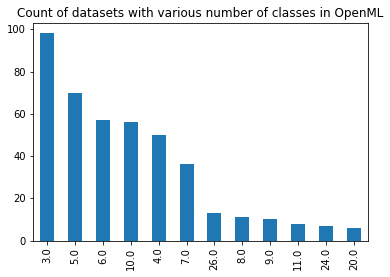

In [4]:
#plot number of datasets for each class size where class size is more than 2
datasets_df[datasets_df['NumberOfClasses'] > 2]['NumberOfClasses'].value_counts()[:20].plot(kind = 'bar')
plt.title('Count of datasets with various number of classes in OpenML')
plt.show()

In [5]:
# output information about selected dataset
datasets_df.loc[60]

name                                  waveform-5000
version                                           1
uploader                                          1
status                                       active
format                                         ARFF
MajorityClassSize                            1692.0
MaxNominalAttDistinctValues                     3.0
MinorityClassSize                            1653.0
NumberOfClasses                                 3.0
NumberOfFeatures                               41.0
NumberOfInstances                            5000.0
NumberOfInstancesWithMissingValues              0.0
NumberOfMissingValues                           0.0
NumberOfNumericFeatures                        40.0
NumberOfSymbolicFeatures                        1.0
Name: 60, dtype: object

In [6]:
# Waveform dataset https://www.openml.org/d/60
dataset = openml.datasets.get_dataset(60)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'waveform-5000', the target feature is 'class'
URL: https://old.openml.org/data/v1/download/60/waveform-5000.arff
**Author**: Breiman,L., Friedman,J.H., Olshen,R.A., & Stone,C.J.  
**Source**: [UCI](http://archive.ics.uci.edu/ml/datasets/waveform+database+generator+(version+2)) - 1988  
**Please cite**: [UCI](http://archive.ics.uci.edu/ml/citation_policy.html)    

**Waveform Database Generator**  
Generator generating 3 classes of waves. Each class is generated from a combination of 2 of 3 "base" waves.  

For details, see Breiman,L., Friedman,J.H., Olshen,R.A., and Stone,C.J. (1984). 
Classification and R


In [7]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [8]:
df.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x32  \
0 -0.23 -1.21  1.20  1.23 -0.10  0.12  2.49  1.19  1.34  0.58  ... -0.86   
1  0.38  0.38 -0.31 -0.09  1.52  1.35  1.49  3.81  2.33  1.34  ...  1.28   
2 -0.69  1.00  1.08  1.48  2.44  3.39  3.09  4.08  5.48  3.61  ...  0.29   
3  0.40  0.68  0.27  1.39  1.03 -0.32 -1.23 -0.50  0.11  0.87  ...  0.43   
4 -0.81  1.59 -0.69  1.16  4.22  4.98  4.52  2.54  5.60  4.66  ...  0.62   

    x33   x34   x35   x36   x37   x38   x39   x40  class  
0 -0.70  0.51  0.34 -0.13 -0.87  0.56 -0.53  0.29      2  
1  1.40  0.00 -0.18  0.71  0.04  0.91 -0.79  0.22      0  
2  1.12  0.60  0.28  2.17  0.18 -0.09 -1.33  1.00      1  
3 -0.30 -0.07 -0.99 -0.75  1.11  1.35 -1.63  0.10      0  
4  0.14  1.33 -1.87  1.48 -0.02 -0.58  0.93  0.40      1  

[5 rows x 41 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float32
 1   x2      5000 non-null   float32
 2   x3      5000 non-null   float32
 3   x4      5000 non-null   float32
 4   x5      5000 non-null   float32
 5   x6      5000 non-null   float32
 6   x7      5000 non-null   float32
 7   x8      5000 non-null   float32
 8   x9      5000 non-null   float32
 9   x10     5000 non-null   float32
 10  x11     5000 non-null   float32
 11  x12     5000 non-null   float32
 12  x13     5000 non-null   float32
 13  x14     5000 non-null   float32
 14  x15     5000 non-null   float32
 15  x16     5000 non-null   float32
 16  x17     5000 non-null   float32
 17  x18     5000 non-null   float32
 18  x19     5000 non-null   float32
 19  x20     5000 non-null   float32
 20  x21     5000 non-null   float32
 21  x22     5000 non-null   float32
 22  

In [10]:
df.describe()

x1           x2           x3           x4          x5  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.00000   
mean     -0.018560     0.326166     0.650104     1.003314     1.35229   
std       1.001375     1.038731     1.178917     1.421482     1.66854   
min      -3.540000    -3.220000    -3.070000    -3.270000    -3.47000   
25%      -0.682500    -0.390000    -0.170000    -0.020000     0.07000   
50%      -0.030000     0.310000     0.640000     0.920000     1.20000   
75%       0.660000     1.020000     1.430000     2.000000     2.53000   
max       3.350000     4.250000     4.720000     5.680000     6.66000   

                x6           x7          x8           x9          x10  ...  \
count  5000.000000  5000.000000  5000.00000  5000.000000  5000.000000  ...   
mean      2.009398     2.665553     2.68128     2.676300     2.996005  ...   
std       1.836581     2.032673     1.75748     1.668995     1.524577  ...   
min      -3.240000    -2.970000    -2.71000    -2.260000    -1.720000  ...   
25%       0.640000     1.110000     1.34000     1.490000     1.900000  ...   
50%       1.840000     2.530000     2.73000     2.825000     3.010000  ...   
75%       3.390000     4.220000     3.99250     3.940000     4.100000  ...   
max       7.810000     8.530000     7.56000     7.330000     7.860000  ...   

               x32          x33          x34          x35          x36  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.030428     0.013870     0.033194     0.010934     0.018974   
std       0.992020     1.015414     1.003250     1.003842     0.993278   
min      -3.410000    -3.440000    -3.730000    -3.490000    -3.520000   
25%      -0.640000    -0.660000    -0.650000    -0.650000    -0.660000   
50%       0.040000     0.030000     0.060000    -0.000000     0.010000   
75%       0.700000     0.710000     0.730000     0.682500     0.682500   
max       3.190000     3.380000     4.040000     3.550000     3.330000   

               x37          x38          x39          x40        class  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean     -0.025552    -0.010842    -0.004842     0.025928     0.992600  
std       0.992161     0.995722     1.010486     1.002821     0.818217  
min      -3.390000    -3.290000    -3.510000    -3.750000     0.000000  
25%      -0.720000    -0.660000    -0.670000    -0.652500     0.000000  
50%      -0.030000    -0.030000     0.000000     0.030000     1.000000  
75%       0.650000     0.670000     0.680000     0.690000     2.000000  
max       3.320000     3.720000     3.330000     3.500000     2.000000  

[8 rows x 41 columns]

In [11]:
# print number of classes
n_classes = df['class'].nunique()
print('Number of classes: {}'.format(n_classes))

Number of classes: 3


In [12]:
# print number of classes
classes = np.sort(df['class'].unique())

In [13]:
classes

array([0, 1, 2])

In [14]:
# compress memory footprint using dtype_diet whilst retaining information 
proposed_df = report_on_dataframe(df, unit="MB")
print('Original df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

df = optimize_dtypes(df, proposed_df)

print('Optimized df memory: {} MB'.format(round(df.memory_usage(deep=True).sum()/1024/1024, 2)))

Original df memory: 0.8 MB
Optimized df memory: 0.77 MB


In [15]:
#df.to_csv('satimage.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float32
 1   x2      5000 non-null   float32
 2   x3      5000 non-null   float32
 3   x4      5000 non-null   float32
 4   x5      5000 non-null   float32
 5   x6      5000 non-null   float32
 6   x7      5000 non-null   float32
 7   x8      5000 non-null   float32
 8   x9      5000 non-null   float32
 9   x10     5000 non-null   float32
 10  x11     5000 non-null   float32
 11  x12     5000 non-null   float32
 12  x13     5000 non-null   float32
 13  x14     5000 non-null   float32
 14  x15     5000 non-null   float32
 15  x16     5000 non-null   float32
 16  x17     5000 non-null   float32
 17  x18     5000 non-null   float32
 18  x19     5000 non-null   float32
 19  x20     5000 non-null   float32
 20  x21     5000 non-null   float32
 21  x22     5000 non-null   float32
 22  

In [17]:
# imbalanced class problem
df['class'].value_counts()

0    1692
2    1655
1    1653
Name: class, dtype: int64

# Experiments

In [18]:
algos = ['Naive Bayes', 'KNN', 'Support Vector Machine', 'logistic regression', 'neural network', 'Random Forest', \
         'LightGBM', 'XGBoost', 'CatBoost', 'Ada Boost']

number_baseline_algos = len(algos)
print('Number of baseline algorithms: {}'.format(number_baseline_algos))

calibration_algos = ['no calibration', 'sigmoid', 'isotonic', 'sigmoid cv', 'isotonic cv', 'ivap', 'cvap']
number_calibration_algos = len(calibration_algos)

Number of baseline algorithms: 10


In [19]:
# function initialize_array creates an 2d array of size m x n and initializes it with NaNs
def initialize_array(size = (number_baseline_algos, number_calibration_algos)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [20]:
# setup dataframes to store results for the Brier and the Log loss
brier_loss_df = pd.DataFrame(data = initialize_array(), index = algos, columns = calibration_algos)
log_loss_df = brier_loss_df.copy()

In [21]:
brier_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

In [22]:
log_loss_df.head()

no calibration  sigmoid  isotonic  sigmoid cv  \
Naive Bayes                        NaN      NaN       NaN         NaN   
KNN                                NaN      NaN       NaN         NaN   
Support Vector Machine             NaN      NaN       NaN         NaN   
logistic regression                NaN      NaN       NaN         NaN   
neural network                     NaN      NaN       NaN         NaN   

                        isotonic cv  ivap  cvap  
Naive Bayes                     NaN   NaN   NaN  
KNN                             NaN   NaN   NaN  
Support Vector Machine          NaN   NaN   NaN  
logistic regression             NaN   NaN   NaN  
neural network                  NaN   NaN   NaN

## Create proper training, validation and test set

In [23]:
n_folds = 5

In [24]:
df.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x32  \
0 -0.23 -1.21  1.20  1.23 -0.10  0.12  2.49  1.19  1.34  0.58  ... -0.86   
1  0.38  0.38 -0.31 -0.09  1.52  1.35  1.49  3.81  2.33  1.34  ...  1.28   
2 -0.69  1.00  1.08  1.48  2.44  3.39  3.09  4.08  5.48  3.61  ...  0.29   
3  0.40  0.68  0.27  1.39  1.03 -0.32 -1.23 -0.50  0.11  0.87  ...  0.43   
4 -0.81  1.59 -0.69  1.16  4.22  4.98  4.52  2.54  5.60  4.66  ...  0.62   

    x33   x34   x35   x36   x37   x38   x39   x40  class  
0 -0.70  0.51  0.34 -0.13 -0.87  0.56 -0.53  0.29      2  
1  1.40  0.00 -0.18  0.71  0.04  0.91 -0.79  0.22      0  
2  1.12  0.60  0.28  2.17  0.18 -0.09 -1.33  1.00      1  
3 -0.30 -0.07 -0.99 -0.75  1.11  1.35 -1.63  0.10      0  
4  0.14  1.33 -1.87  1.48 -0.02 -0.58  0.93  0.40      1  

[5 rows x 41 columns]

In [25]:
len_test_set = int(0.2 * len(df))
print('Test set size: {}'.format(len_test_set))

Test set size: 1000


In [26]:
len_train_cal_set = len(df) - len_test_set
print('Train and calibration set size: {}'.format(len_train_cal_set))

Train and calibration set size: 4000


In [27]:
df_train_cal, df_test = train_test_split(df, test_size = len_test_set, random_state = 42, shuffle = True)

In [28]:
print('Training and calibration set size: {}'.format(len(df_train_cal)))
print('Test set size: {}'.format(len(df_test)))

Training and calibration set size: 4000
Test set size: 1000


In [29]:
len_cal_set = len_test_set

In [30]:
df_proper_train, df_cal = train_test_split(df_train_cal, test_size = len_cal_set, random_state = 42, 
                                           shuffle = True)

In [31]:
print('Proper training set size: {}'.format(len(df_proper_train)))
print('Calibration set size: {}'.format(len(df_cal)))

Proper training set size: 3000
Calibration set size: 1000


In [32]:
df_proper_train.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x32  \
4702 -1.20  0.85 -0.09  0.02  1.45  0.72  1.69  2.45  3.20  3.70  ...  1.59   
2155  0.78  1.25  1.58  2.23  2.50  2.57  3.23  5.01  2.65  5.22  ... -2.01   
289   1.52  1.25 -0.40 -0.47  0.79 -0.15  0.98  1.19 -0.43  0.57  ... -0.88   
1822 -0.88 -0.07 -0.87  0.59 -0.67  0.27  0.86  2.04  0.24  0.72  ... -1.10   
3442 -1.86  1.79  0.51  2.65  3.58  4.57  4.11  2.58  4.10  1.33  ...  0.88   

       x33   x34   x35   x36   x37   x38   x39   x40  class  
4702  0.13  0.76 -0.66 -0.09  0.30 -0.85  0.49  1.05      2  
2155  1.23  2.61 -0.38  0.76 -0.28 -0.30 -0.02  0.05      1  
289  -0.46 -0.34 -0.88 -0.04 -0.12  0.80 -0.76 -1.02      0  
1822  0.73  0.59  1.25 -1.04  0.16 -1.14  0.06 -2.25      0  
3442 -2.05  0.31 -0.43 -0.57  1.63 -0.45 -0.50  0.15      0  

[5 rows x 41 columns]

In [33]:
X_train = df_train_cal.drop('class', axis=1)
y_train = df_train_cal['class']

In [34]:
X_proper_train = df_proper_train.drop('class', axis=1)
y_proper_train = df_proper_train['class']

X_cal = df_cal.drop('class', axis=1)
y_cal = df_cal['class']

X_test = df_test.drop('class', axis=1)
y_test = df_test['class']

In [35]:
X_proper_train.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
4702 -1.20  0.85 -0.09  0.02  1.45  0.72  1.69  2.45  3.20  3.70  ...  1.13   
2155  0.78  1.25  1.58  2.23  2.50  2.57  3.23  5.01  2.65  5.22  ...  0.25   
289   1.52  1.25 -0.40 -0.47  0.79 -0.15  0.98  1.19 -0.43  0.57  ... -1.32   
1822 -0.88 -0.07 -0.87  0.59 -0.67  0.27  0.86  2.04  0.24  0.72  ...  0.67   
3442 -1.86  1.79  0.51  2.65  3.58  4.57  4.11  2.58  4.10  1.33  ...  0.24   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
4702  1.59  0.13  0.76 -0.66 -0.09  0.30 -0.85  0.49  1.05  
2155 -2.01  1.23  2.61 -0.38  0.76 -0.28 -0.30 -0.02  0.05  
289  -0.88 -0.46 -0.34 -0.88 -0.04 -0.12  0.80 -0.76 -1.02  
1822 -1.10  0.73  0.59  1.25 -1.04  0.16 -1.14  0.06 -2.25  
3442  0.88 -2.05  0.31 -0.43 -0.57  1.63 -0.45 -0.50  0.15  

[5 rows x 40 columns]

In [36]:
X_proper_train.tail()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
3200 -1.56  0.48  1.84  1.27  2.17  2.27  5.65  4.67  2.56  1.97  ...  0.82   
617   0.14  0.53  1.98  3.96  3.06  2.82  5.96  4.81  3.43  2.29  ... -0.22   
1992 -0.59 -1.66  0.31 -1.69 -0.10  0.21  1.62  3.15  2.06  2.30  ... -0.36   
3301 -0.15 -0.21  1.83  1.80  5.18  4.99  5.50  5.25  4.40  5.06  ...  0.20   
3687 -0.99 -1.06  0.33  1.68  2.25  0.95  4.54  1.88  6.20  3.72  ... -0.60   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
3200  0.97 -1.48 -1.68  2.80  1.33  1.41  0.90 -0.57  0.34  
617  -0.12  0.39 -0.33  0.56  2.36  0.79  1.10  2.46 -0.82  
1992 -1.10  0.16  0.24 -0.08 -0.97  1.00 -0.88 -0.71  2.05  
3301 -0.03  0.07 -1.68  1.59 -1.06 -1.12  0.43 -0.20  0.60  
3687  1.11 -2.21  1.07  0.10  0.51  0.59 -0.13  1.13  0.59  

[5 rows x 40 columns]

In [37]:
X_cal.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
682   1.15 -1.71  1.43 -0.62  0.14  0.02  2.08  4.86  2.35  4.55  ...  0.26   
4312 -0.77  0.85  1.74  3.23  2.94  1.02  2.29  2.10  2.35  2.64  ...  0.05   
647  -1.73  1.41  1.75  0.39  3.38  3.59  3.78  3.17  5.39  3.58  ...  0.58   
878   1.06 -0.07  0.79  1.29 -0.56  0.81 -0.32  0.58 -1.25  2.48  ... -0.13   
777  -0.08 -1.02 -0.15  0.51  0.32  1.28  0.22  1.97 -1.50  4.36  ... -1.18   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
682  -1.13 -0.44  0.18  1.18  0.26  0.19  0.07 -0.35  0.56  
4312 -2.12  0.48  1.63 -2.64  0.20  0.52  2.37 -0.55  1.07  
647   0.63  0.86  0.94 -1.38  1.17 -0.96  1.38 -0.19  0.27  
878   0.05 -0.09 -1.91 -0.47 -1.29  0.40 -0.78  1.09  0.94  
777  -0.50 -1.01 -0.21 -0.89  0.63  0.36  0.96  2.00 -0.59  

[5 rows x 40 columns]

In [38]:
X_cal.tail()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
2120 -1.95  0.66 -0.79 -1.12 -0.04  1.87  2.38  1.79  3.88  5.47  ...  0.51   
4322 -0.55  0.40  1.15  0.98  0.38  1.04  1.39  2.53  2.11  3.38  ... -0.69   
2184 -0.27  1.15  1.15  2.52  2.53  2.18  3.80  3.72  2.47  3.63  ...  0.16   
2080  2.93  0.42 -0.55  1.44  2.24  0.10  0.76  2.45  1.59  2.88  ...  0.10   
4298  0.27  0.30  0.73 -0.81  0.20  0.86  0.25  0.77  2.63  3.02  ...  0.44   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
2120  0.27 -0.73  0.58  0.31  0.29 -0.84  0.14 -0.25 -0.71  
4322 -1.16  0.44 -1.21  0.29 -0.20  0.89 -0.06  0.08 -0.97  
2184 -0.94  1.00  2.33 -1.58  0.32 -0.07  1.50  0.16  1.44  
2080  0.17  0.76  0.14  2.03 -1.39  0.20 -1.23 -1.80  0.89  
4298 -1.43  0.20  1.02  0.16  0.59  0.68 -0.72 -1.10  0.57  

[5 rows x 40 columns]

In [39]:
X_test.head()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
1501 -0.95  2.89  2.08  2.52  4.78  4.25  4.54  4.62  3.77  4.06  ... -0.15   
2586 -1.22  0.80  1.09  1.84  3.37  2.73  3.69  2.61  1.50  2.54  ...  1.41   
2653 -0.74 -2.48  1.88  0.21  0.65  2.82  5.10  4.24  5.34  5.50  ... -0.14   
1055 -0.18 -0.46  0.30  1.82  1.11 -2.27 -0.72  0.31  0.48  0.02  ...  1.08   
705   0.24  0.53  0.94 -0.35  0.42  0.32  0.43  1.73  4.49  4.47  ... -0.12   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
1501  0.02  0.86 -1.08 -0.58  0.16  0.78 -0.47  0.24  1.20  
2586 -1.91  0.24  0.52  1.52 -1.16 -0.06 -0.35 -0.54  0.60  
2653  0.03  1.74 -0.94 -0.17 -0.80 -1.86 -1.15 -0.70 -2.08  
1055 -0.46 -1.68 -0.06 -0.57  0.02  1.00  0.18  0.37 -0.07  
705  -1.19 -0.70  0.29 -0.04 -0.77  1.35 -0.35  0.66  1.01  

[5 rows x 40 columns]

In [40]:
X_test.tail()

x1    x2    x3    x4    x5    x6    x7    x8    x9   x10  ...   x31  \
4711  0.23  0.68 -0.65  0.63  1.43 -0.33  1.00  2.44  0.32  0.20  ...  0.50   
2313 -0.65  0.84  1.65  3.69  1.58  4.78  6.19  5.49  4.16  4.09  ...  2.06   
3214  0.87  0.13 -0.84  2.69  2.52  1.73  3.32  3.73  4.17  3.48  ...  0.23   
2732  1.50  0.56 -0.42  0.23 -0.65  0.23  0.03  2.48  4.53  3.99  ... -0.60   
1926  0.11  1.10 -0.42  1.92  2.19  1.18  2.68  1.72  0.92  0.92  ... -1.11   

       x32   x33   x34   x35   x36   x37   x38   x39   x40  
4711 -0.41  2.69 -1.26 -0.49 -0.54 -0.78 -0.64 -0.08  1.55  
2313 -1.15  0.43  0.78 -1.49 -0.67 -0.03 -1.43  1.09 -0.30  
3214 -1.56 -0.43  0.57  0.76  0.15  1.20  0.21  0.75 -0.73  
2732 -1.12  0.81  0.80 -0.95  2.01 -0.13  0.79  1.61  1.76  
1926  1.19 -0.17  1.37 -0.09 -0.23  1.71 -0.67 -1.38  1.52  

[5 rows x 40 columns]

In [41]:
y_proper_train.tail()

3200    0
617     0
1992    2
3301    0
3687    1
Name: class, dtype: int8

In [42]:
y_cal.tail()

2120    1
4322    2
2184    0
2080    0
4298    2
Name: class, dtype: int8

In [43]:
y_test.tail()

4711    0
2313    0
3214    1
2732    2
1926    0
Name: class, dtype: int8

In [44]:
assert(len(X_train) == len(X_proper_train) + len(X_cal))

In [45]:
assert(len(df) == len(X_train) + len(X_test))

In [46]:
# function initialize_array creates a 3d array size and initializes it with NaNs

def initialize_3d_array(size = (n_classes, n_classes, len_test_set)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

In [47]:
# function initialize_array creates a 4d array and initializes it with NaNs

def initialize_4d_array(size = (n_classes, n_classes, len_test_set, n_folds)):
  an_array = np.empty(size)
  an_array[:] = np.NaN
  return an_array

## Binary classification

In [48]:
algos

['Naive Bayes',
 'KNN',
 'Support Vector Machine',
 'logistic regression',
 'neural network',
 'Random Forest',
 'LightGBM',
 'XGBoost',
 'CatBoost',
 'Ada Boost']

In [49]:
# given pairwise probabilities compute multiclass probabilities
def multi_probabilities(scores_pairwise, len_test_set):
    prob = np.empty(shape = (n_classes,1))
    probs = np.empty(shape = (n_classes,len_test_set))

    for idx in range(len_test_set):
        prob[0]=1/(1/(scores_pairwise[0,1,idx])+1/(scores_pairwise[0,2,idx])
                   -(n_classes-2))
                   
        prob[1]=1/(1/(scores_pairwise[1,0,idx])+1/(scores_pairwise[1,2,idx])
                   -(n_classes-2))

        prob[2]=1/(1/(scores_pairwise[2,0,idx])+1/(scores_pairwise[2,1,idx])
                   -(n_classes-2))

      
        #normalize probabilities 
        probs[0,idx] = prob[0]/(prob[0]+prob[1]+prob[2])
        probs[1,idx] = prob[1]/(prob[0]+prob[1]+prob[2])
        probs[2,idx] = prob[2]/(prob[0]+prob[1]+prob[2])
       


    return probs    

In [50]:
classes

array([0, 1, 2])

In [51]:
# # given pairwise probabilities compute multiclass probabilities
# def multi_probabilities(scores_pairwise, len_test_set):
#   prob = np.empty(shape = (n_classes,1))
#   probs = np.empty(shape = (n_classes,len_test_set))
  
#   for idx in range(len_test_set):
#       for i in range(n_classes):
#           sum_denom  = 0
#           for j in range(n_classes): 
#               # if the same class number continue to next element
#               if i == j:
#                   continue
#               else:
#                   sum_denom = sum_denom + 1/(scores_pairwise[i,j,idx])            
#           prob = 1/(sum_denom - (n_classes-2))
#           #normalize probabilities 
#           probs[i, idx] = prob / np.sum(prob)
    
#   return probs  

In [52]:
# compute uncalibrated probabilities and predicted classes
def uncalibrated_predictions(model,n_classes=n_classes, X_train=X_train, y_train=y_train):
    
    # initialize 3D array of uncalibrated pairwise prediction scores 
    scores_pairwise_nocal = np.empty((n_classes,n_classes, len(X_test)), dtype = 'float')
    scores_pairwise_nocal[:] = np.nan

    # compute pairwise uncalibrated prediction scores 
    print('\nComputing pairwise uncalibrated predictions')
    for i in range(0,n_classes): # iterate over n_classes
        for j in range(0,n_classes):
            if i == j:
                continue  
            print('fitting model for i: {}, j:{}'.format(i,j))
            class1_train_idx = y_train[y_train == i].index
            class0_train_idx = y_train[y_train == j].index
        
            # create pairwise datasets 
            y_train_pairwise_0 = y_train.loc[class0_train_idx]
            y_train_pairwise_0 = pd.Series(data = 0, index = y_train_pairwise_0.index)
            y_train_pairwise_1 = y_train.loc[class1_train_idx]
            y_train_pairwise_1 = pd.Series(data = 1, index = y_train_pairwise_1.index)

            X_train_pairwise = pd.concat([X_train.loc[class0_train_idx], X_train.loc[class1_train_idx]])
            y_train_pairwise = pd.concat([y_train_pairwise_0, y_train_pairwise_1])

            model.fit(X_train_pairwise, y_train_pairwise)

            # predict probabilities of class 1
            scores_pairwise_nocal[i,j,:] = model.predict_proba(X_test)[:,1]
 
    # compute multiclass uncalibrated prediction scores
    y_pred_probs = multi_probabilities(scores_pairwise_nocal, len_test_set)
    
    #compute class and probability of predicted class - in turn equals to maximum probability for each test object  
    y_pred_class = np.argmax(y_pred_probs, axis=0)
    
    return [y_pred_class, y_pred_probs]

In [53]:
# plot ROC curve, y_test - actual labels, y_pred_probs - predicted probabilities  
def plot_roc_curve(y_test, y_pred_probs, y_pred_class, n_classes = n_classes):
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    y_test_binarized = label_binarize(y_test, classes=classes)
    y_score = y_pred_probs.T

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #plot Plot of a ROC curve for a specific class - index in roc_auc

    plt.figure()
    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.4f)" % roc_auc[1],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    print(multilabel_confusion_matrix(y_test, y_pred_class))
    
        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(15,10), dpi=80)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()

In [54]:
#The function that implements the Venn-ABERS Predictor is ScoresToMultiProbs().
# p0,p1 = ScoresToMultiProbs(calibrPts,testScores)
# calibrPts: a list of pairs (score,label) corresponding to the scores and labels of the calibration examples. The score is a float and the label is an integer meant to take values 0 or 1.
# testScores: a list of floats corresponding to the scores for the test objects.
# The function returns a pair of Numpy arrays with the probabilistic predictions.

In [55]:
# function creates pairwise datasets based on indices for 0 an 1 class
def create_pairwise_datasets(X, y, index_0, index_1):
    
    class0_idx = y[y == index_0].index
    class1_idx = y[y == index_1].index
    
    # create pairwise datasets 
    y_pairwise_0 = pd.Series(data = 0, index = y.loc[class0_idx].index)
    y_pairwise_1 = pd.Series(data = 1, index = y.loc[class1_idx].index)

    X_pairwise = pd.concat([X.loc[class0_idx],X.loc[class1_idx]])
    y_pairwise = pd.concat([y_pairwise_0, y_pairwise_1])
    return [X_pairwise, y_pairwise]

In [56]:
# compute calibrated probabilities and predicted classes
def compute_predictions(model,model_name, n_classes=n_classes, X_proper_train=X_proper_train, \
        y_proper_train=y_proper_train,X_cal=X_cal, y_cal=y_cal, y_test = y_test):
    
    y_test_binarized = label_binarize(y_test, classes=classes)
    
    # stratified KFold required for CVAP
    rskf = StratifiedKFold(n_splits=n_folds,shuffle=True, random_state=42)
    
    # compute uncalibrated probabilities and predicted classes
    [y_pred_class_nocal, y_pred_probs_nocal] = uncalibrated_predictions(model)

    # initialize 3D arrays of calibrated pairwise prediction scores
    # function initialize_array creates an array size m x n and initializes it with NaNs
    probs_pairwise_test_sigm = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_sigm_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_iso_cv = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_pairwise_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set)) 
    
    probs_test_ivap = initialize_3d_array((n_classes, n_classes, len_test_set))
    probs_test_cvap = initialize_3d_array((n_classes, n_classes, len_test_set))
    
    p0_folds_cvap = initialize_array((len_test_set, n_folds))
    p1_folds_cvap = initialize_array((len_test_set, n_folds))
    
    # compute pairwise uncalibrated prediction scores
    print('\nComputing pairwise calibrated predictions')
    for i in range(n_classes): # iterate over n_classes
        for j in range(n_classes):
            if i == j:
                  continue
            print('fitting model for i: {}, j:{}'.format(i,j))
            # create pairwise datasets
            X_proper_train_pairwise, y_proper_train_pairwise = create_pairwise_datasets(X_proper_train,\
                y_proper_train, index_0 = classes[j], index_1 = classes[i])
            
            X_train_pairwise, y_train_pairwise = create_pairwise_datasets(X_train, y_train, index_0 = classes[j], index_1 = classes[i])
            X_cal_pairwise, y_cal_pairwise = create_pairwise_datasets(X_cal, y_cal, index_0 = classes[j], index_1 = classes[i])
            
            # fit pairwise base model on the proper training dataset
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)
            
            # calibrate model on calibration data set 
            # Already fitted classifiers can be calibrated via the parameter cv="prefit".
            # In this case, no cross-validation is used and all provided data is used for calibration. 

            # Platt's scaler
            cal_sigm = CalibratedClassifierCV(model, method='sigmoid', cv='prefit', n_jobs = -1)
            cal_sigm.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm[i,j,:] = cal_sigm.predict_proba(X_test)[:,1]

            # Isotonic regression 
            cal_iso = CalibratedClassifierCV(model, method='isotonic', cv='prefit', n_jobs = -1)
            cal_iso.fit(X_cal_pairwise, y_cal_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso[i,j,:] = cal_iso.predict_proba(X_test)[:,1]
            
            ## Cross-validated calibration 
            # Platt's scaler
            cal_sigm_cv = CalibratedClassifierCV(model, method='sigmoid', cv=5, n_jobs = -1)
            cal_sigm_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_sigm_cv[i,j,:] = cal_sigm_cv.predict_proba(X_test)[:,1]

            # Isotonic regression
            cal_iso_cv = CalibratedClassifierCV(model, method='isotonic', cv=5,n_jobs = -1)
            cal_iso_cv.fit(X_train_pairwise, y_train_pairwise)
            # predict probabilities of class 1
            probs_pairwise_test_iso_cv[i,j,:] = cal_iso_cv.predict_proba(X_test)[:,1]
        
            # Venn-Abers IVAP
            model.fit(X_proper_train_pairwise, y_proper_train_pairwise)

            # predict probabilities of class 1
            probability_pairwise_cal_ivap = model.predict_proba(X_cal_pairwise)[:,1]
            probability_pairwise_test_ivap = model.predict_proba(X_test)[:,1]

            p0_ivap,p1_ivap = ScoresToMultiProbs(list(zip(probability_pairwise_cal_ivap,y_cal_pairwise)),\
                                                 probability_pairwise_test_ivap)
    
            probs_pairwise_test_ivap[i,j,:] = p1_ivap/(1-p0_ivap+p1_ivap)
            
            
            # Venn-Abers CVAP - Support Vector Classifier
            
            idx = 0
            
            for proper_train_index, cal_index in rskf.split(X_train_pairwise, y_train_pairwise):
            #print("TRAIN:", proper_train_index[:20], "TEST:", cal_index[:20])
                X_proper_train_fold, X_cal_fold = X_train_pairwise.iloc[proper_train_index],X_train_pairwise.iloc[cal_index]
                y_proper_train_fold, y_cal_fold = y_train_pairwise.iloc[proper_train_index],y_train_pairwise.iloc[cal_index]

                # fit base model on the proper training dataset
                model.fit(X_proper_train_fold, y_proper_train_fold)

                # predict probabilities of class 1
                probability_folds_cal_cvap = model.predict_proba(X_cal_fold)[:,1]
                probability_folds_test_cvap = model.predict_proba(X_test)[:,1]

                p0_folds_cvap[:, idx],p1_folds_cvap[:,idx] = ScoresToMultiProbs(list(zip(probability_folds_cal_cvap,
                        y_cal_fold)),probability_folds_test_cvap)


                idx = idx + 1

                if idx == n_folds:
                    break

            assert(1 - np.isnan(p0_folds_cvap).any())
            assert(1 - np.isnan(p1_folds_cvap).any())                                                                           

            GM1_p0 = gmean(1- p0_folds_cvap, 1)
            GMp1 = gmean(p1_folds_cvap,1)

            probs_pairwise_test_cvap[i,j,:] = GMp1/(GM1_p0+GMp1) 

            # check if probabilities >= 0 and <= 1    
            assert(1 - np.isnan(probs_pairwise_test_sigm[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_sigm_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_iso_cv[i,j,:]).any())
            assert(1 - np.isnan(probs_pairwise_test_ivap[i,j,:]).any()) 
            assert(1 - np.isnan(probs_pairwise_test_cvap[i,j,:]).any())   

    # compute multiclass calibrated probabilities
    y_pred_probs_sigm = multi_probabilities(probs_pairwise_test_sigm, len_test_set)                                               
    y_pred_probs_iso = multi_probabilities(probs_pairwise_test_iso, len_test_set) 
    y_pred_probs_sigm_cv = multi_probabilities(probs_pairwise_test_sigm_cv, len_test_set)                                                
    y_pred_probs_iso_cv = multi_probabilities(probs_pairwise_test_iso_cv, len_test_set)
    y_pred_probs_ivap = multi_probabilities(probs_pairwise_test_ivap, len_test_set)
    y_pred_probs_cvap = multi_probabilities(probs_pairwise_test_cvap, len_test_set)
    
    # check if probabilities >= 0 and <= 1    
    assert(1 - np.isnan(y_pred_probs_sigm).any())
    assert(1 - np.isnan(y_pred_probs_iso).any())
    assert(1 - np.isnan(y_pred_probs_sigm_cv).any())
    assert(1 - np.isnan(y_pred_probs_iso_cv).any())
    assert(1 - np.isnan(y_pred_probs_ivap).any())
    assert(1 - np.isnan(y_pred_probs_cvap).any())
     
    #compute predicted class  
    y_pred_class_sigm = np.argmax(y_pred_probs_sigm, axis=0)
    y_pred_class_iso = np.argmax(y_pred_probs_iso, axis=0)
    y_pred_class_sigm_cv = np.argmax(y_pred_probs_sigm_cv, axis=0)
    y_pred_class_iso_cv = np.argmax(y_pred_probs_iso_cv, axis=0)    
    y_pred_class_ivap = np.argmax(y_pred_probs_ivap, axis=0)
    y_pred_class_cvap = np.argmax(y_pred_probs_cvap, axis=0)
    
    # output predicted classes and class probabilities
    y_pred_class_list = [y_pred_class_sigm, y_pred_class_iso, y_pred_class_sigm_cv, y_pred_class_iso_cv, 
                         y_pred_class_ivap, y_pred_class_cvap]
    y_pred_probs_list = [y_pred_probs_sigm, y_pred_probs_iso, y_pred_probs_sigm_cv, y_pred_probs_iso_cv,
                         y_pred_probs_ivap, y_pred_probs_cvap]
    
    # insert uncalibrated scores and predicted class from underlying algorithm
    y_pred_probs_list.insert(0,y_pred_probs_nocal)
    y_pred_class_list.insert(0,y_pred_class_nocal)

    log_loss_score = np.empty(shape = (len_test_set))
    brier_score = np.empty(shape = (len_test_set))

    log_loss_score[:] = np.NaN
    brier_score[:] = np.NaN

    for algo_number, cal_algo_name in enumerate(calibration_algos):
        for idx in range(len_test_set):
            log_loss_score[idx] = log_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
            brier_score[idx] = brier_score_loss(y_test_binarized[idx], y_pred_probs_list[algo_number][:,idx])
        log_loss_df.loc[model_name, cal_algo_name] = np.mean(log_loss_score)
        brier_loss_df.loc[model_name, cal_algo_name] = np.mean(brier_score)
        print('\nModel name: {}, calibration algo: {}'.format(model_name, cal_algo_name))
        plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)
        print(classification_report(y_test, y_pred_class_list[algo_number], labels=classes))
        
    return [y_pred_probs_list, y_pred_class_list]

### Naive Bayes


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: Naive Bayes, calibration algo: no calibration


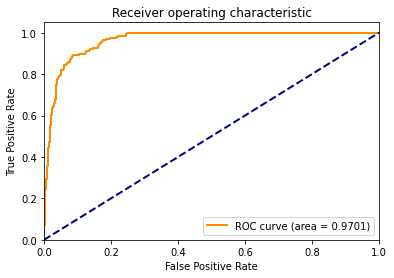

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


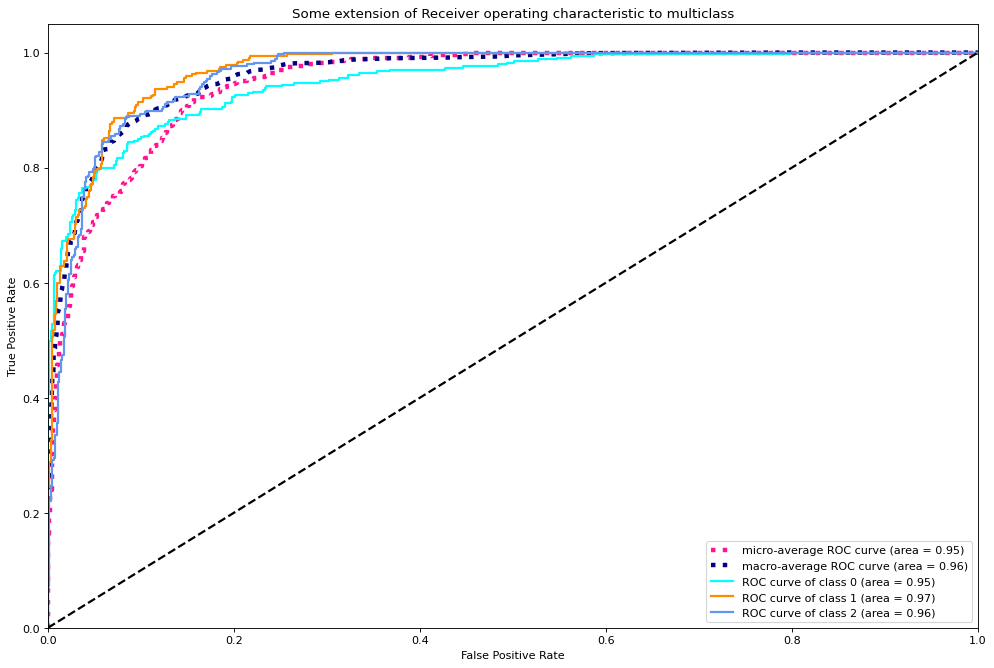

              precision    recall  f1-score   support

           0       0.98      0.54      0.69       339
           1       0.75      0.96      0.84       315
           2       0.77      0.92      0.84       346

    accuracy                           0.80      1000
   macro avg       0.83      0.80      0.79      1000
weighted avg       0.84      0.80      0.79      1000


Model name: Naive Bayes, calibration algo: sigmoid


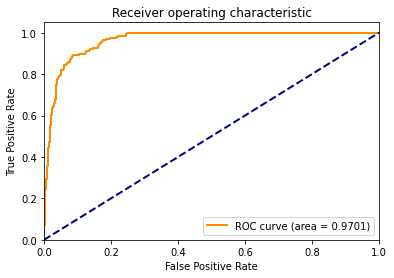

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


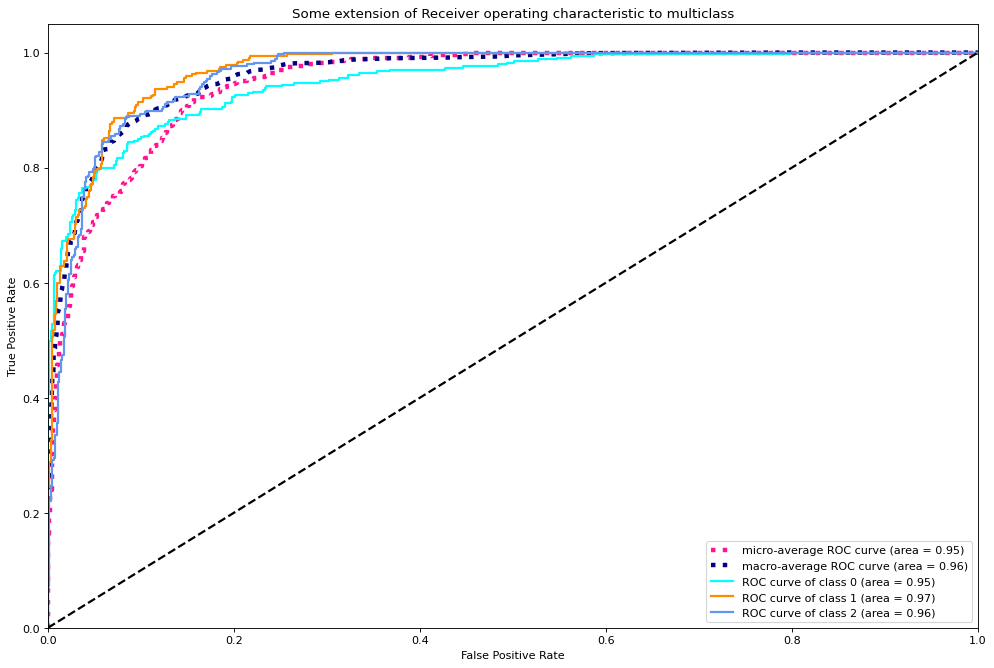

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       339
           1       0.78      0.95      0.85       315
           2       0.81      0.91      0.86       346

    accuracy                           0.83      1000
   macro avg       0.85      0.83      0.83      1000
weighted avg       0.85      0.83      0.83      1000


Model name: Naive Bayes, calibration algo: isotonic


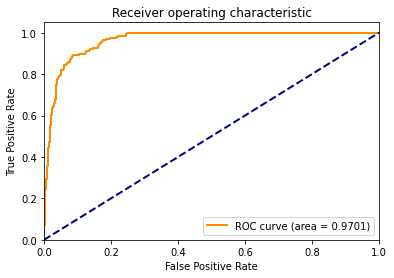

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


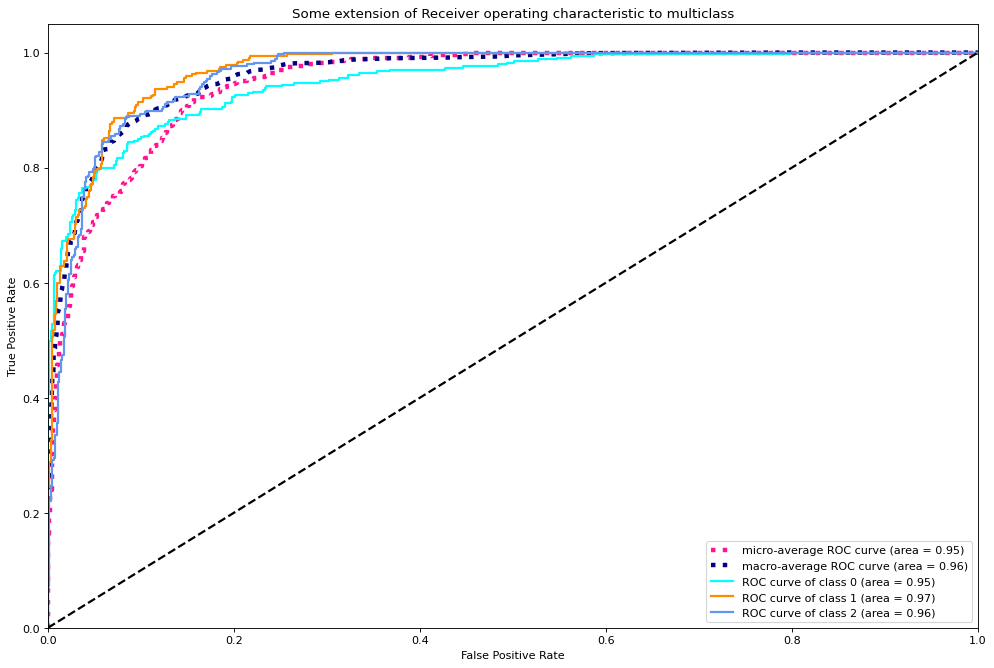

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       339
           1       0.86      0.84      0.85       315
           2       0.87      0.88      0.88       346

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: Naive Bayes, calibration algo: sigmoid cv


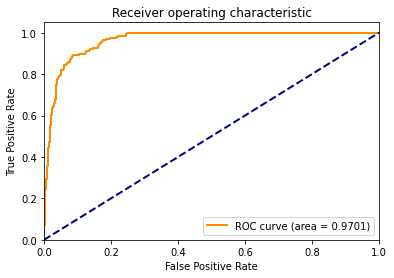

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


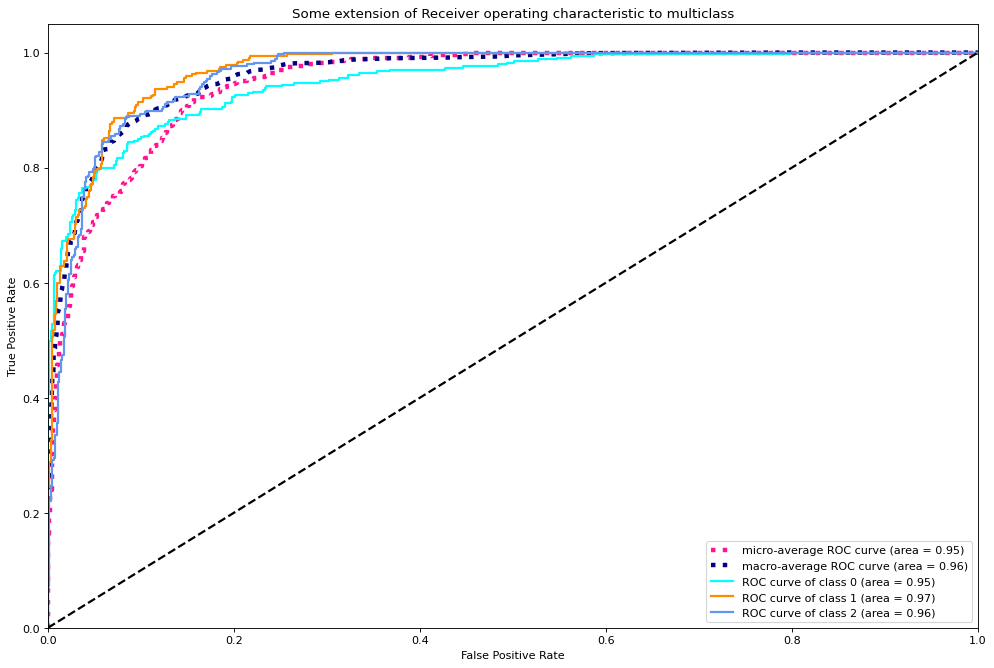

              precision    recall  f1-score   support

           0       0.96      0.64      0.77       339
           1       0.78      0.95      0.86       315
           2       0.81      0.92      0.86       346

    accuracy                           0.83      1000
   macro avg       0.85      0.83      0.83      1000
weighted avg       0.85      0.83      0.83      1000


Model name: Naive Bayes, calibration algo: isotonic cv


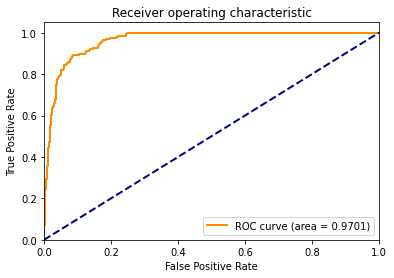

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


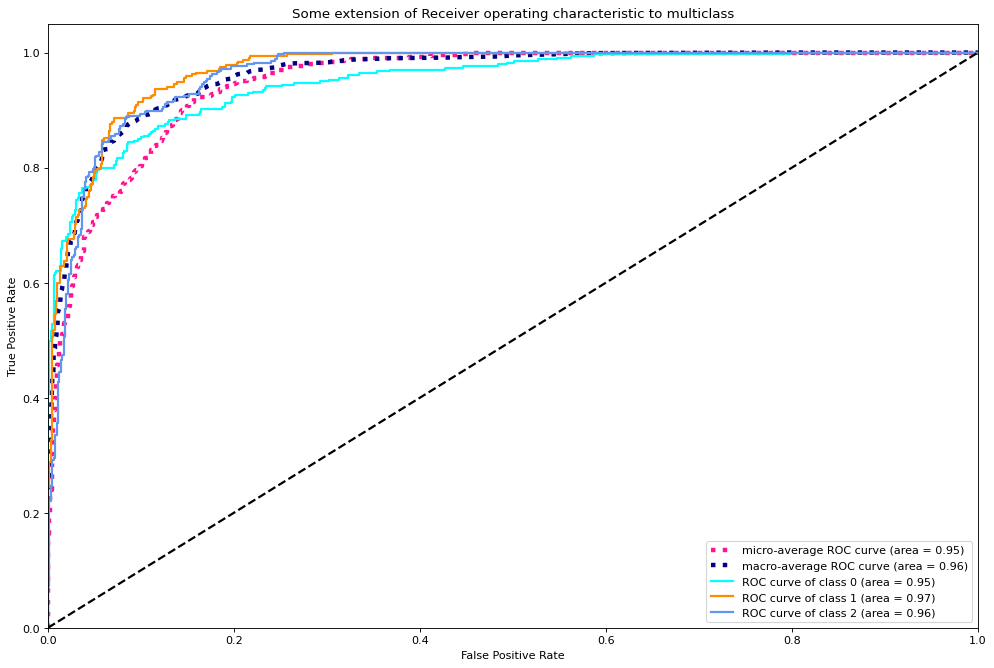

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       339
           1       0.84      0.88      0.86       315
           2       0.86      0.89      0.88       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: Naive Bayes, calibration algo: ivap


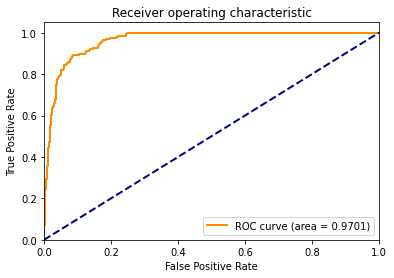

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


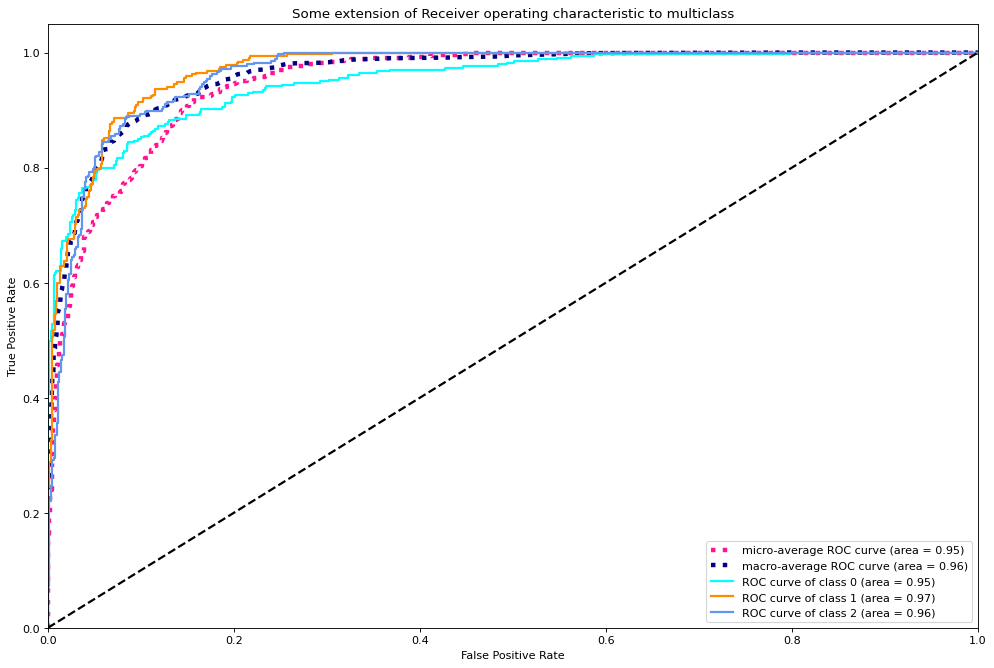

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       339
           1       0.86      0.84      0.85       315
           2       0.86      0.90      0.88       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: Naive Bayes, calibration algo: cvap


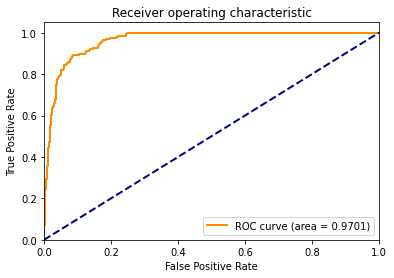

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


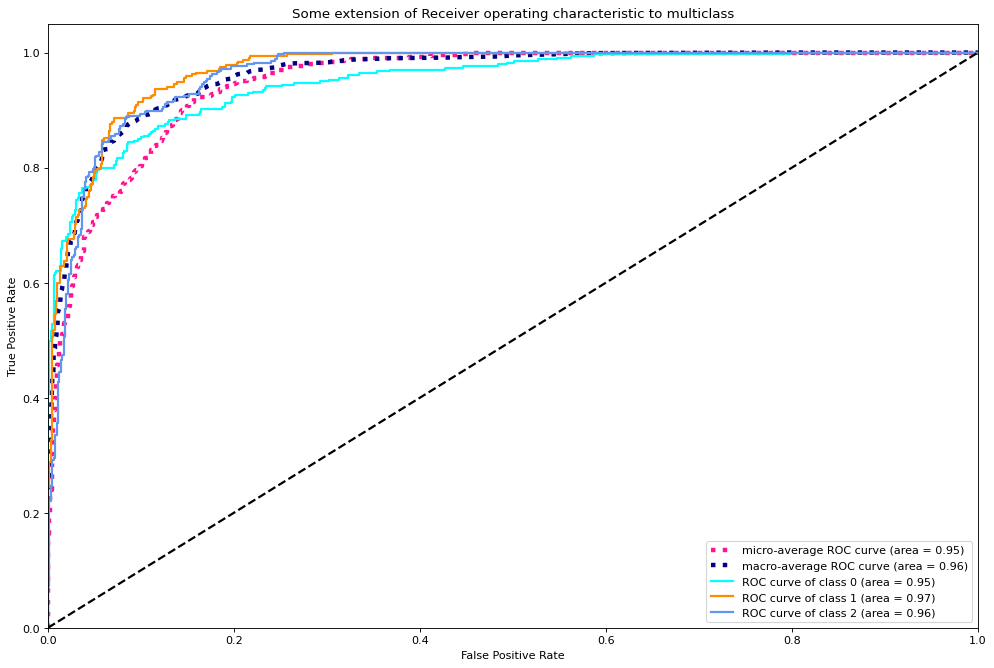

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       339
           1       0.83      0.88      0.85       315
           2       0.86      0.88      0.87       346

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.85      1000
weighted avg       0.86      0.85      0.85      1000



In [57]:
clf_NB = GaussianNB()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_NB, model_name = 'Naive Bayes')

In [58]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                             NaN       NaN       NaN  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [59]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                    0.11138  0.084686  0.068923    0.085617   
KNN                                NaN       NaN       NaN         NaN   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                             NaN       NaN       NaN  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

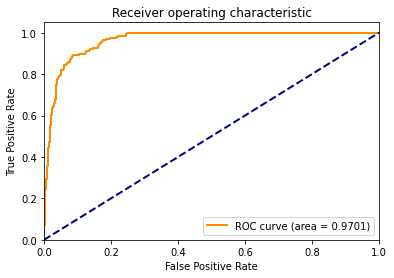

[[[657   4]
  [157 182]]

 [[585 100]
  [ 14 301]]

 [[560  94]
  [ 27 319]]]


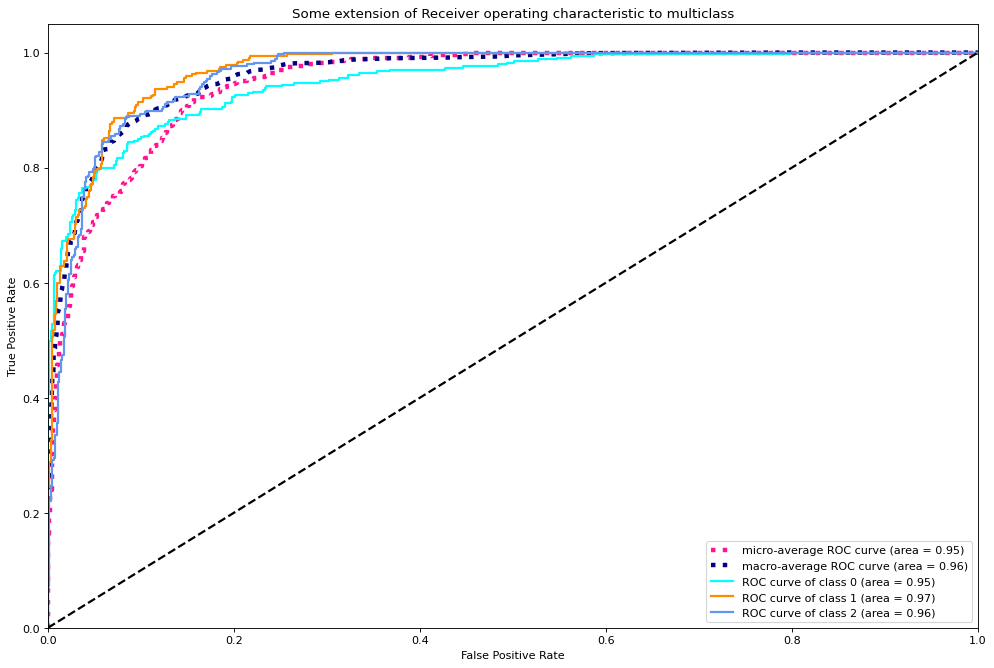

In [60]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

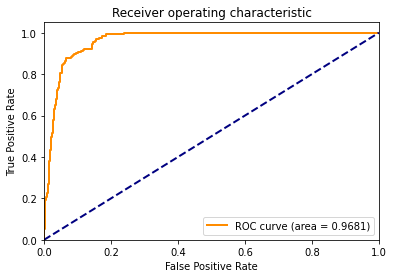

[[[652   9]
  [121 218]]

 [[600  85]
  [ 17 298]]

 [[580  74]
  [ 30 316]]]


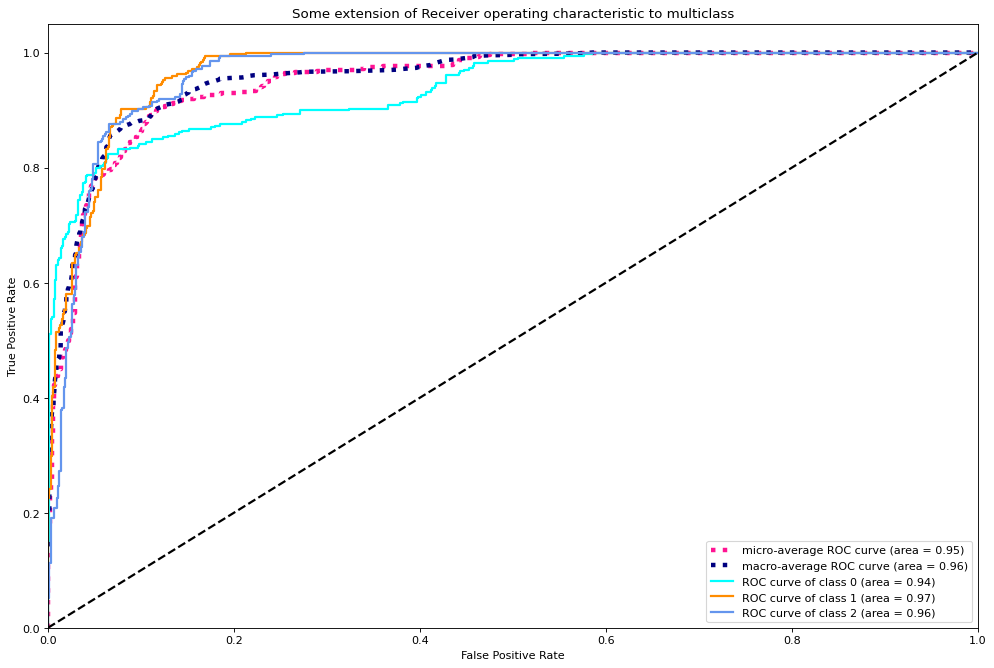

In [61]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### KNN Classifier


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: KNN, calibration algo: no calibration


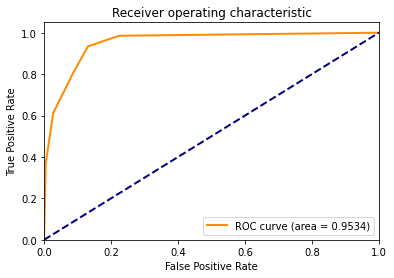

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


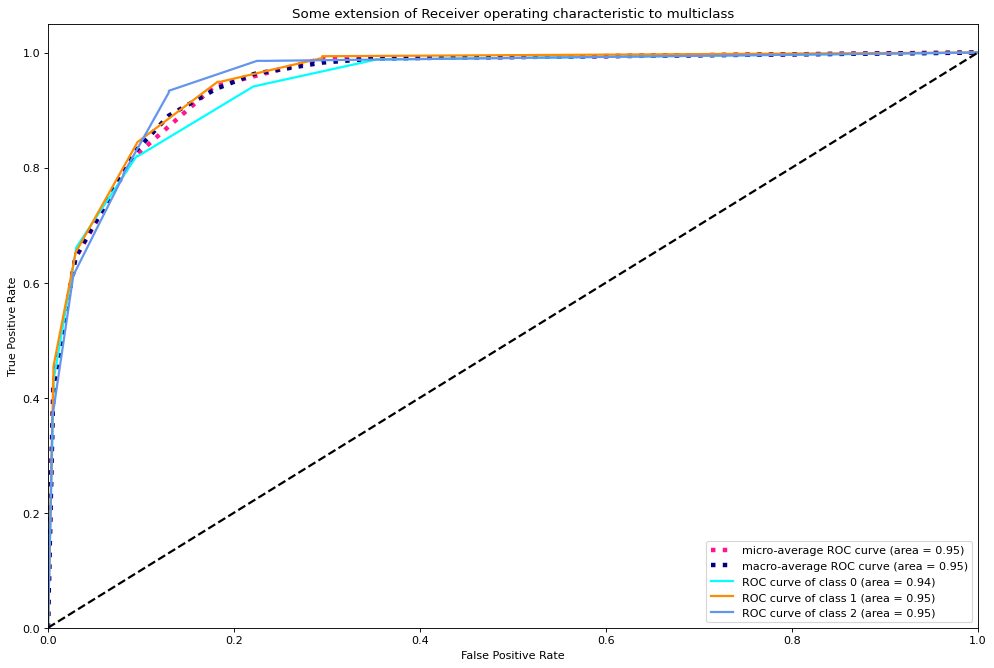

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       339
           1       0.80      0.84      0.82       315
           2       0.84      0.79      0.81       346

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Model name: KNN, calibration algo: sigmoid


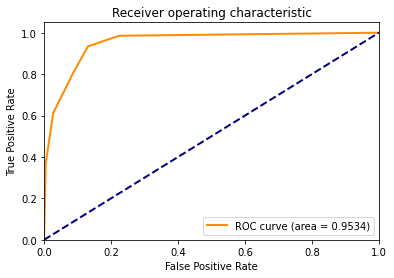

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


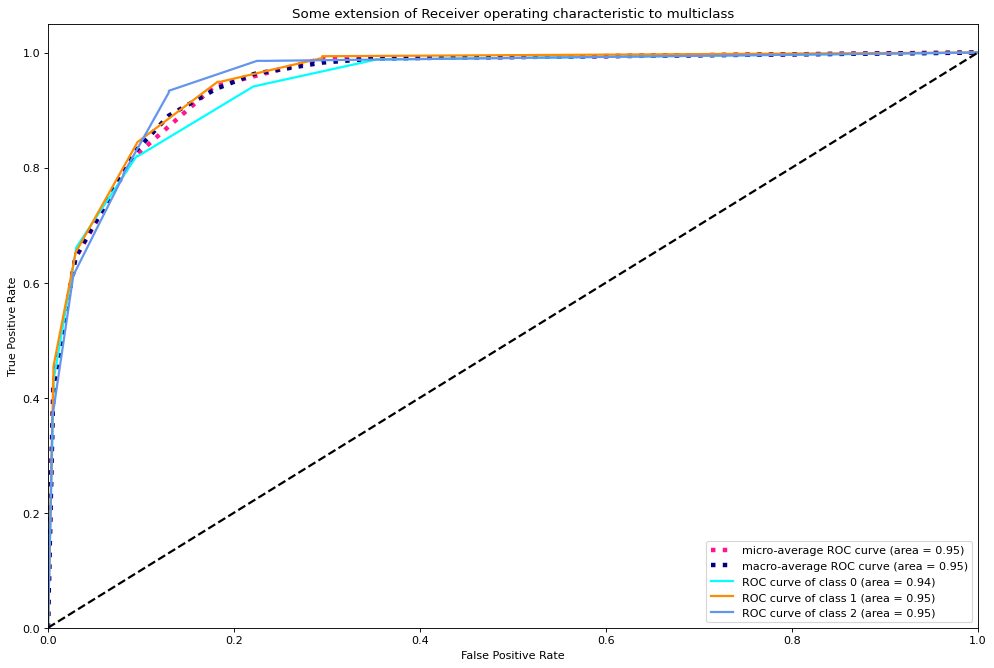

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       339
           1       0.80      0.85      0.82       315
           2       0.85      0.81      0.83       346

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Model name: KNN, calibration algo: isotonic


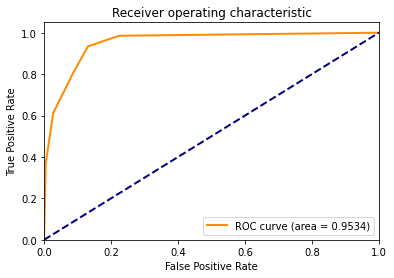

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


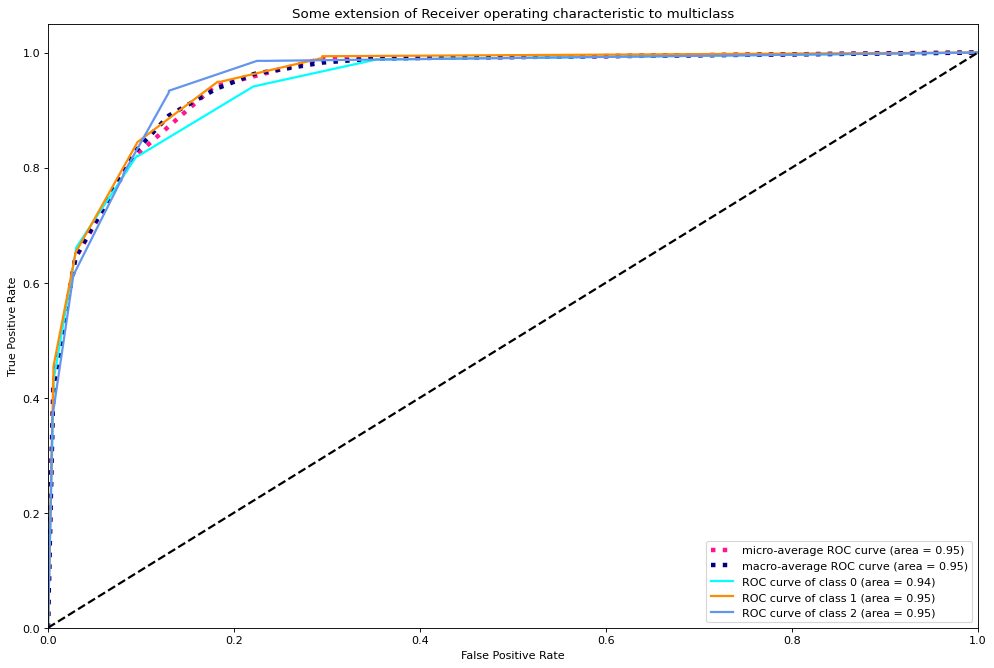

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       339
           1       0.84      0.80      0.82       315
           2       0.82      0.87      0.84       346

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Model name: KNN, calibration algo: sigmoid cv


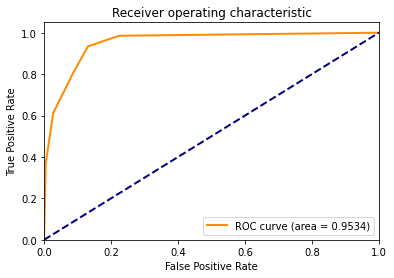

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


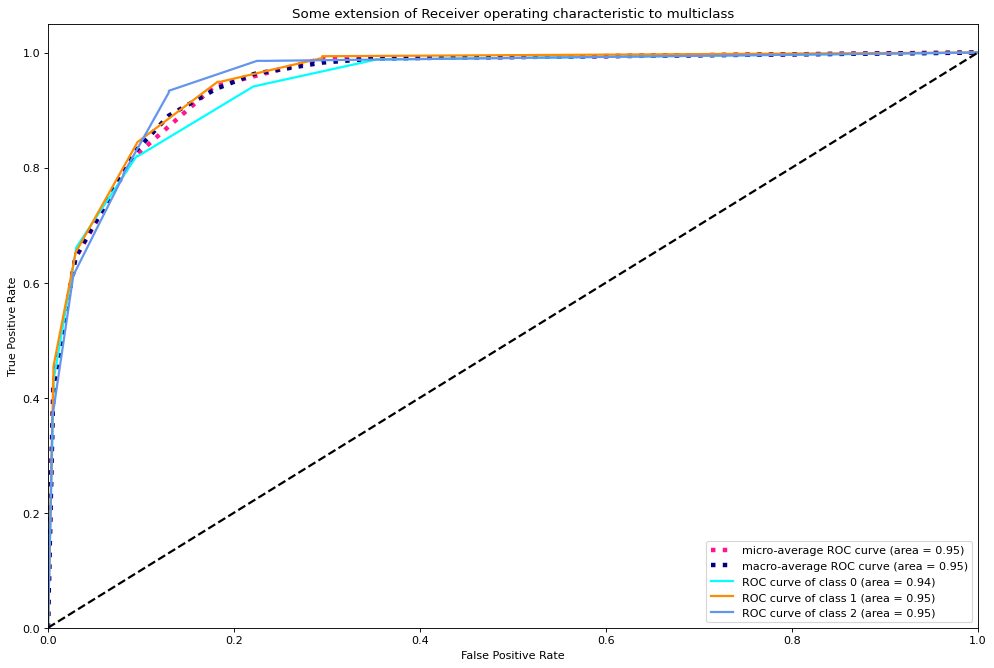

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       339
           1       0.80      0.84      0.82       315
           2       0.85      0.81      0.83       346

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Model name: KNN, calibration algo: isotonic cv


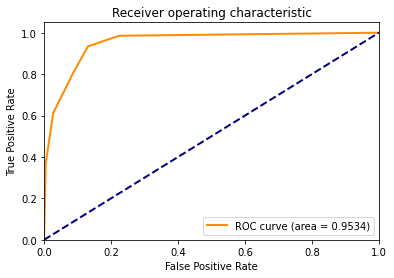

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


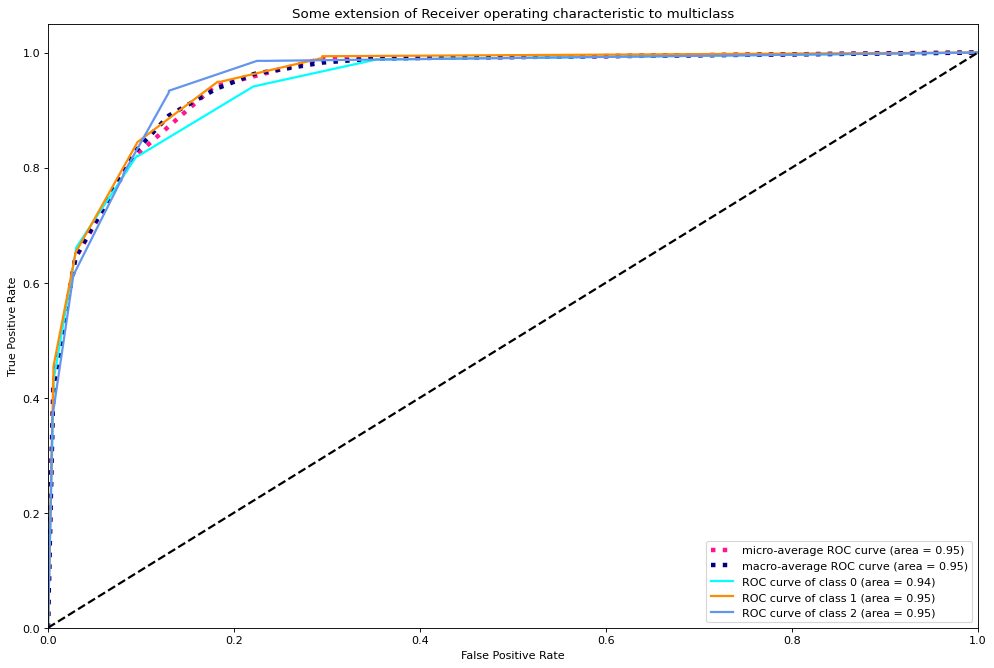

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       339
           1       0.83      0.82      0.83       315
           2       0.83      0.86      0.84       346

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


Model name: KNN, calibration algo: ivap


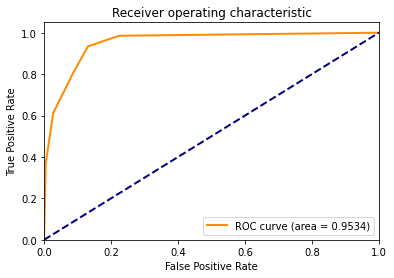

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


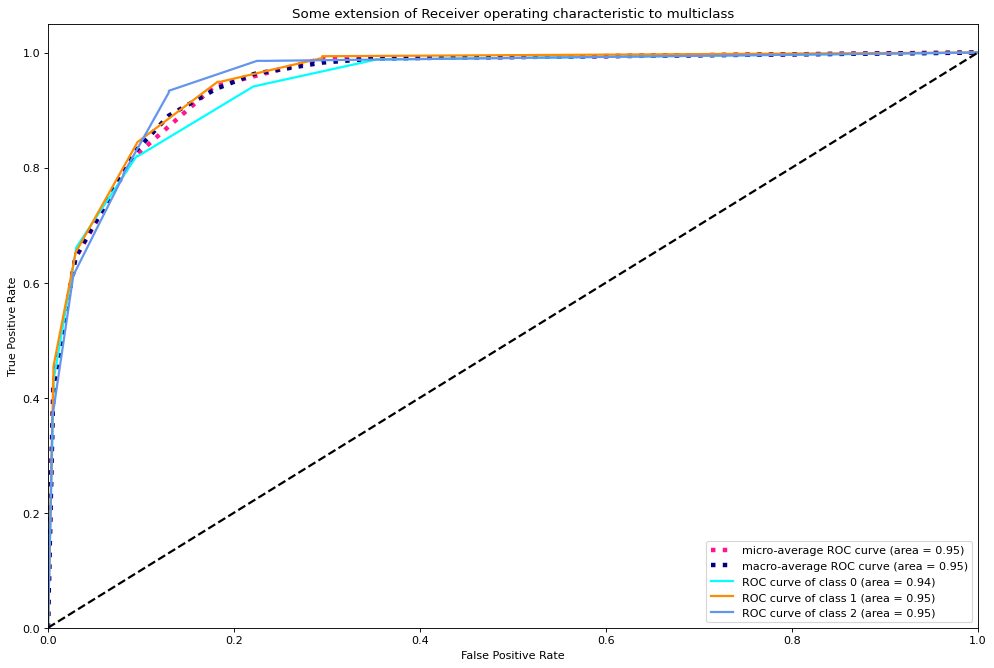

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       339
           1       0.80      0.85      0.82       315
           2       0.85      0.81      0.83       346

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Model name: KNN, calibration algo: cvap


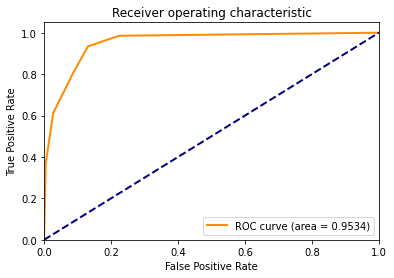

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


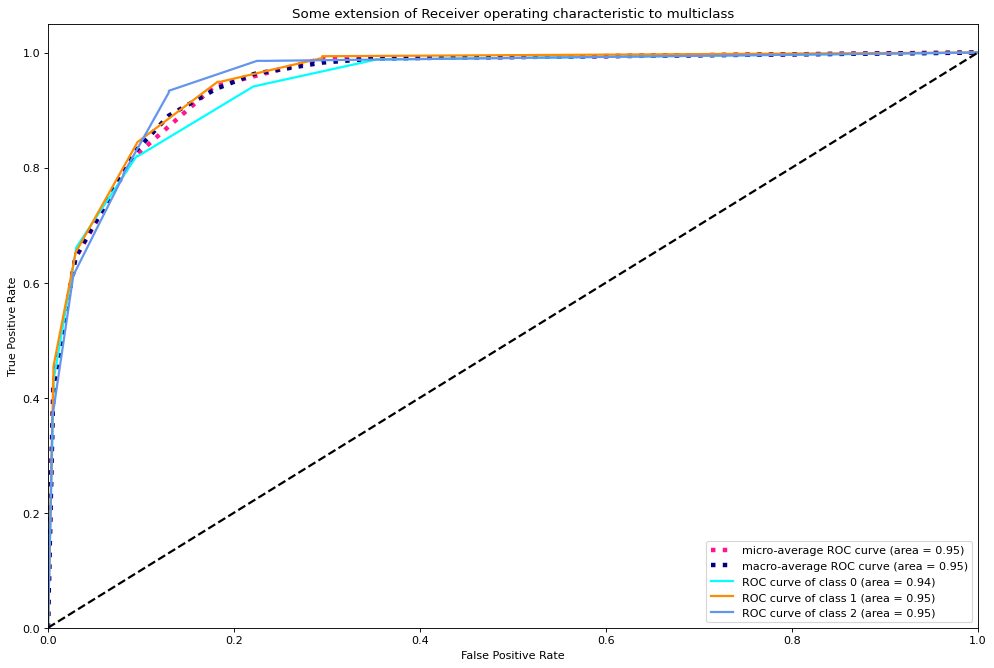

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       339
           1       0.81      0.84      0.83       315
           2       0.84      0.84      0.84       346

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [62]:
clf_KNN = KNeighborsClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_KNN, 
                    model_name = 'KNN')

In [63]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [64]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine             NaN       NaN       NaN         NaN   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine          NaN       NaN       NaN  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

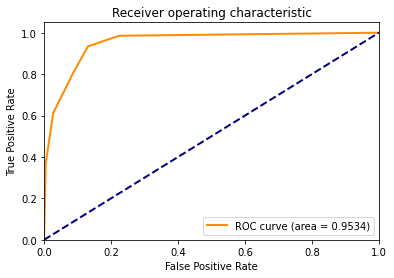

[[[597  64]
  [ 61 278]]

 [[619  66]
  [ 49 266]]

 [[601  53]
  [ 73 273]]]


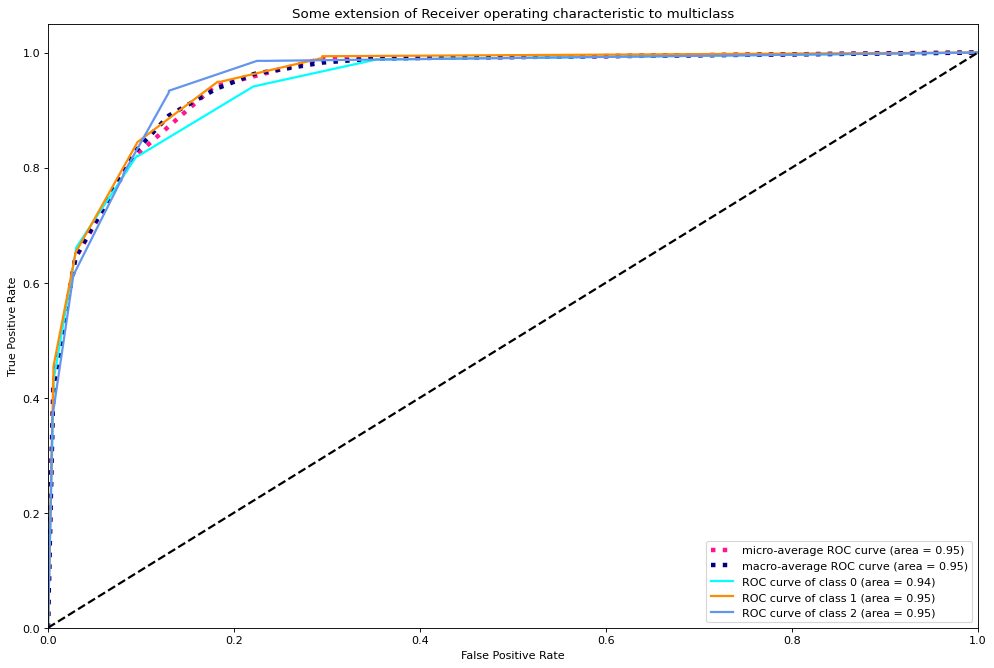

In [65]:

plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

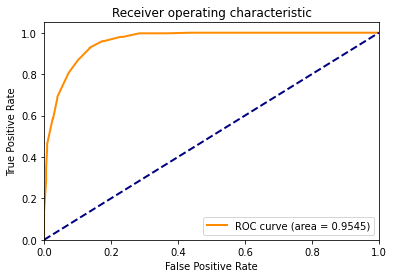

[[[597  64]
  [ 68 271]]

 [[616  69]
  [ 46 269]]

 [[606  48]
  [ 67 279]]]


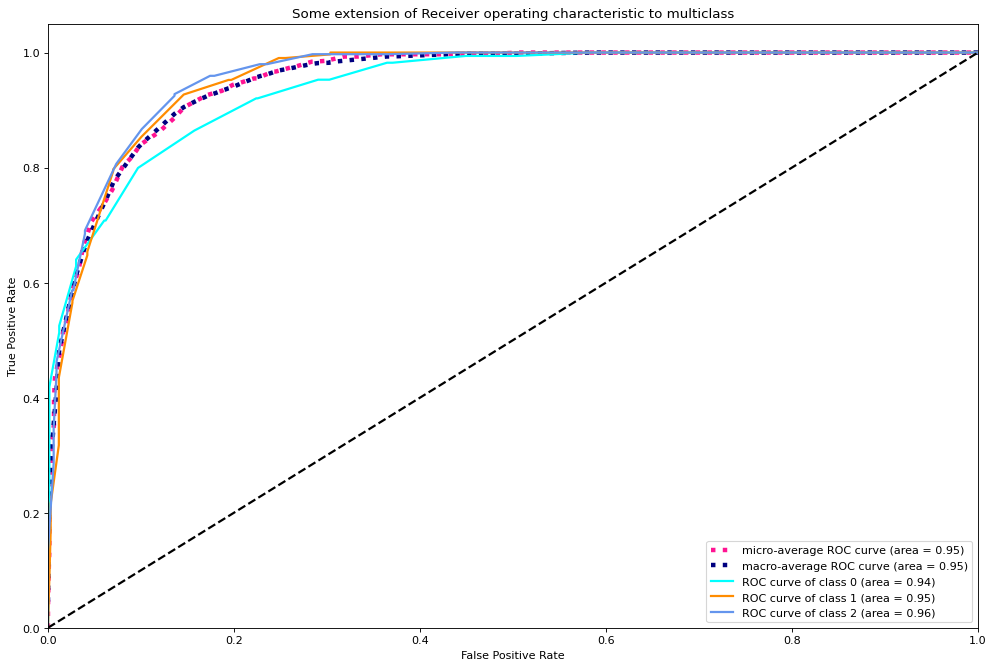

In [66]:

plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Support Vector Machine


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: Support Vector Machine, calibration algo: no calibration


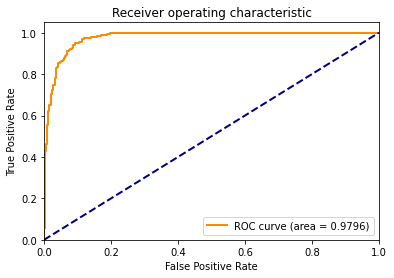

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


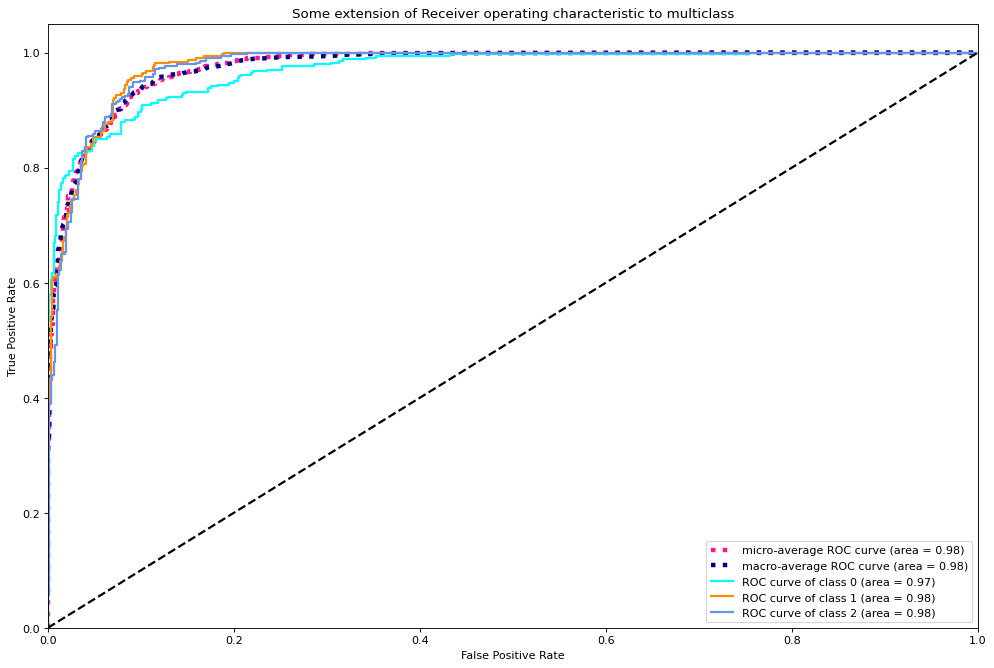

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       339
           1       0.85      0.90      0.88       315
           2       0.90      0.86      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Support Vector Machine, calibration algo: sigmoid


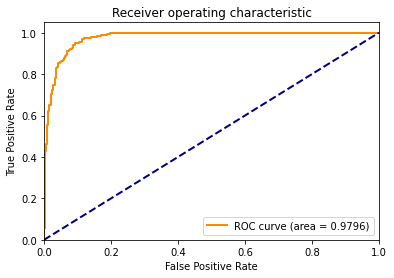

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


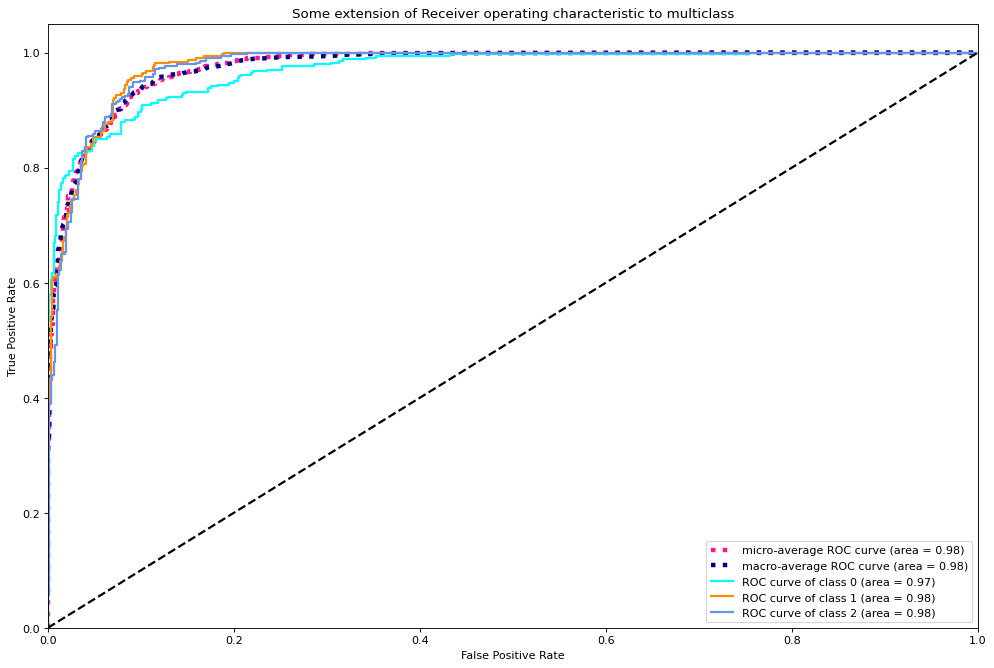

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       339
           1       0.86      0.88      0.87       315
           2       0.89      0.85      0.87       346

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.86      0.87      1000


Model name: Support Vector Machine, calibration algo: isotonic


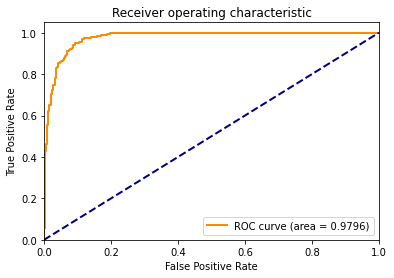

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


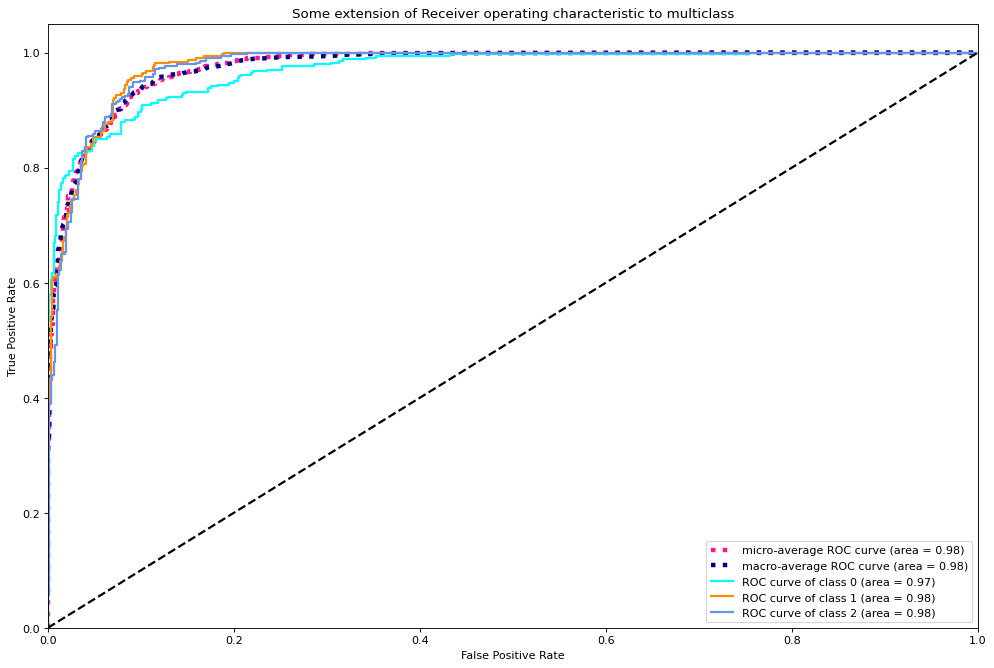

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       339
           1       0.87      0.87      0.87       315
           2       0.89      0.84      0.86       346

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.86      0.87      1000


Model name: Support Vector Machine, calibration algo: sigmoid cv


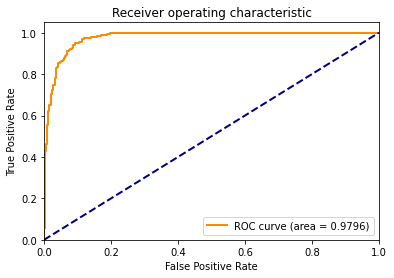

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


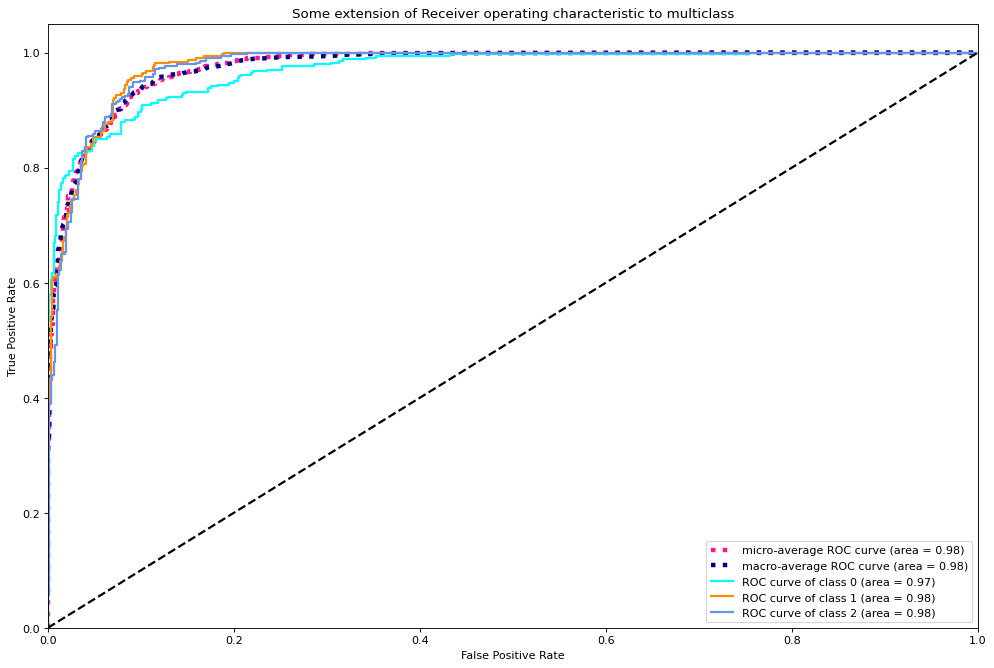

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       339
           1       0.85      0.89      0.87       315
           2       0.90      0.86      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Support Vector Machine, calibration algo: isotonic cv


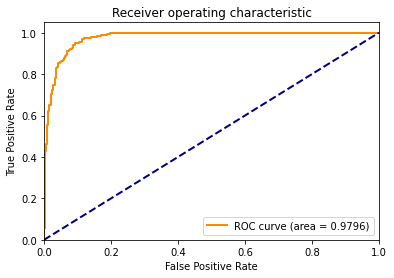

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


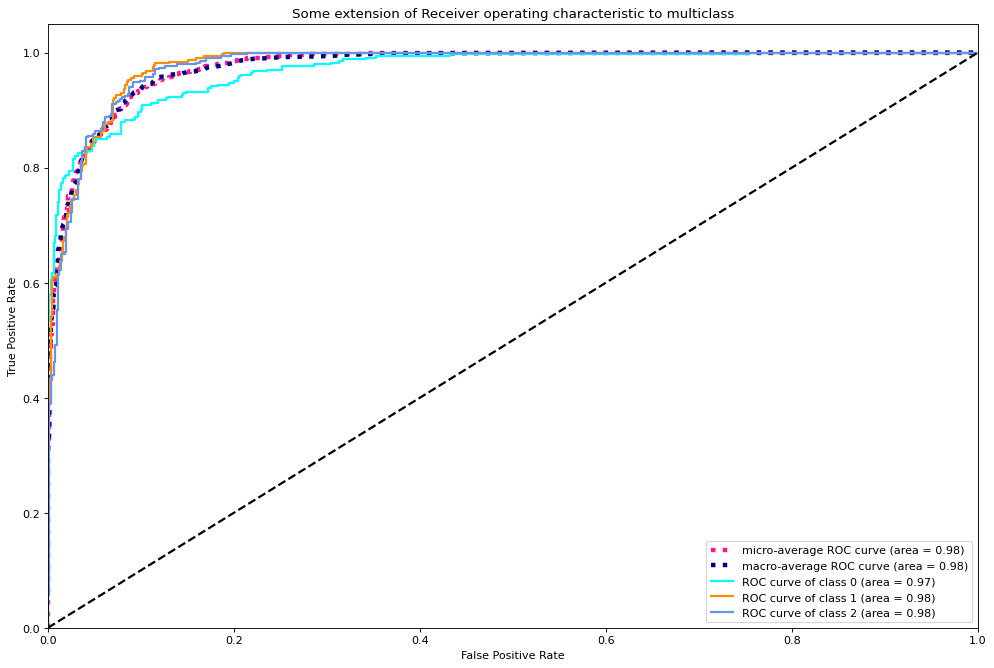

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       339
           1       0.86      0.90      0.88       315
           2       0.89      0.88      0.88       346

    accuracy                           0.88      1000
   macro avg       0.87      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000


Model name: Support Vector Machine, calibration algo: ivap


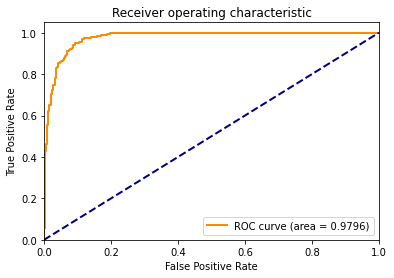

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


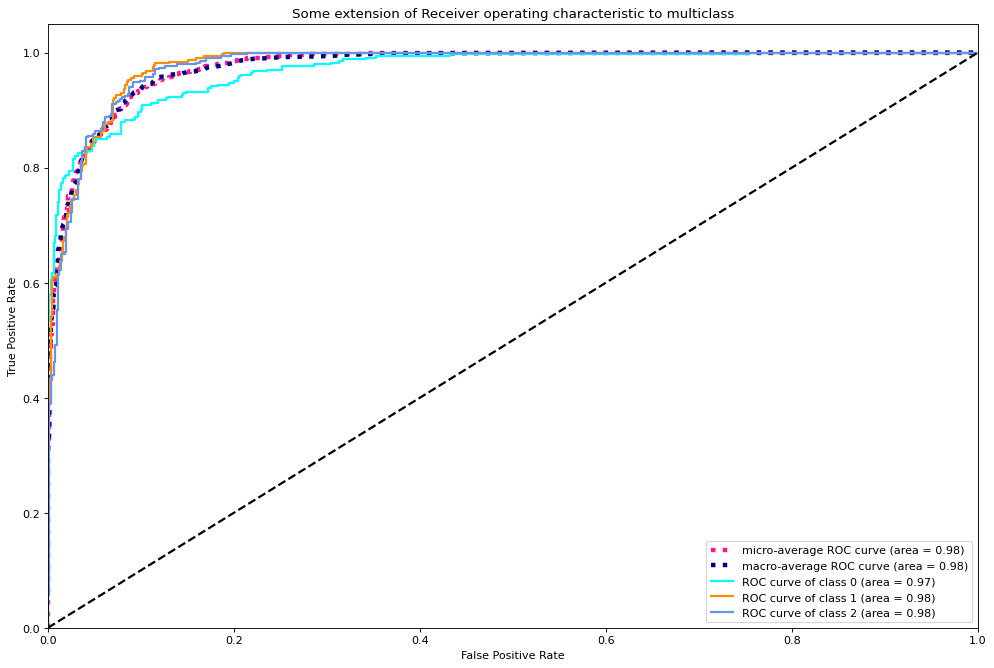

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       339
           1       0.85      0.91      0.88       315
           2       0.89      0.84      0.86       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Support Vector Machine, calibration algo: cvap


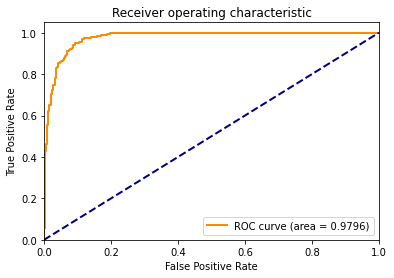

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


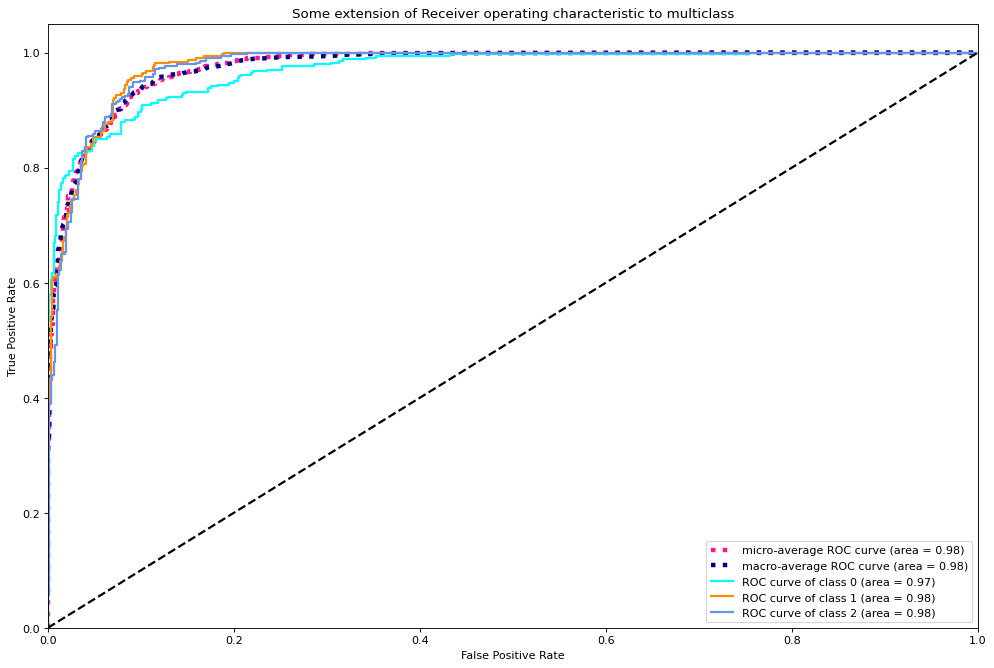

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       339
           1       0.85      0.91      0.88       315
           2       0.89      0.87      0.88       346

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



In [67]:
clf_SVC = SVC(probability=True, random_state=42)


[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_SVC, 
                    model_name = 'Support Vector Machine')

In [68]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [69]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression                NaN       NaN       NaN         NaN   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression             NaN       NaN       NaN  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

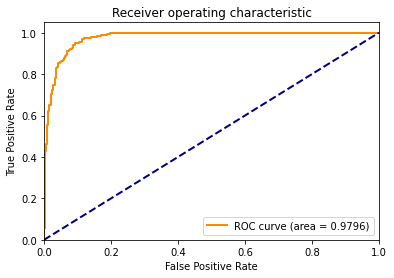

[[[614  47]
  [ 48 291]]

 [[637  48]
  [ 32 283]]

 [[621  33]
  [ 48 298]]]


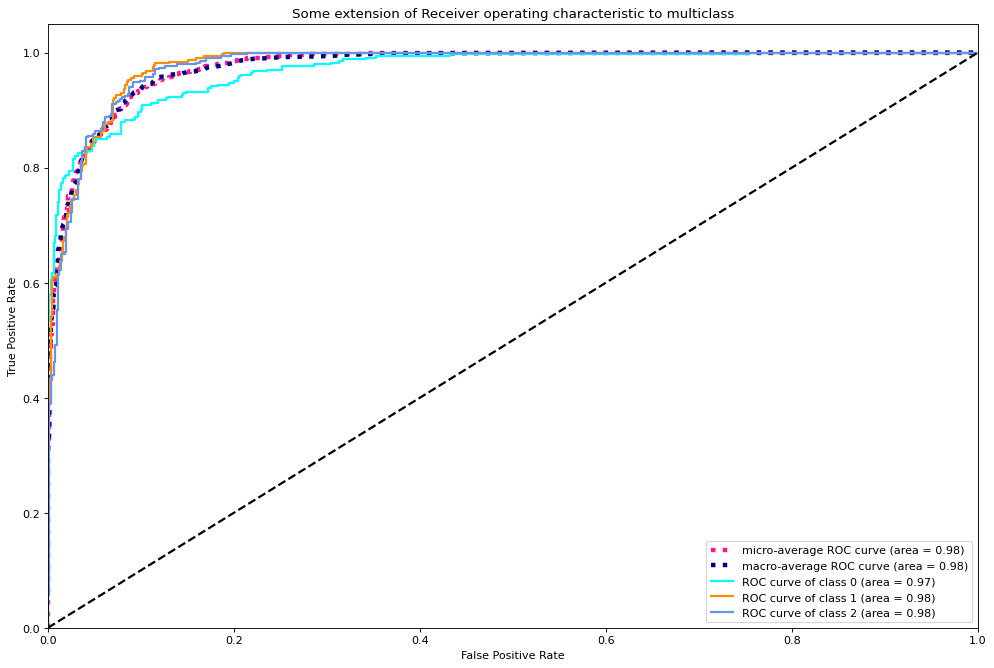

In [70]:
plot_roc_curve(y_test, y_pred_probs_list[0], y_pred_class_list[0], n_classes = n_classes)

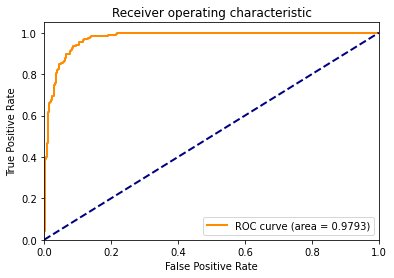

[[[609  52]
  [ 46 293]]

 [[639  46]
  [ 38 277]]

 [[617  37]
  [ 51 295]]]


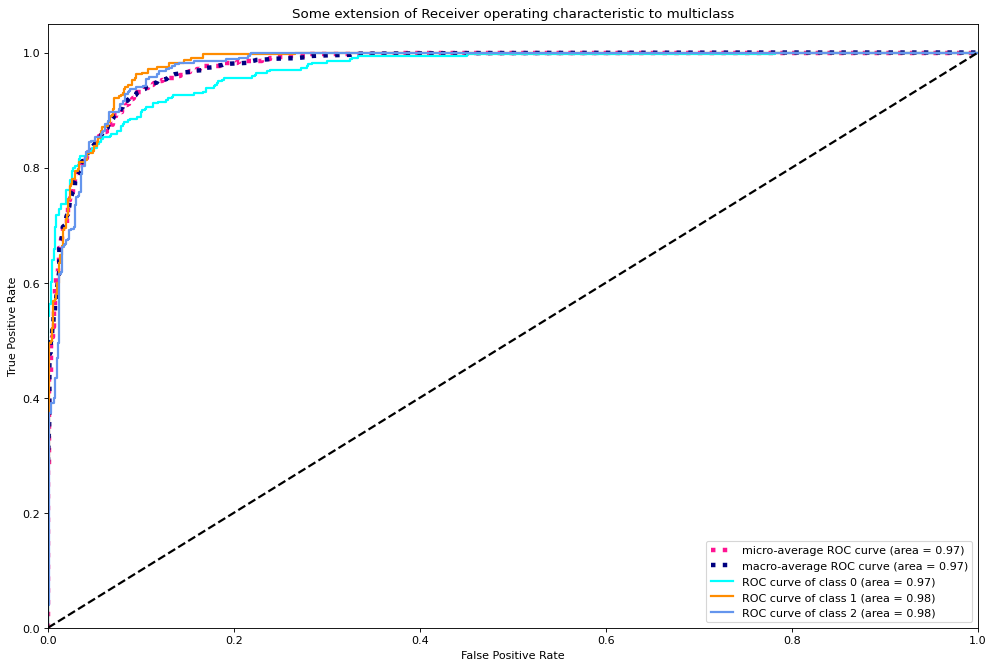

In [71]:
plot_roc_curve(y_test, y_pred_probs_list[1], y_pred_class_list[1], n_classes = n_classes)

### Logistic Regression


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: logistic regression, calibration algo: no calibration


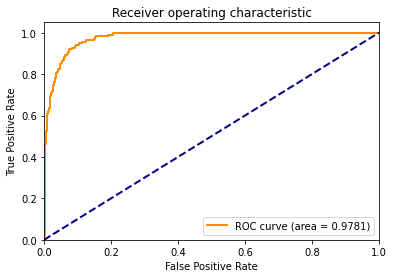

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


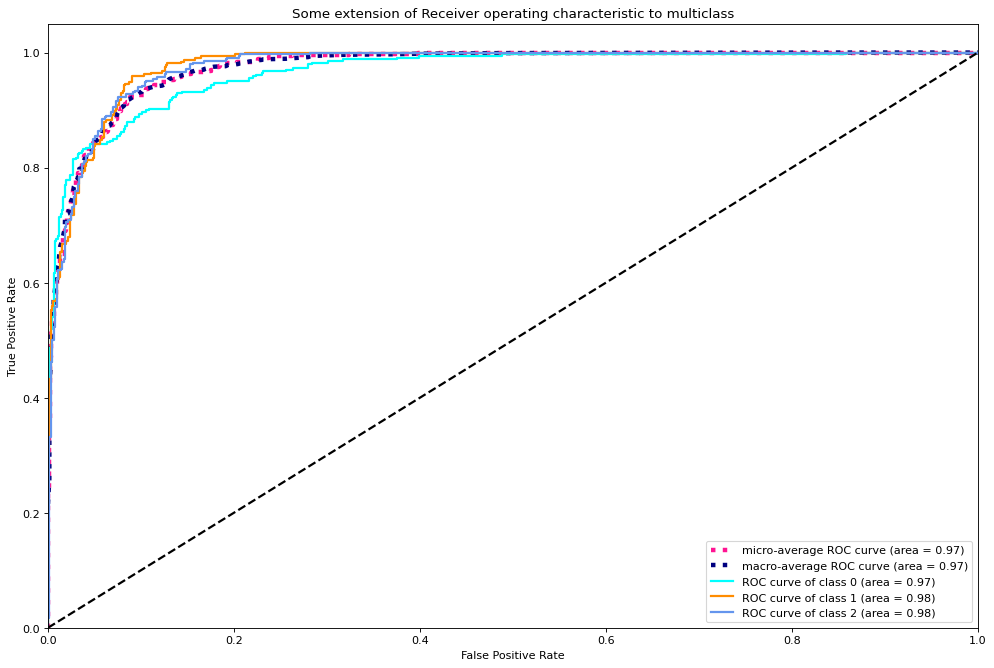

              precision    recall  f1-score   support

           0       0.86      0.85      0.85       339
           1       0.85      0.90      0.87       315
           2       0.90      0.86      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: logistic regression, calibration algo: sigmoid


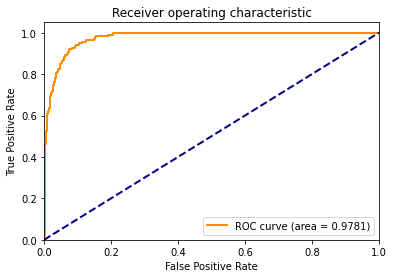

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


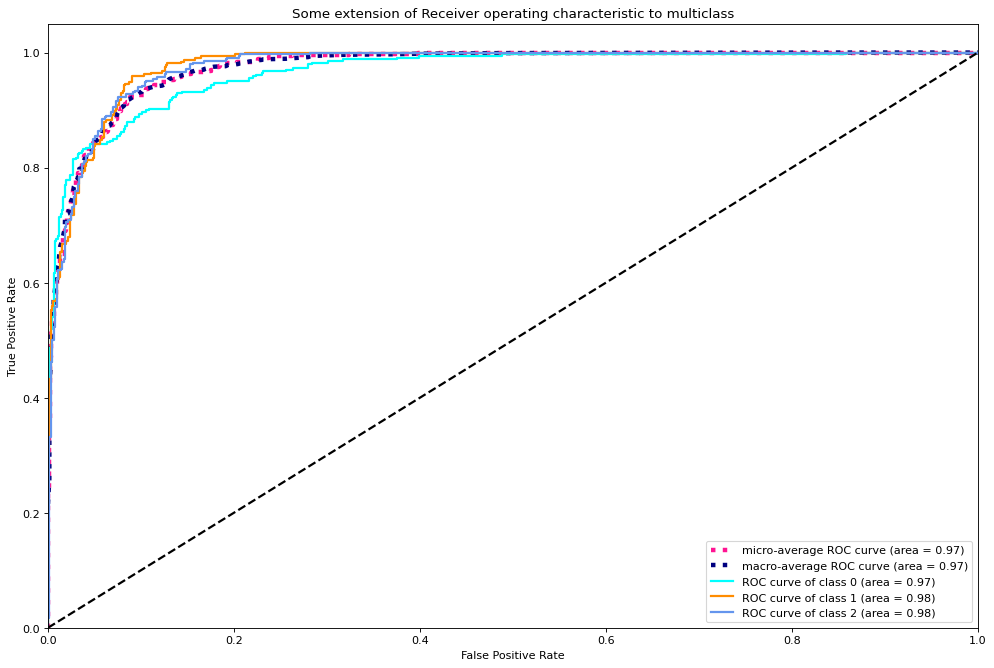

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       339
           1       0.85      0.90      0.87       315
           2       0.89      0.86      0.87       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: logistic regression, calibration algo: isotonic


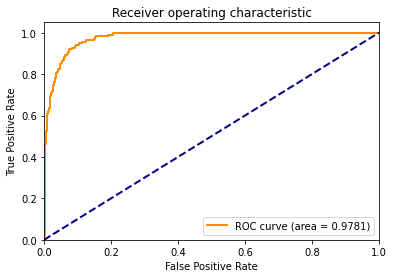

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


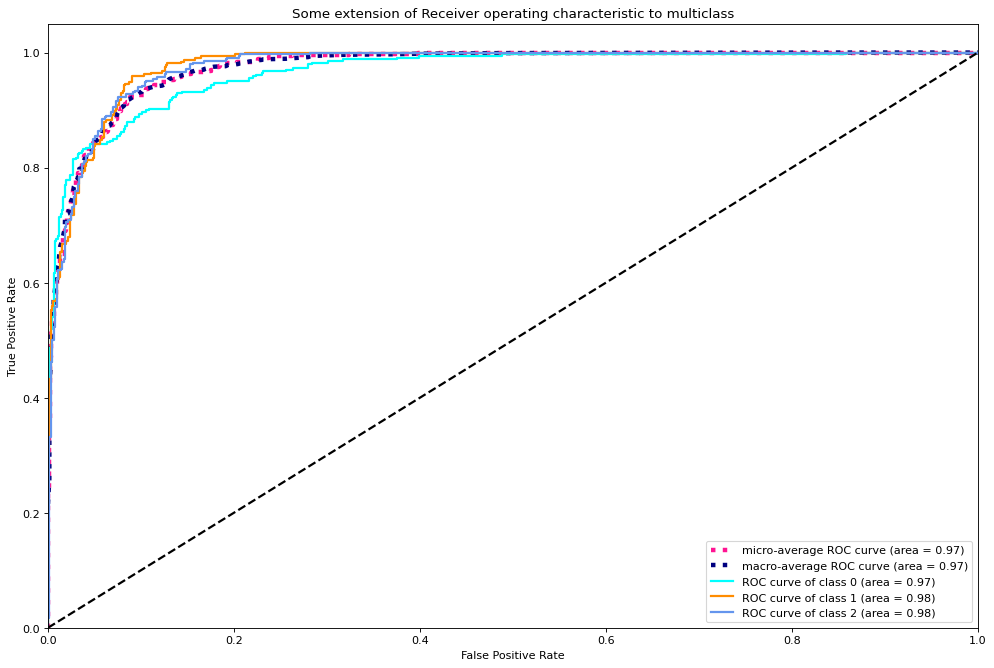

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       339
           1       0.88      0.85      0.86       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: logistic regression, calibration algo: sigmoid cv


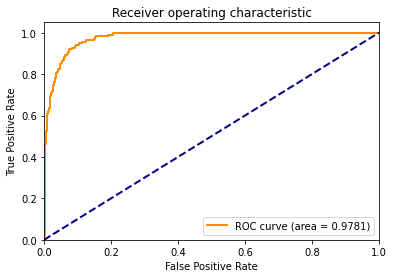

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


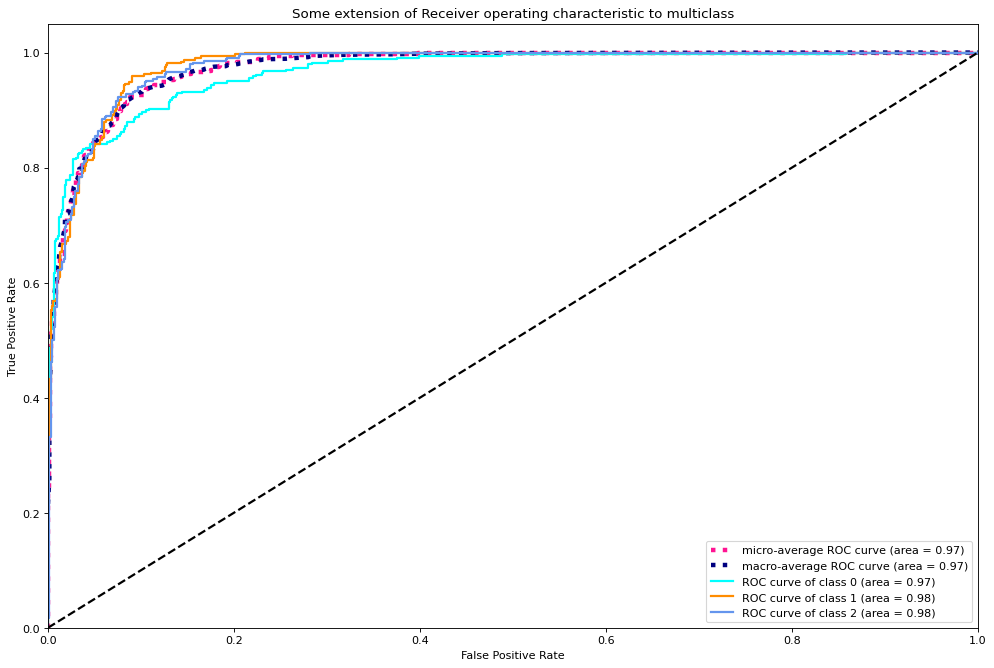

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       339
           1       0.85      0.89      0.87       315
           2       0.89      0.86      0.87       346

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.86      0.87      1000


Model name: logistic regression, calibration algo: isotonic cv


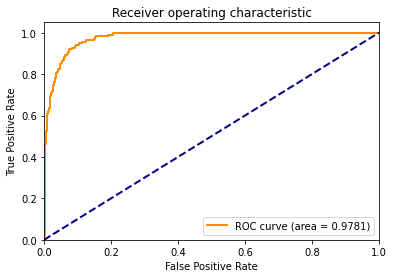

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


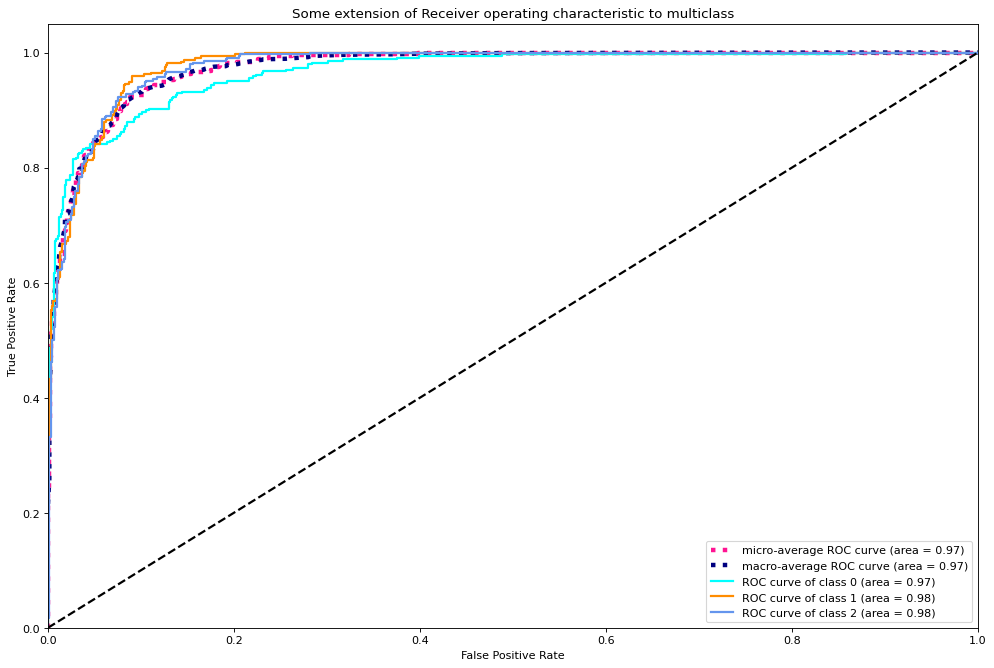

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       339
           1       0.85      0.89      0.87       315
           2       0.89      0.87      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: logistic regression, calibration algo: ivap


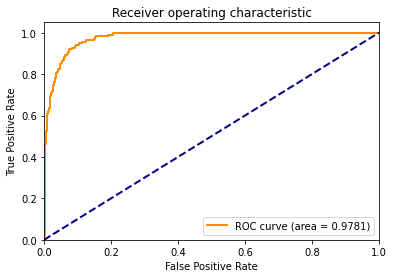

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


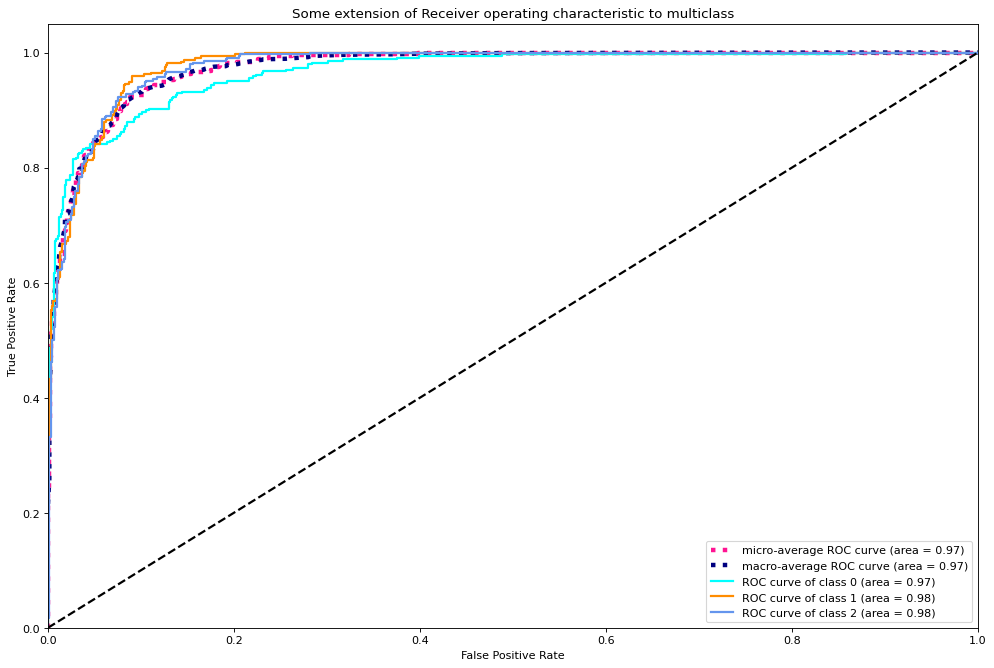

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       339
           1       0.88      0.85      0.87       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: logistic regression, calibration algo: cvap


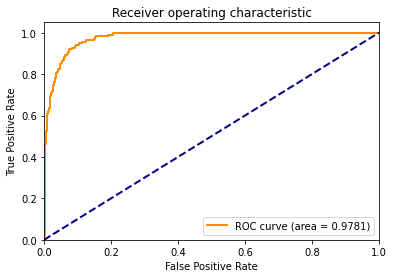

[[[612  49]
  [ 50 289]]

 [[635  50]
  [ 32 283]]

 [[621  33]
  [ 50 296]]]


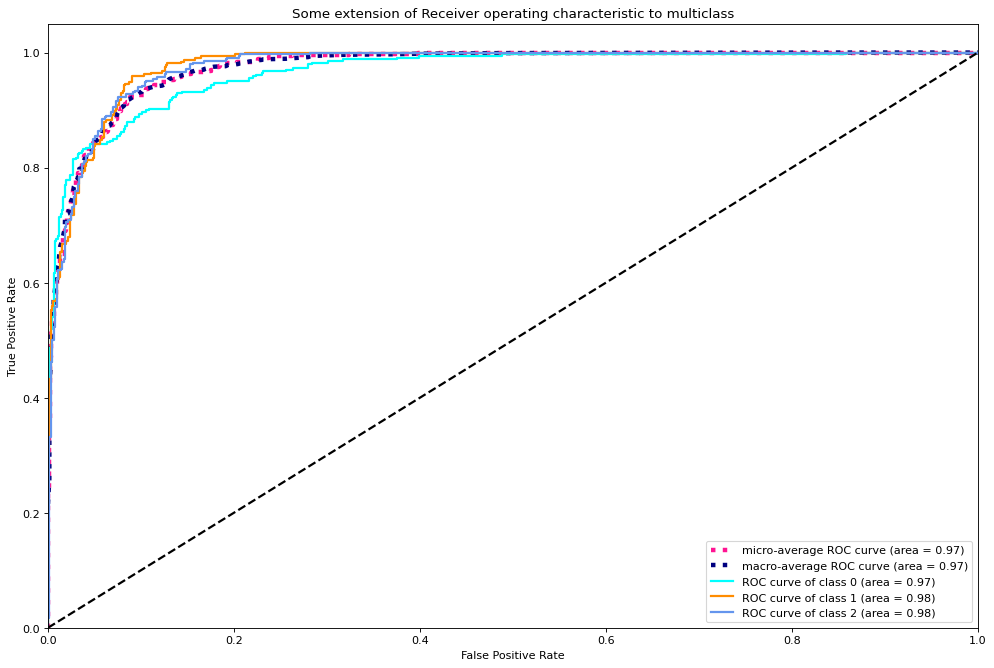

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       339
           1       0.85      0.89      0.87       315
           2       0.88      0.86      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [72]:
# fit base model on the proper training dataset
clf_LR = LogisticRegression(solver = 'liblinear', random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LR, 
                    model_name = 'logistic regression')

In [73]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [74]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression           0.060485  0.060969  0.061617    0.060253   
neural network                     NaN       NaN       NaN         NaN   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression        0.060417  0.061699  0.060987  
neural network                  NaN       NaN       NaN  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Neural Network


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: neural network, calibration algo: no calibration


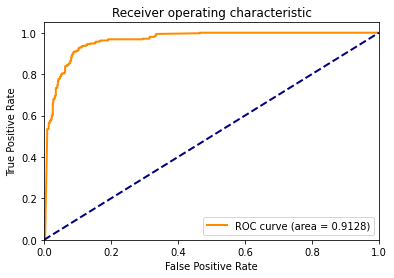

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


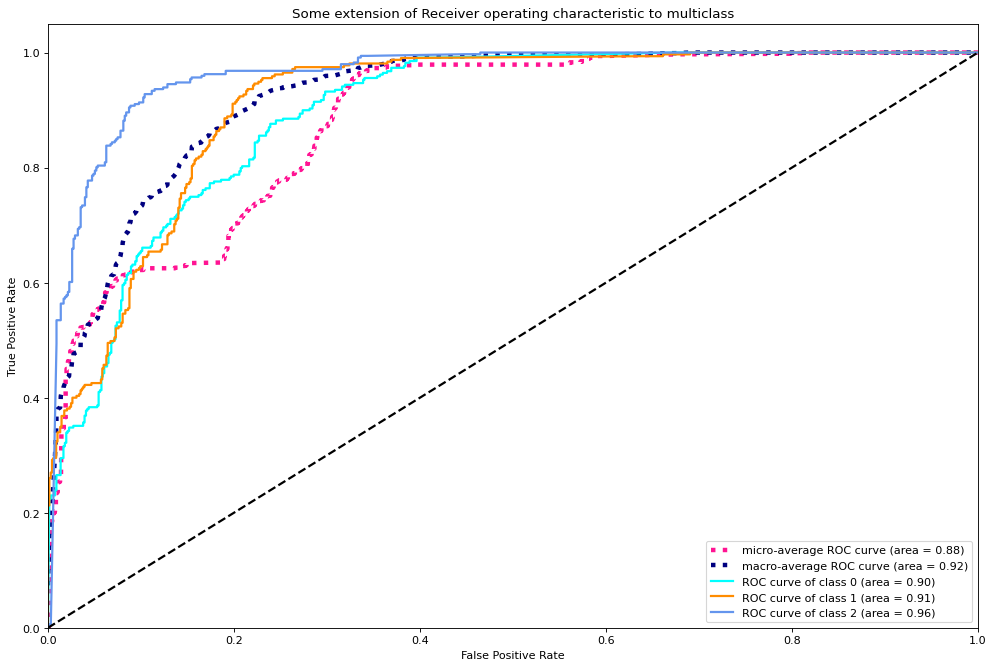

              precision    recall  f1-score   support

           0       0.60      0.91      0.73       339
           1       0.83      0.43      0.56       315
           2       0.88      0.83      0.85       346

    accuracy                           0.73      1000
   macro avg       0.77      0.72      0.71      1000
weighted avg       0.77      0.73      0.72      1000


Model name: neural network, calibration algo: sigmoid


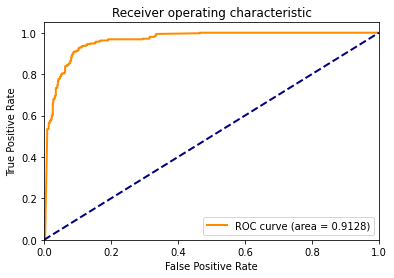

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


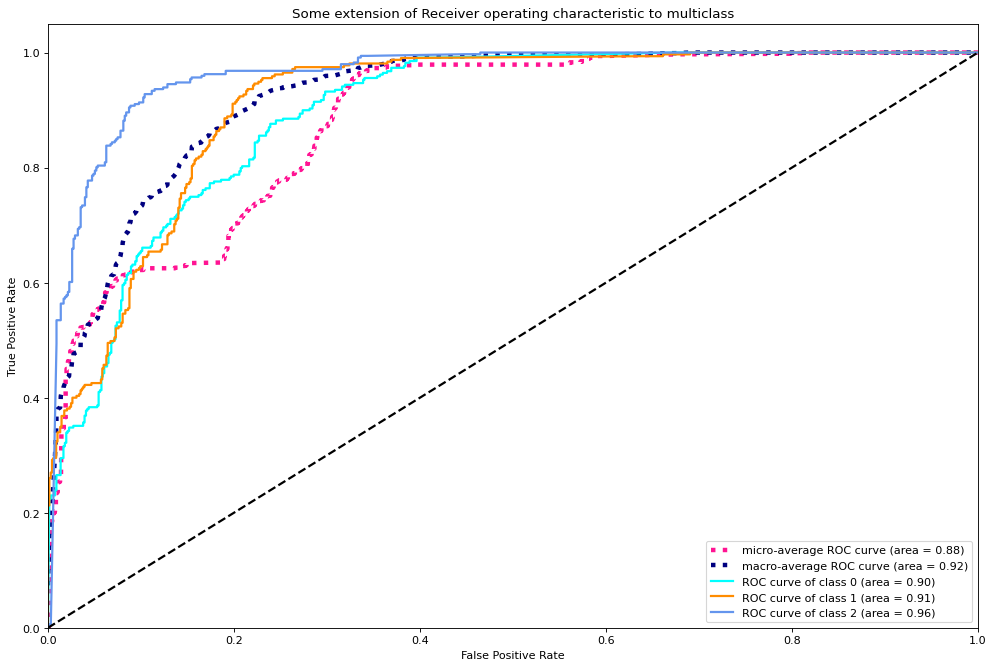

              precision    recall  f1-score   support

           0       0.59      0.90      0.71       339
           1       0.80      0.37      0.51       315
           2       0.86      0.83      0.84       346

    accuracy                           0.71      1000
   macro avg       0.75      0.70      0.69      1000
weighted avg       0.75      0.71      0.69      1000


Model name: neural network, calibration algo: isotonic


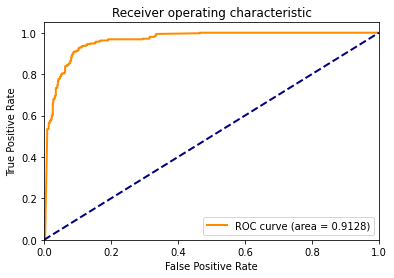

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


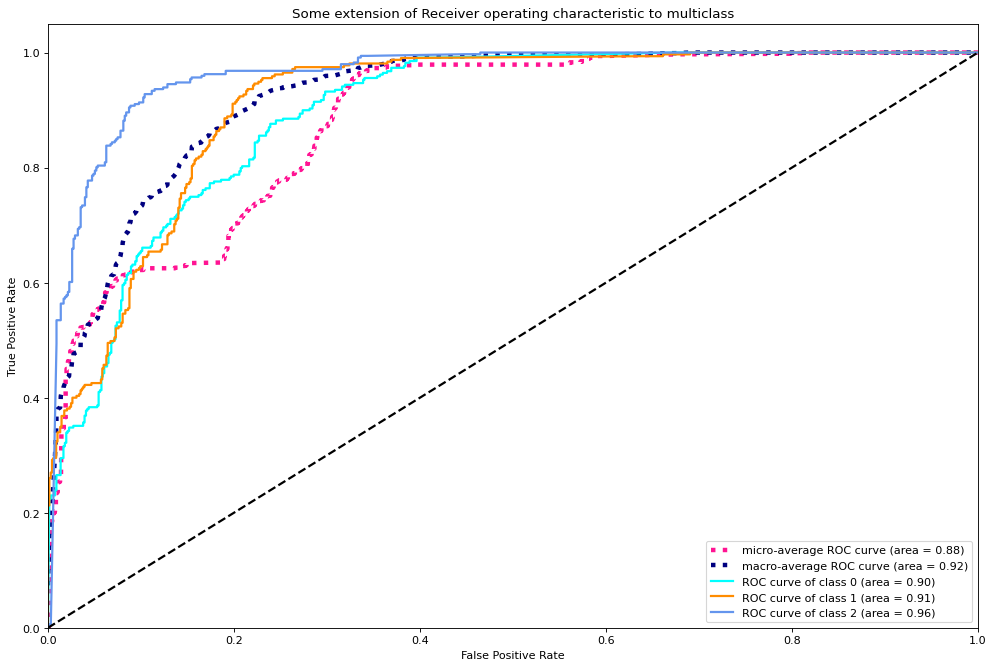

              precision    recall  f1-score   support

           0       0.61      0.90      0.73       339
           1       0.90      0.40      0.55       315
           2       0.84      0.89      0.86       346

    accuracy                           0.74      1000
   macro avg       0.79      0.73      0.72      1000
weighted avg       0.78      0.74      0.72      1000


Model name: neural network, calibration algo: sigmoid cv


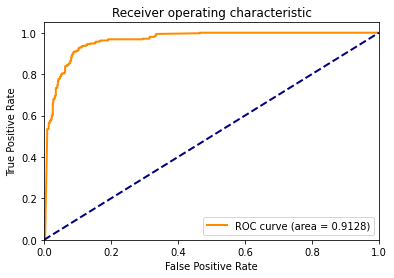

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


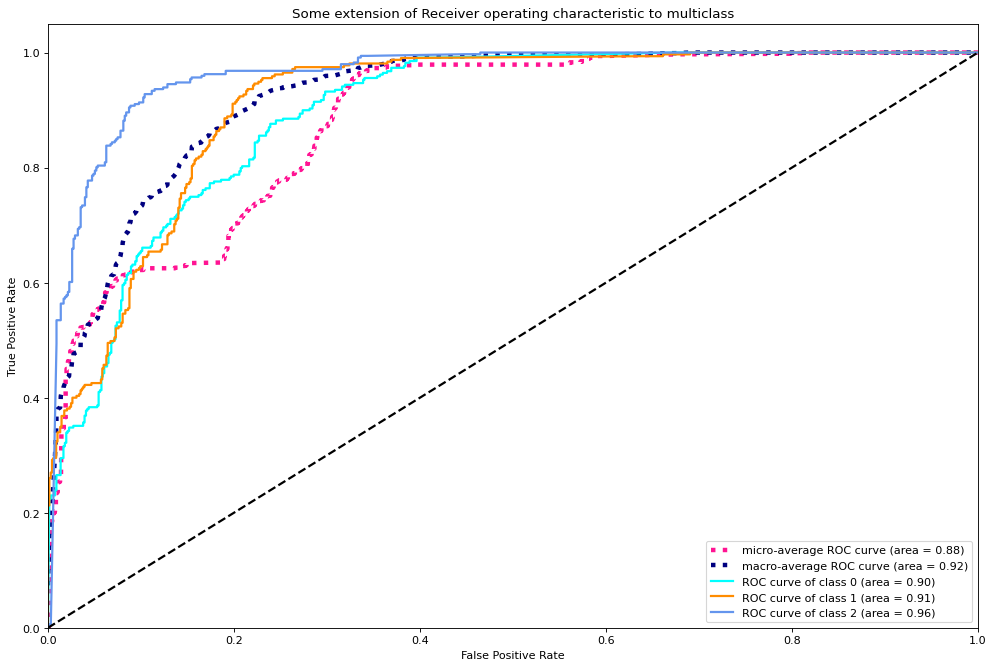

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       339
           1       0.87      0.53      0.66       315
           2       0.87      0.85      0.86       346

    accuracy                           0.77      1000
   macro avg       0.80      0.76      0.76      1000
weighted avg       0.80      0.77      0.76      1000


Model name: neural network, calibration algo: isotonic cv


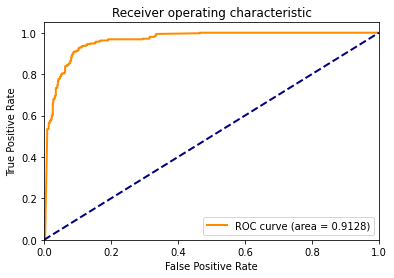

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


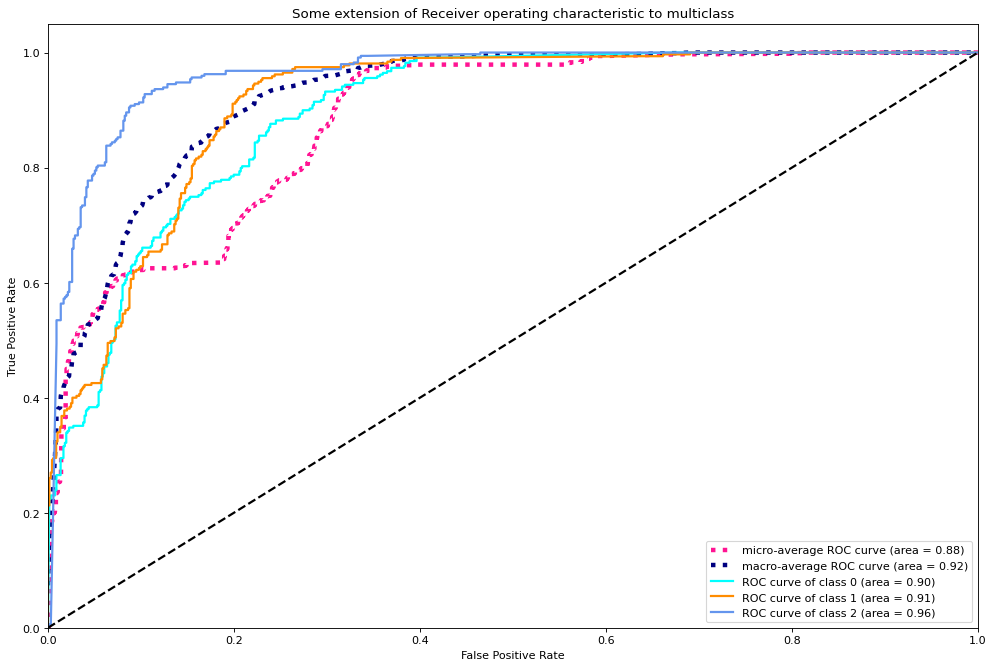

              precision    recall  f1-score   support

           0       0.67      0.92      0.77       339
           1       0.88      0.54      0.67       315
           2       0.88      0.86      0.87       346

    accuracy                           0.78      1000
   macro avg       0.81      0.77      0.77      1000
weighted avg       0.81      0.78      0.77      1000


Model name: neural network, calibration algo: ivap


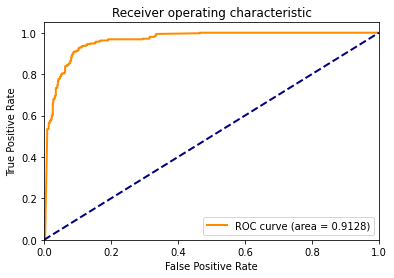

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


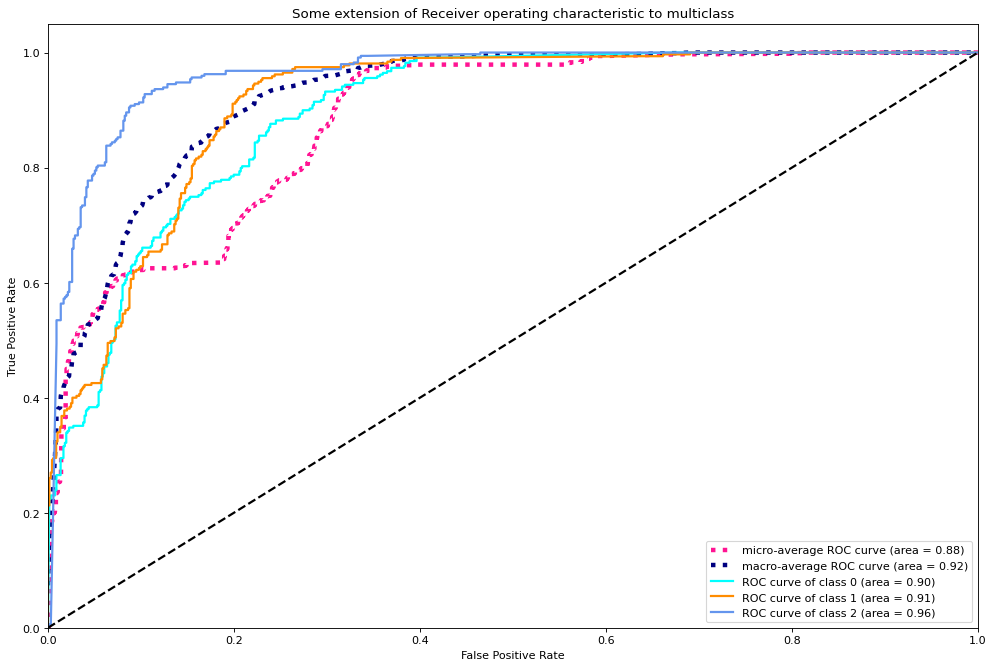

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       339
           1       0.69      0.93      0.79       315
           2       0.90      0.73      0.80       346

    accuracy                           0.76      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.78      0.76      0.76      1000


Model name: neural network, calibration algo: cvap


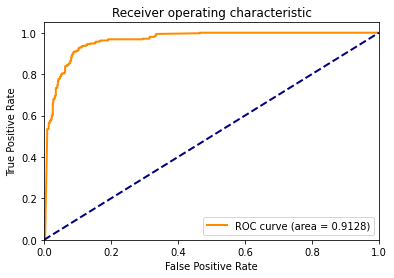

[[[459 202]
  [ 31 308]]

 [[657  28]
  [181 134]]

 [[613  41]
  [ 59 287]]]


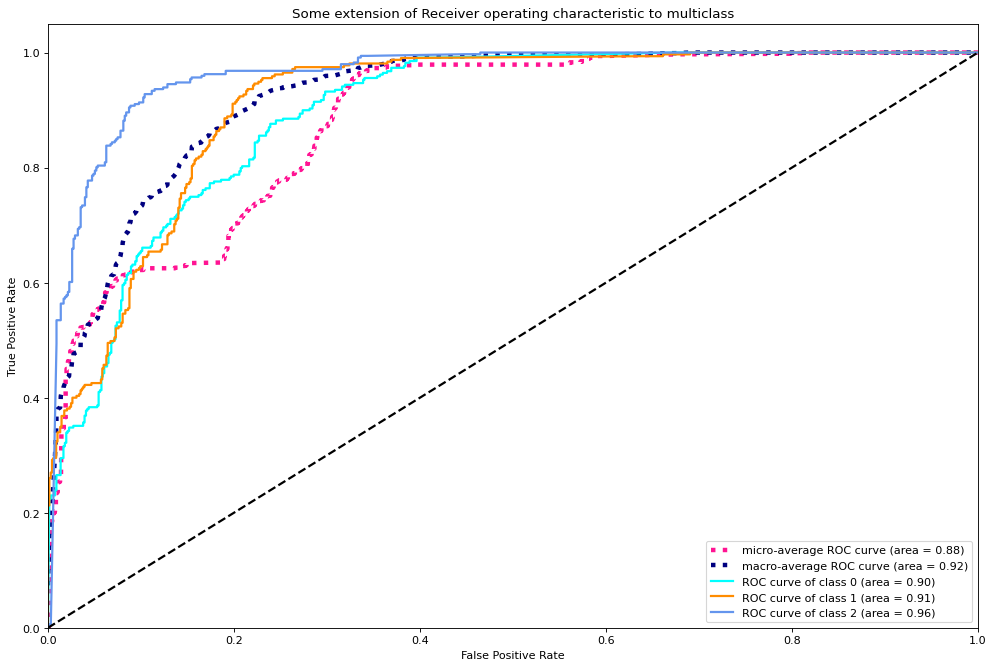

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       339
           1       0.65      0.97      0.78       315
           2       0.92      0.73      0.81       346

    accuracy                           0.75      1000
   macro avg       0.77      0.75      0.74      1000
weighted avg       0.78      0.75      0.74      1000



In [75]:
# fit base model on the proper training dataset
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_MLP, 
                    model_name = 'neural network')

In [76]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                0.415297  0.446941  0.436216    0.426556   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network             0.411199  0.529545  0.517037  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [77]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression           0.060485  0.060969  0.061617    0.060253   
neural network                0.132605  0.143581  0.140673    0.135628   
Random Forest                      NaN       NaN       NaN         NaN   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression        0.060417  0.061699  0.060987  
neural network             0.132511  0.175882  0.169513  
Random Forest                   NaN       NaN       NaN  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### Random Forest


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: Random Forest, calibration algo: no calibration


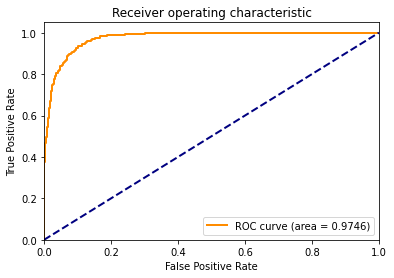

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


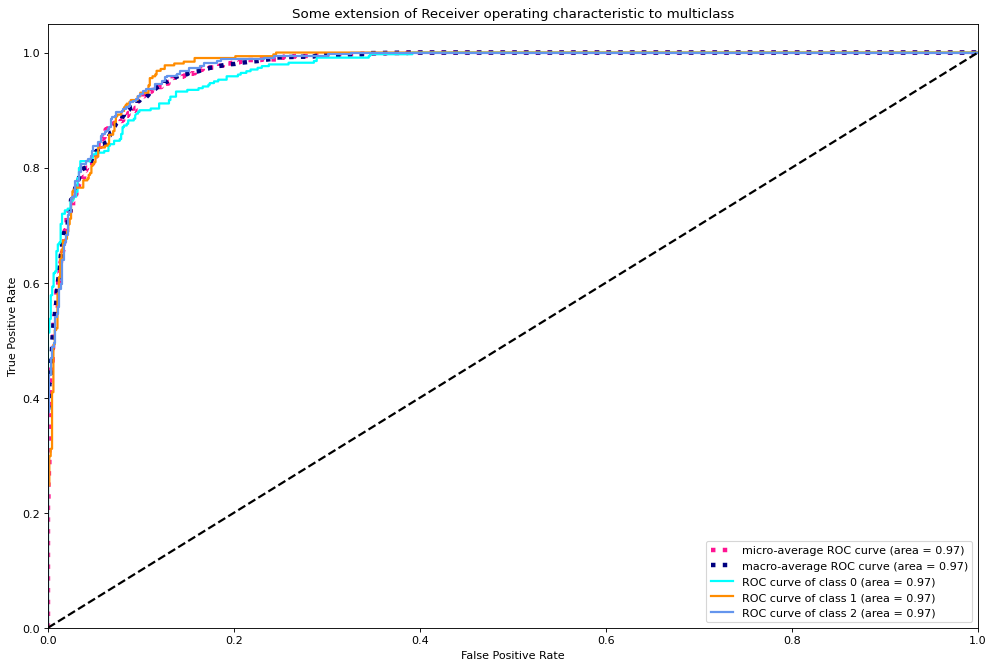

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       339
           1       0.83      0.91      0.87       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Random Forest, calibration algo: sigmoid


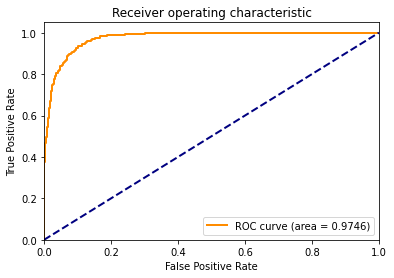

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


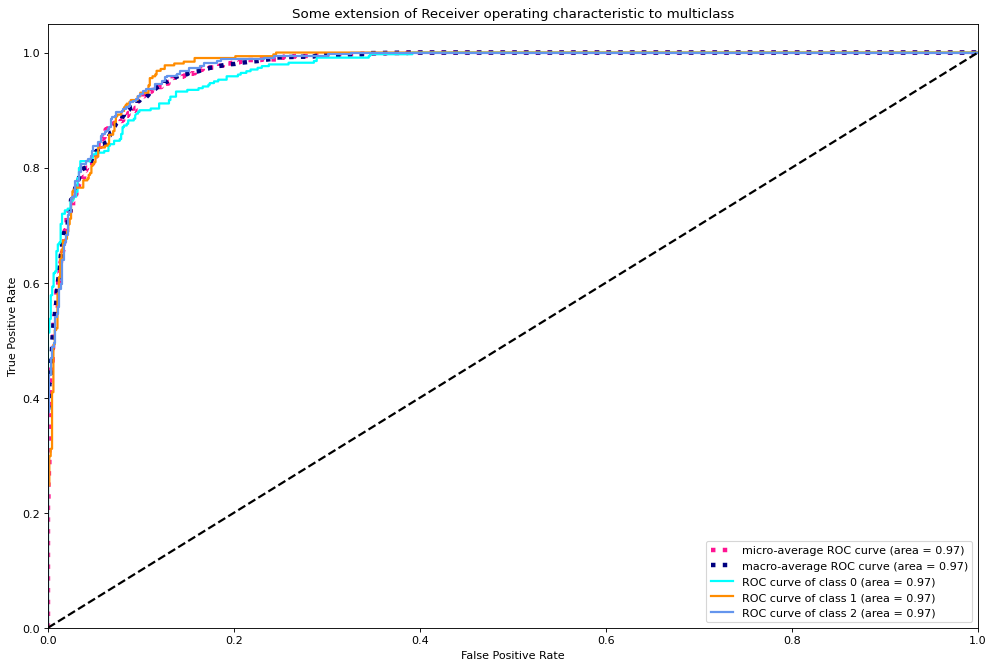

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       339
           1       0.86      0.88      0.87       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Random Forest, calibration algo: isotonic


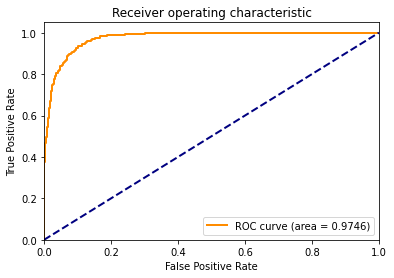

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


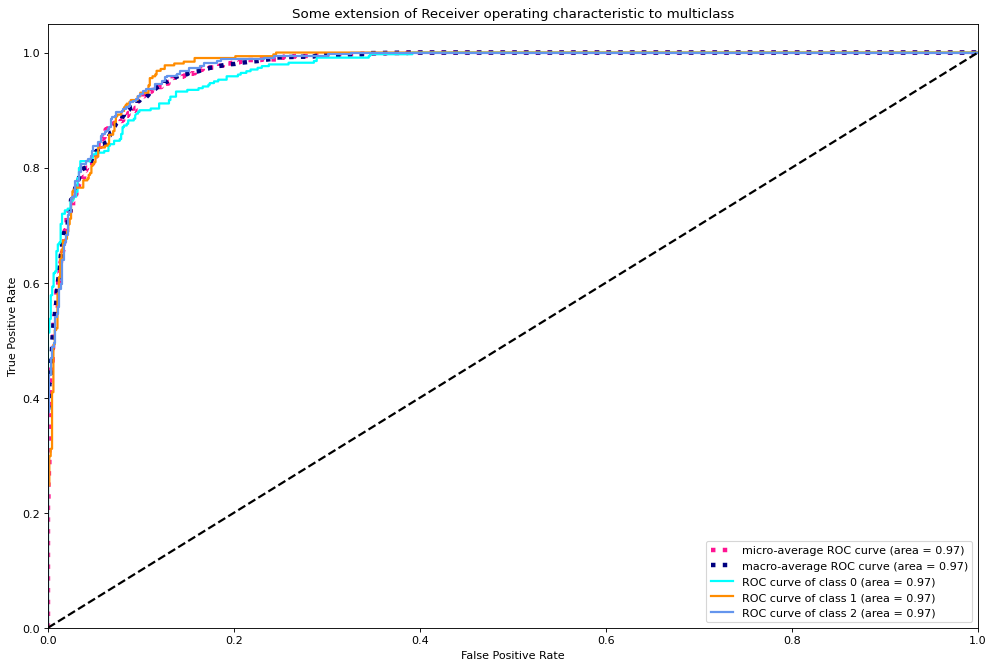

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       339
           1       0.88      0.86      0.87       315
           2       0.86      0.92      0.89       346

    accuracy                           0.88      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.88      0.87      1000


Model name: Random Forest, calibration algo: sigmoid cv


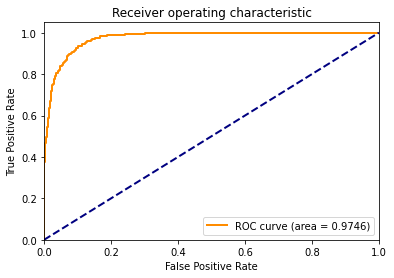

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


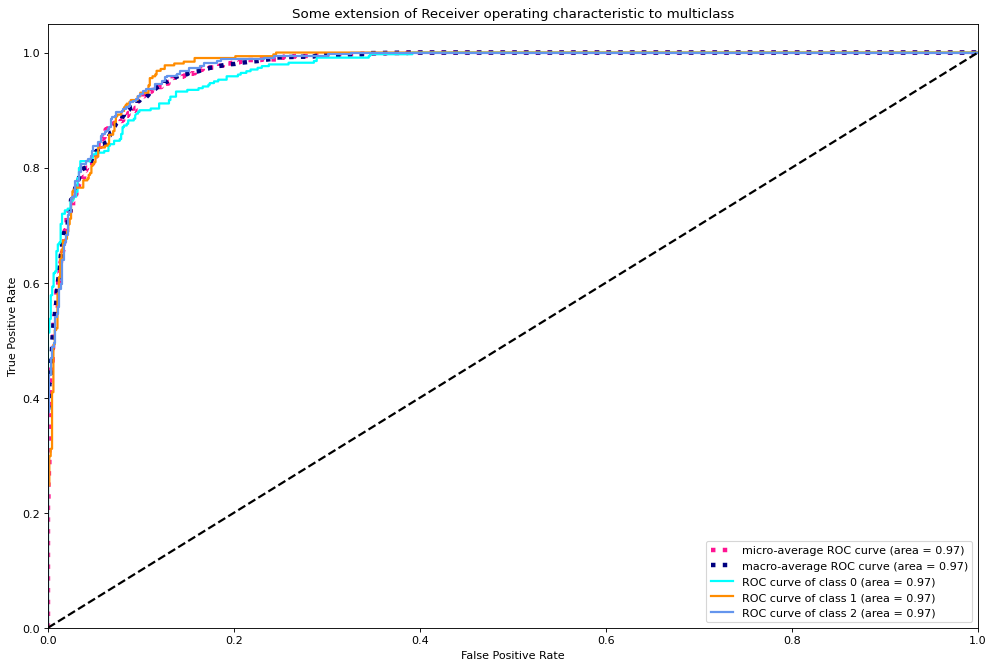

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       339
           1       0.85      0.87      0.86       315
           2       0.87      0.88      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: Random Forest, calibration algo: isotonic cv


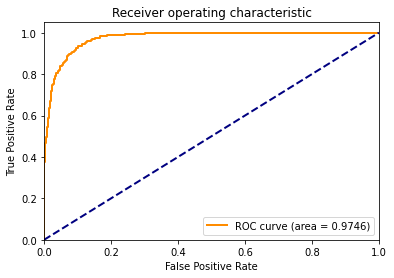

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


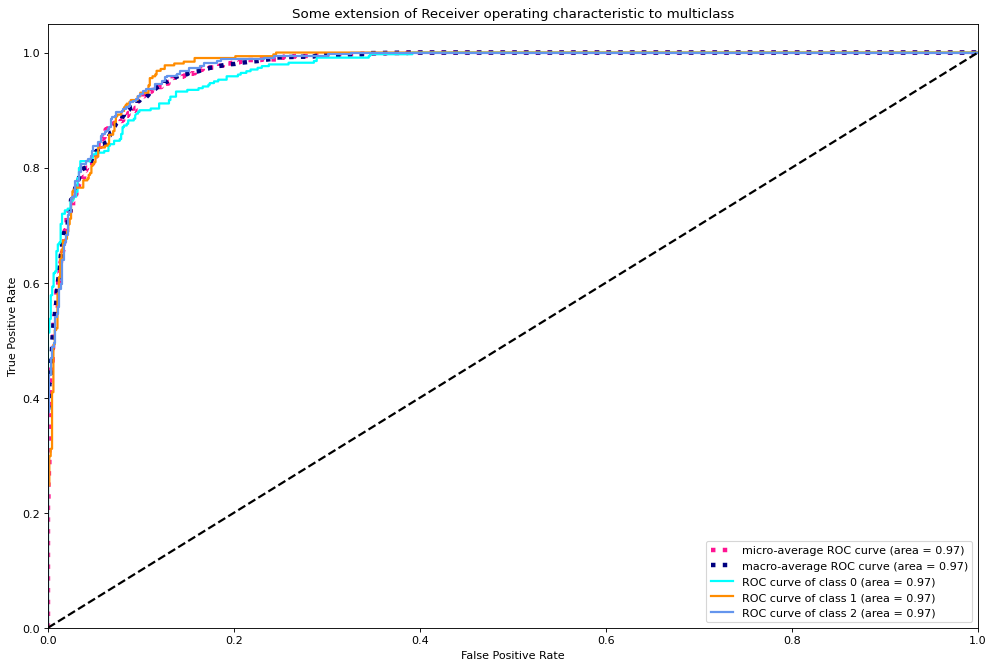

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       339
           1       0.85      0.87      0.86       315
           2       0.86      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Random Forest, calibration algo: ivap


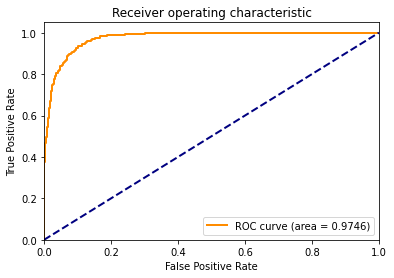

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


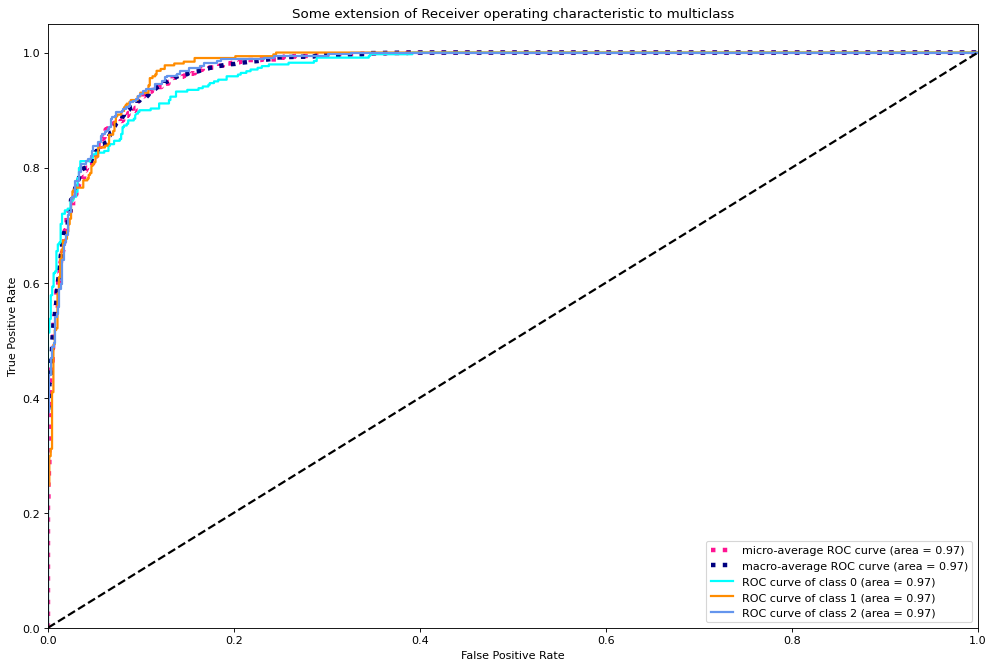

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       339
           1       0.88      0.86      0.87       315
           2       0.85      0.92      0.89       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: Random Forest, calibration algo: cvap


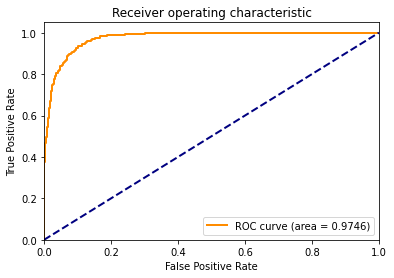

[[[636  25]
  [ 64 275]]

 [[628  57]
  [ 29 286]]

 [[606  48]
  [ 37 309]]]


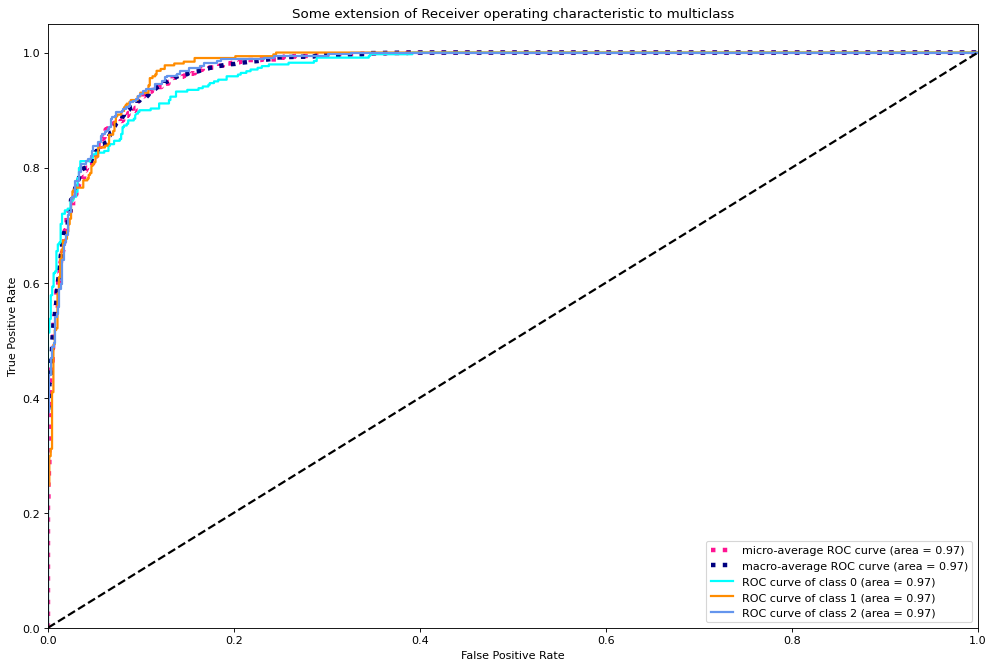

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       339
           1       0.85      0.88      0.87       315
           2       0.86      0.90      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [78]:
clf_RF = RandomForestClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_RF, 
                    model_name = 'Random Forest')

In [79]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                0.415297  0.446941  0.436216    0.426556   
Random Forest                 0.248640  0.199392  0.198114    0.196041   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network             0.411199  0.529545  0.517037  
Random Forest              0.211348  0.206754  0.205550  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [80]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression           0.060485  0.060969  0.061617    0.060253   
neural network                0.132605  0.143581  0.140673    0.135628   
Random Forest                 0.073655  0.062403  0.061811    0.060863   
LightGBM                           NaN       NaN       NaN         NaN   
XGBoost                            NaN       NaN       NaN         NaN   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression        0.060417  0.061699  0.060987  
neural network             0.132511  0.175882  0.169513  
Random Forest              0.060742  0.063147  0.062204  
LightGBM                        NaN       NaN       NaN  
XGBoost                         NaN       NaN       NaN  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### LightGBM 


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: LightGBM, calibration algo: no calibration


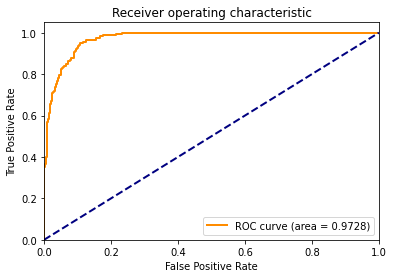

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


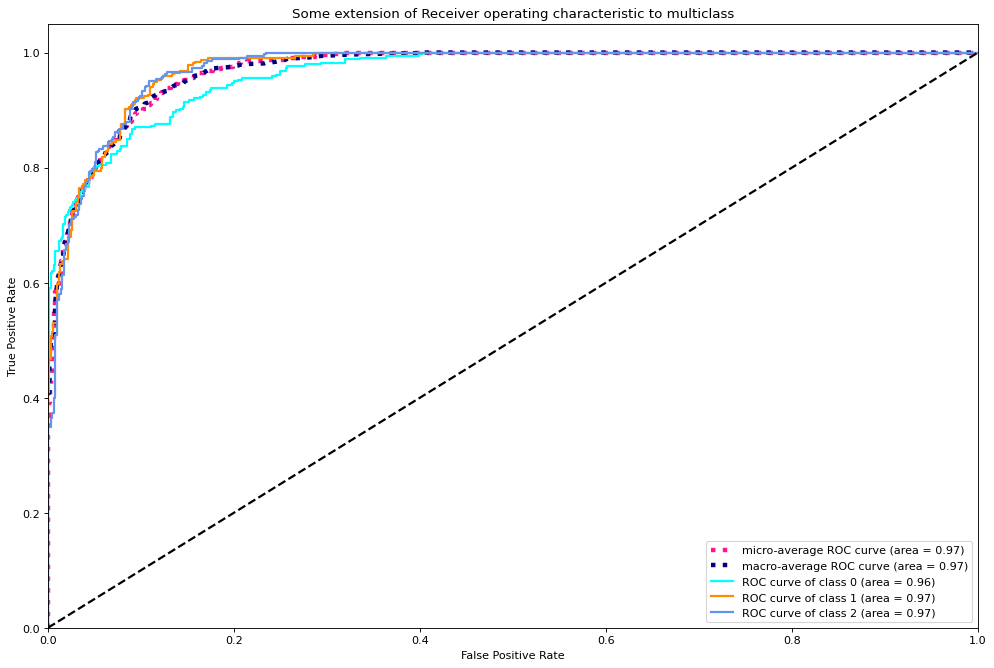

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       339
           1       0.83      0.89      0.86       315
           2       0.86      0.86      0.86       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: LightGBM, calibration algo: sigmoid


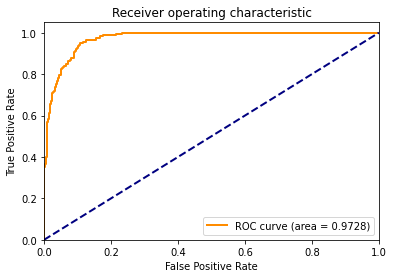

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


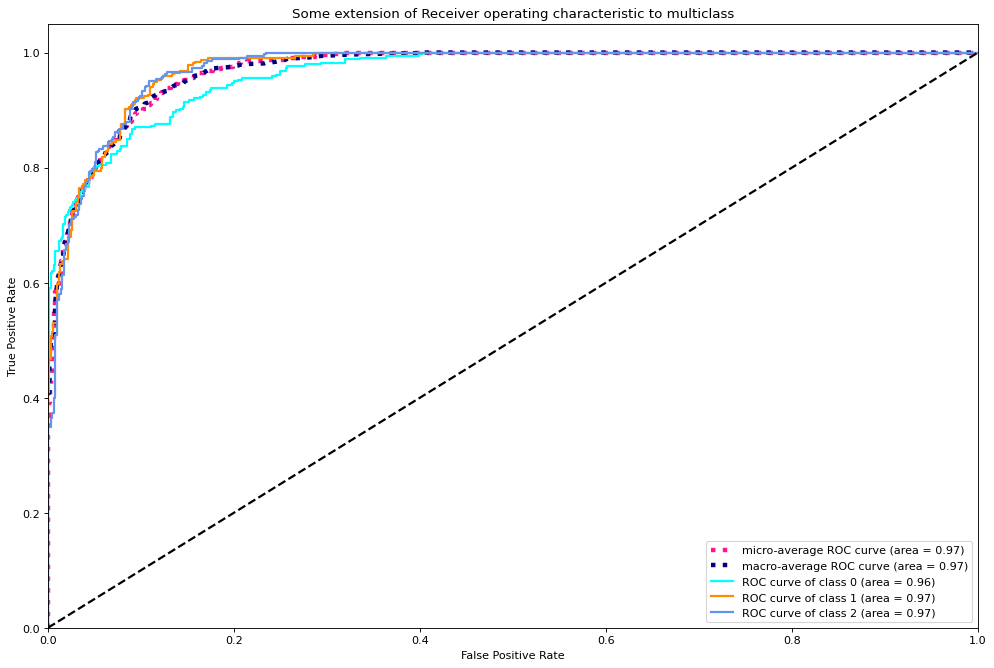

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       339
           1       0.82      0.88      0.85       315
           2       0.88      0.87      0.87       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: LightGBM, calibration algo: isotonic


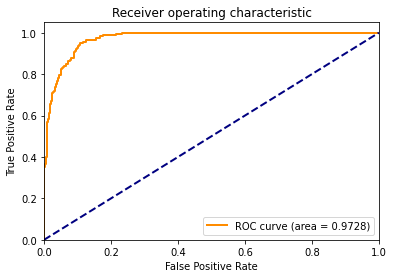

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


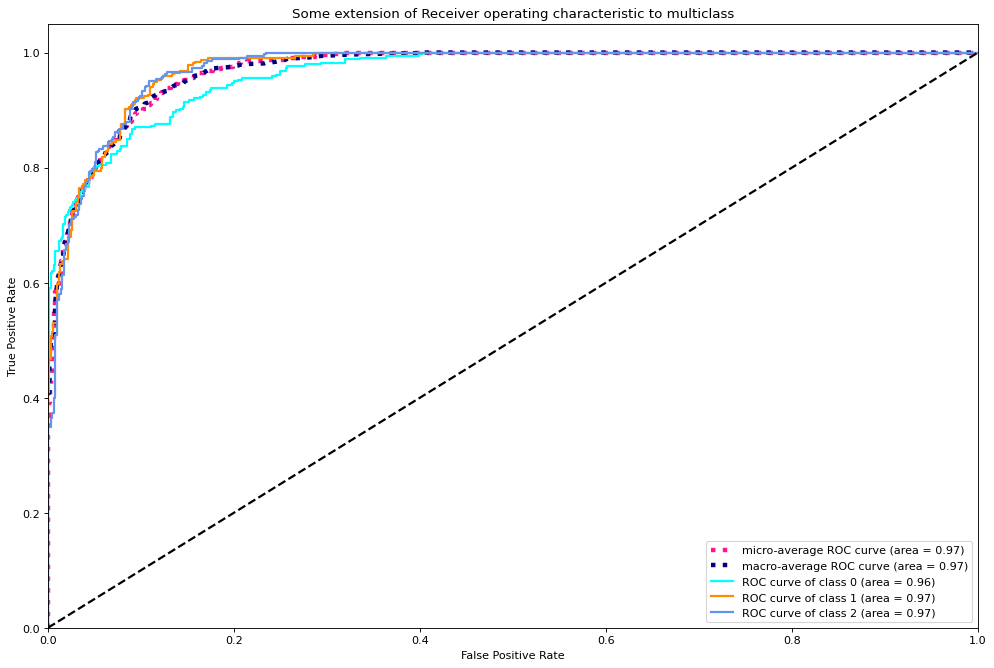

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       339
           1       0.83      0.86      0.85       315
           2       0.85      0.90      0.88       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: LightGBM, calibration algo: sigmoid cv


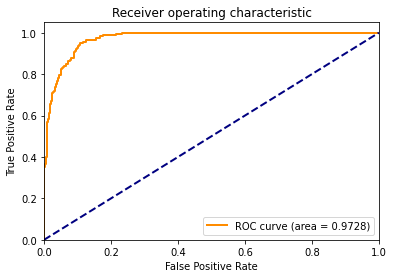

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


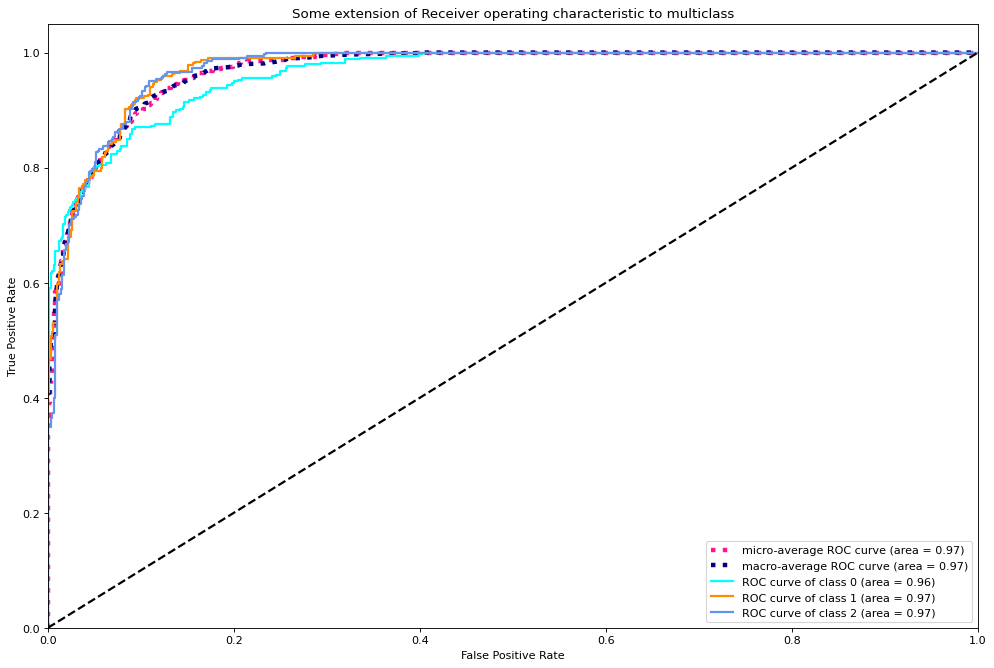

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       339
           1       0.83      0.89      0.86       315
           2       0.86      0.87      0.86       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: LightGBM, calibration algo: isotonic cv


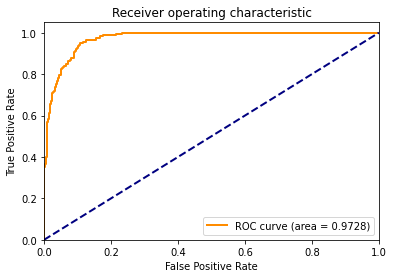

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


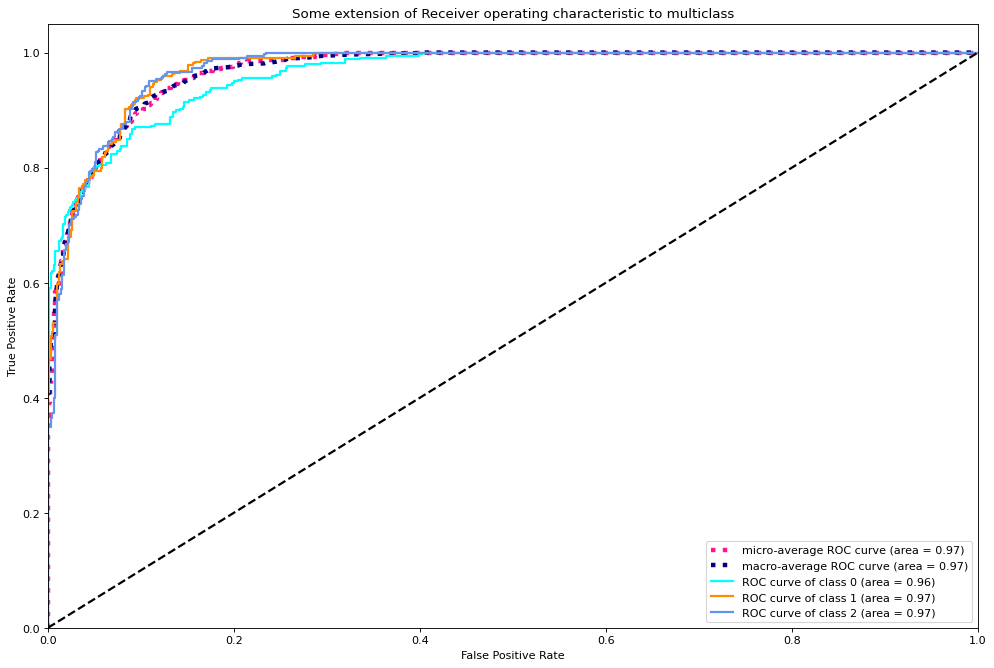

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       339
           1       0.85      0.87      0.86       315
           2       0.85      0.88      0.86       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: LightGBM, calibration algo: ivap


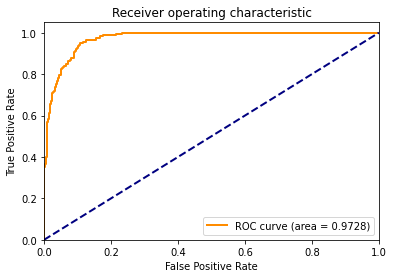

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


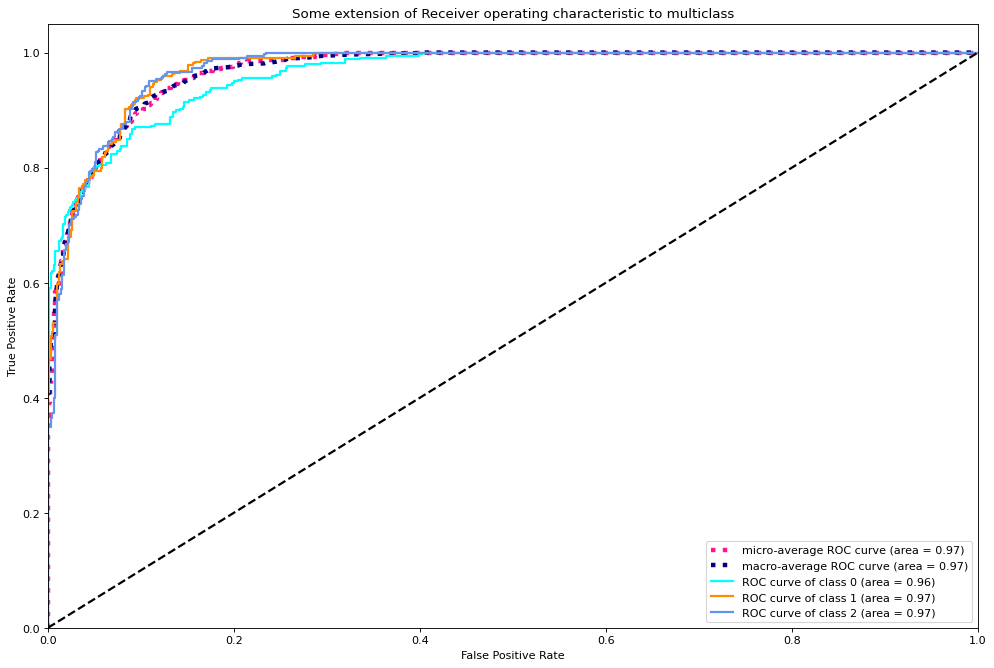

              precision    recall  f1-score   support

           0       0.88      0.79      0.84       339
           1       0.83      0.87      0.85       315
           2       0.85      0.90      0.88       346

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.85      1000
weighted avg       0.86      0.85      0.85      1000


Model name: LightGBM, calibration algo: cvap


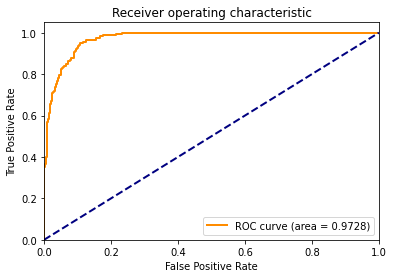

[[[621  40]
  [ 66 273]]

 [[628  57]
  [ 34 281]]

 [[604  50]
  [ 47 299]]]


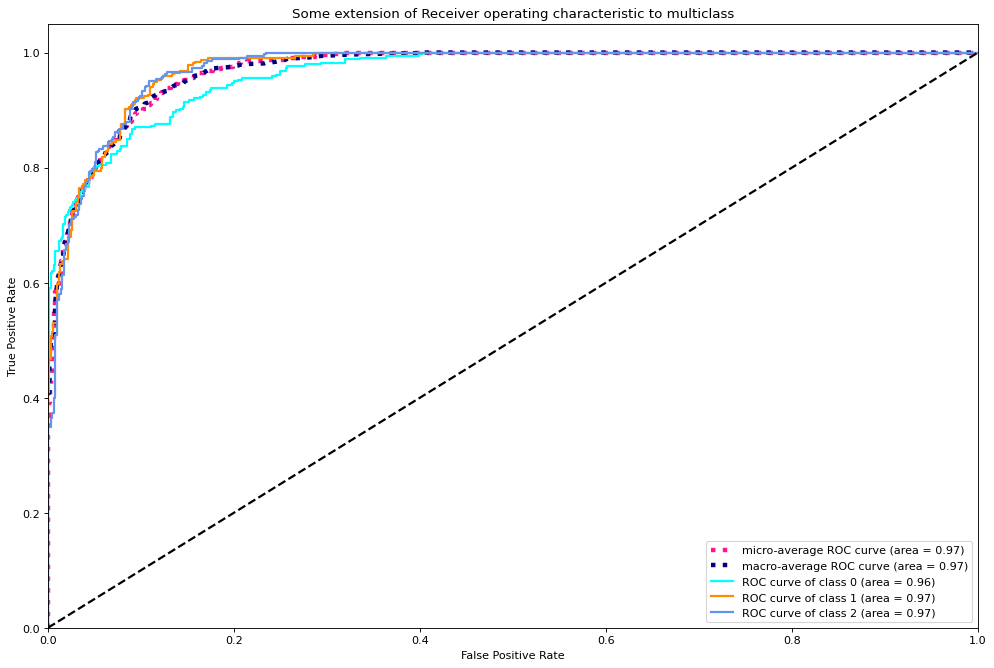

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       339
           1       0.84      0.88      0.86       315
           2       0.85      0.88      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [81]:
clf_LGBMC = LGBMClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_LGBMC, 
                    model_name = 'LightGBM')



### XGBoost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: XGBoost, calibration algo: no calibration


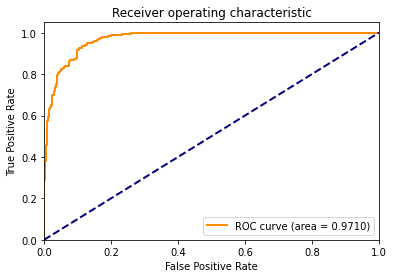

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


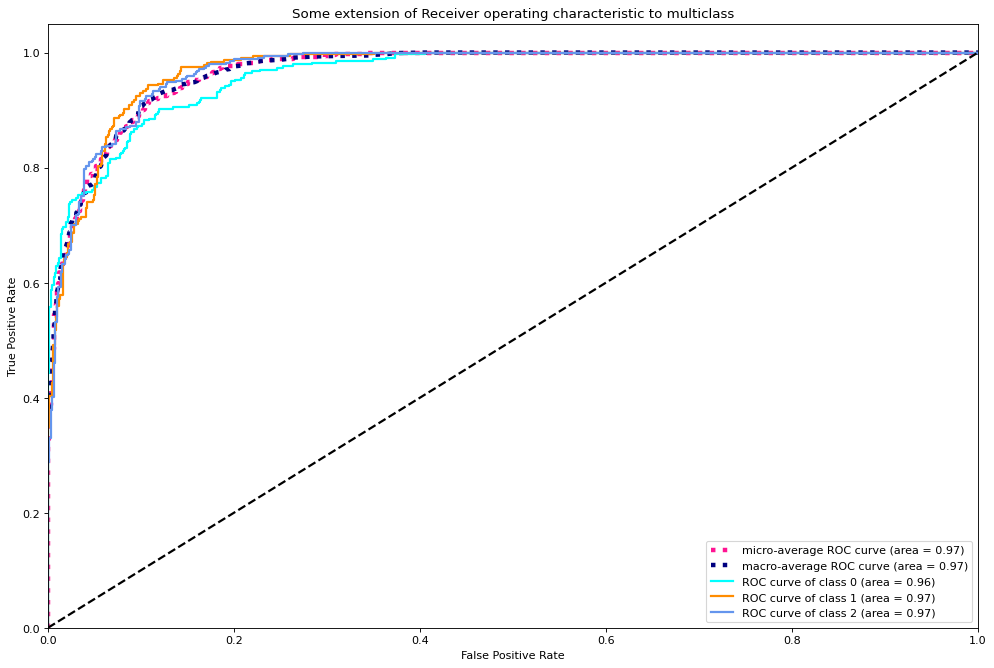

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       339
           1       0.84      0.89      0.87       315
           2       0.86      0.85      0.86       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: XGBoost, calibration algo: sigmoid


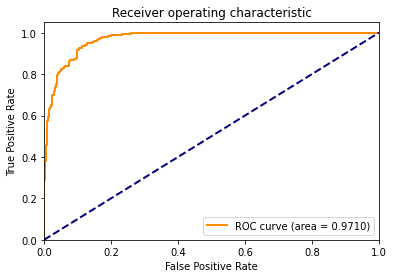

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


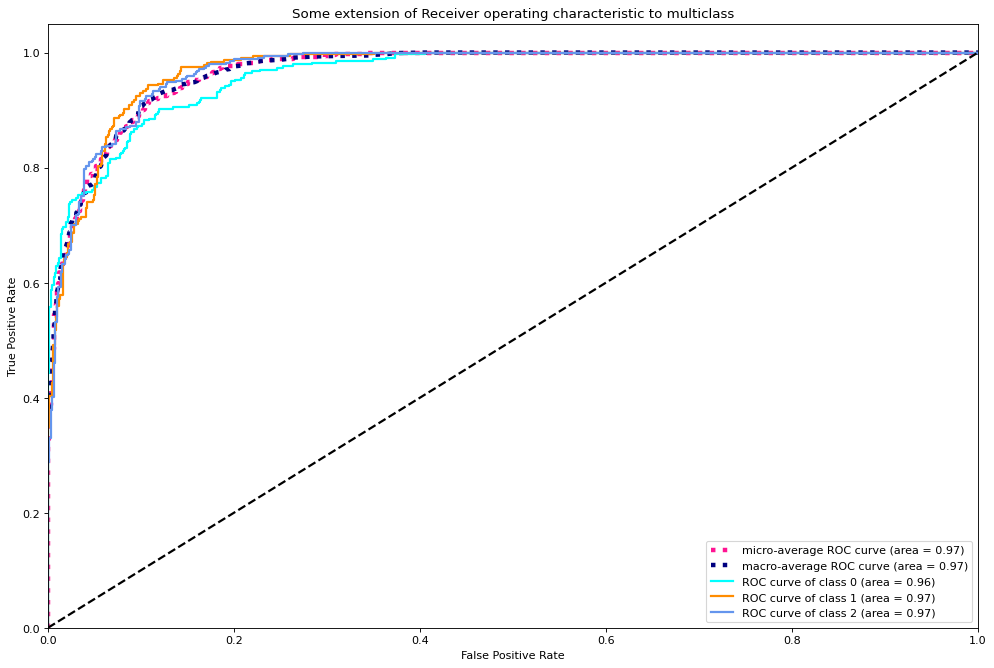

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       339
           1       0.85      0.87      0.86       315
           2       0.87      0.87      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: XGBoost, calibration algo: isotonic


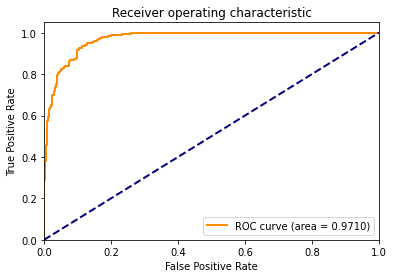

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


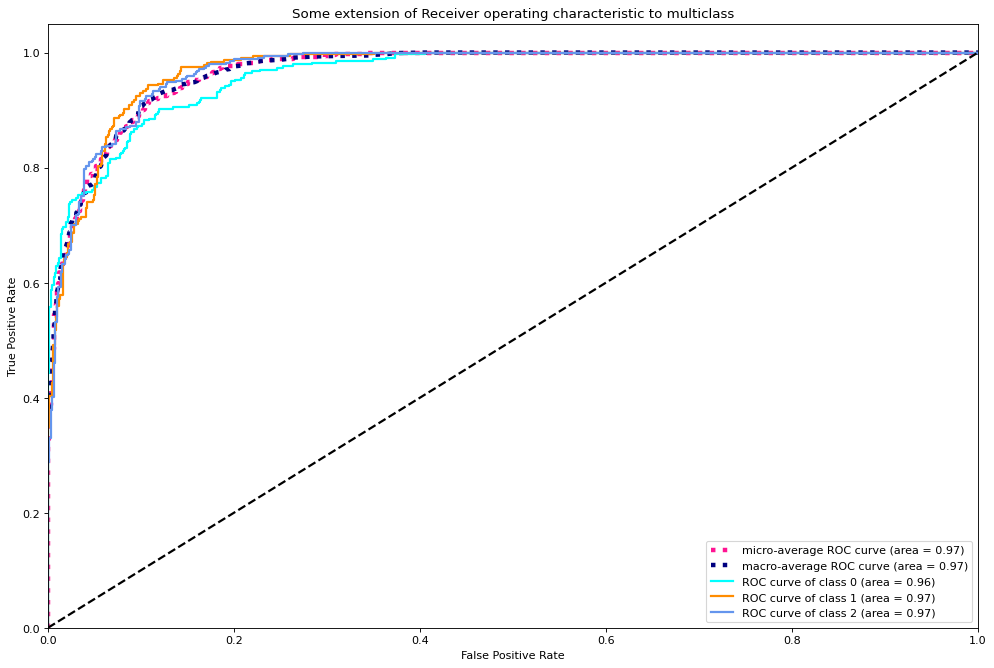

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       339
           1       0.86      0.84      0.85       315
           2       0.86      0.89      0.87       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: XGBoost, calibration algo: sigmoid cv


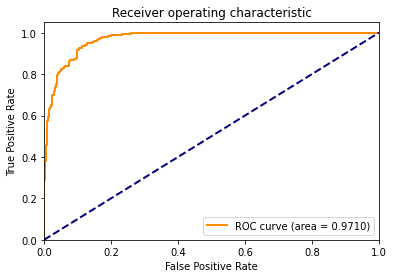

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


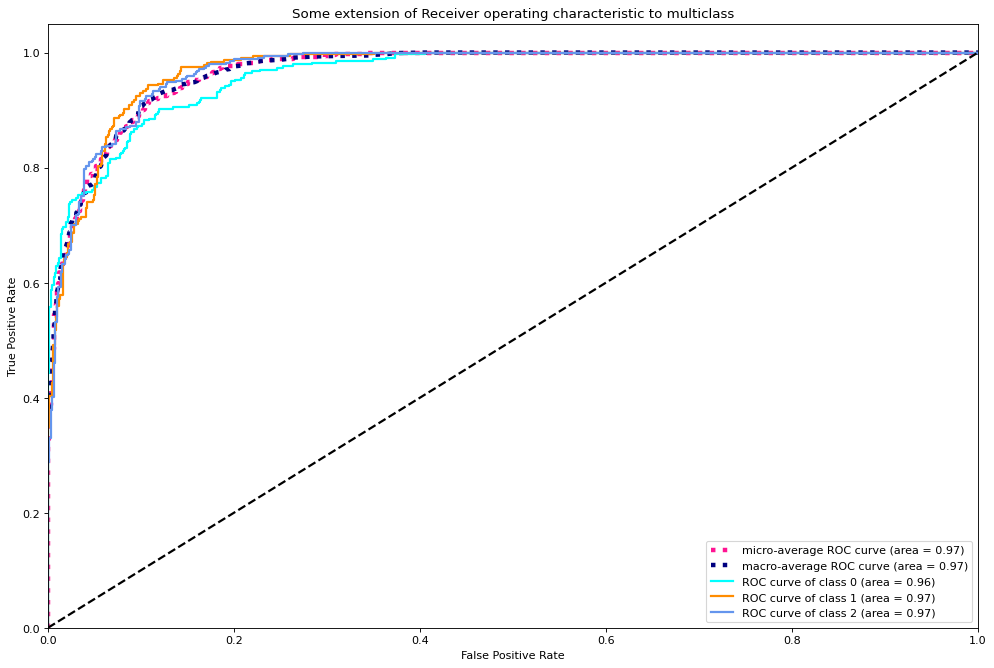

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       339
           1       0.85      0.90      0.88       315
           2       0.87      0.87      0.87       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: XGBoost, calibration algo: isotonic cv


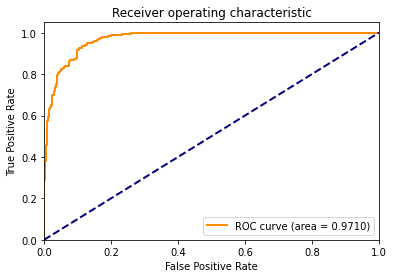

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


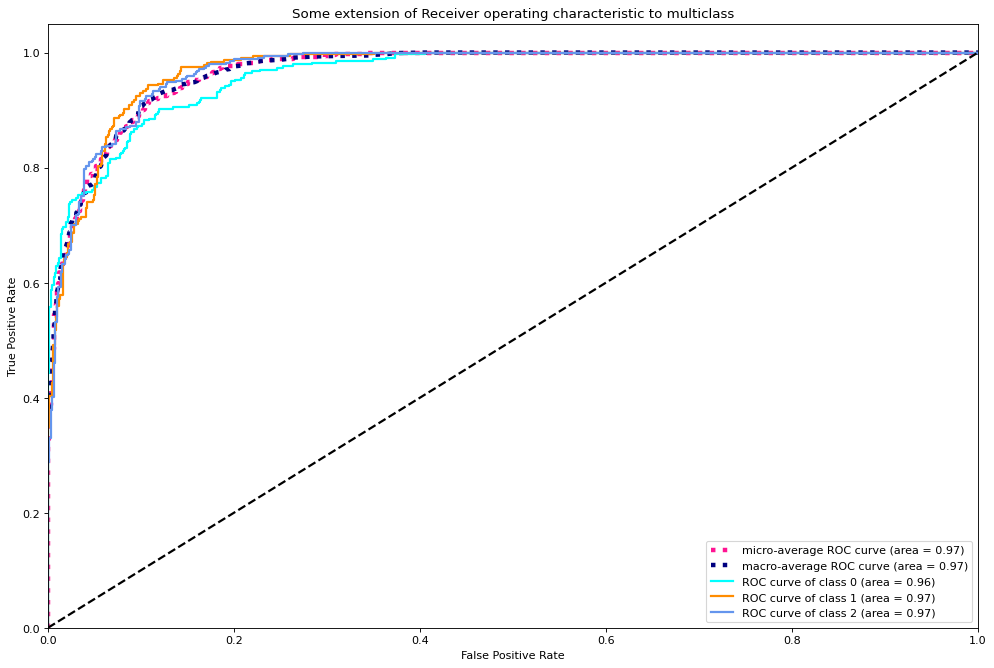

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       339
           1       0.85      0.90      0.87       315
           2       0.86      0.88      0.87       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: XGBoost, calibration algo: ivap


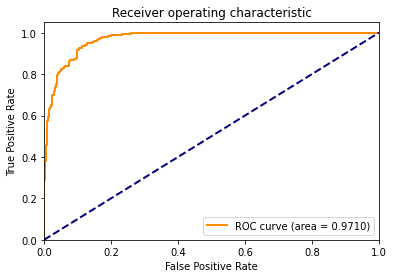

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


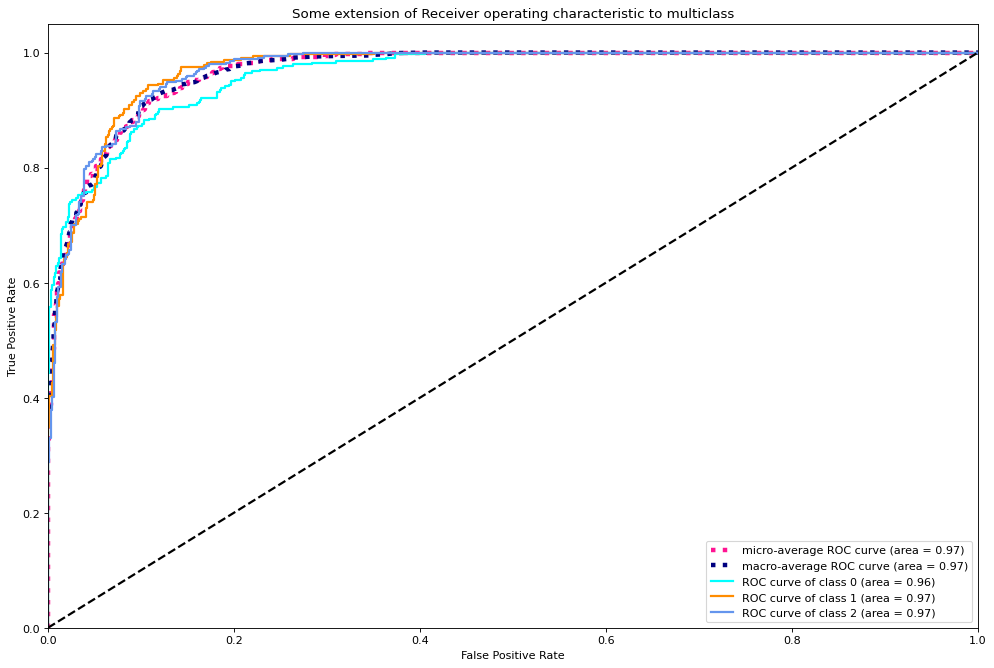

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       339
           1       0.86      0.84      0.85       315
           2       0.86      0.89      0.87       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000


Model name: XGBoost, calibration algo: cvap


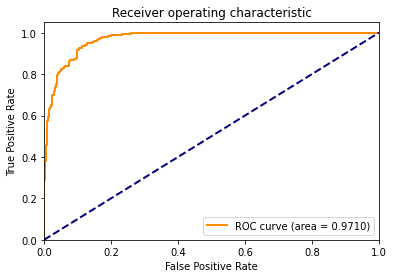

[[[613  48]
  [ 62 277]]

 [[633  52]
  [ 35 280]]

 [[606  48]
  [ 51 295]]]


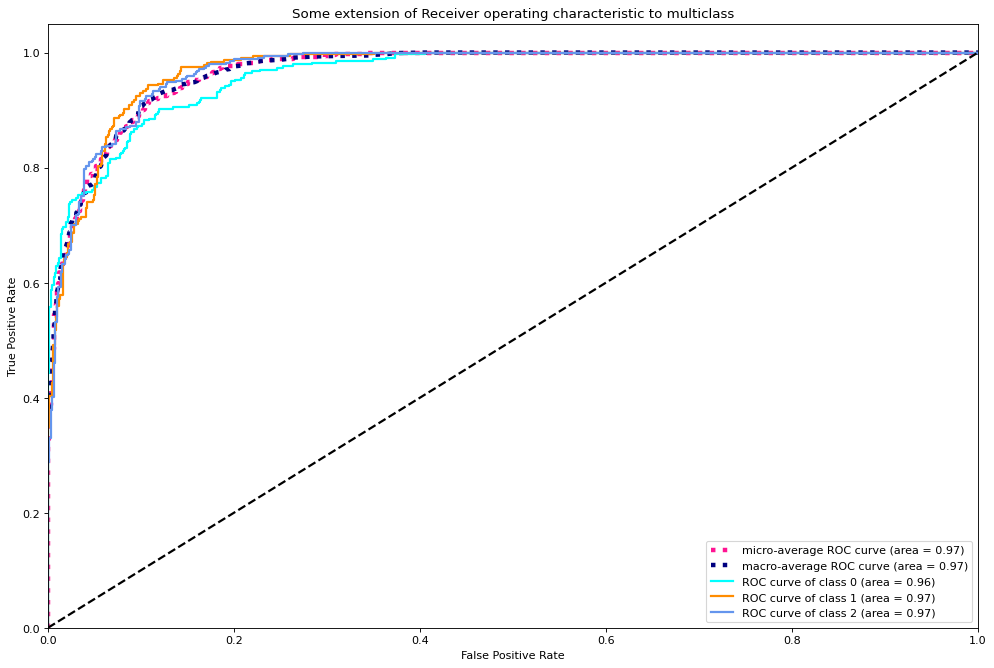

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       339
           1       0.84      0.90      0.87       315
           2       0.86      0.86      0.86       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [82]:
clf_XGBC = XGBClassifier(random_state=42, n_jobs = -1)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_XGBC, 
                    model_name = 'XGBoost')

In [83]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                0.415297  0.446941  0.436216    0.426556   
Random Forest                 0.248640  0.199392  0.198114    0.196041   
LightGBM                      0.237685  0.253351  0.233053    0.230932   
XGBoost                       0.265719  0.251042  0.231889    0.226413   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network             0.411199  0.529545  0.517037  
Random Forest              0.211348  0.206754  0.205550  
LightGBM                   0.217723  0.219853  0.208645  
XGBoost                    0.196033  0.218911  0.208780  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

In [84]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression           0.060485  0.060969  0.061617    0.060253   
neural network                0.132605  0.143581  0.140673    0.135628   
Random Forest                 0.073655  0.062403  0.061811    0.060863   
LightGBM                      0.071930  0.075099  0.068302    0.068645   
XGBoost                       0.075162  0.073809  0.068055    0.066126   
CatBoost                           NaN       NaN       NaN         NaN   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression        0.060417  0.061699  0.060987  
neural network             0.132511  0.175882  0.169513  
Random Forest              0.060742  0.063147  0.062204  
LightGBM                   0.063467  0.068306  0.063960  
XGBoost                    0.062178  0.067904  0.063990  
CatBoost                        NaN       NaN       NaN  
Ada Boost                       NaN       NaN       NaN

### CatBoost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
Learning rate set to 0.12987
0:	learn: 0.5417387	total: 75ms	remaining: 7.42s
1:	learn: 0.4342623	total: 86ms	remaining: 4.21s
2:	learn: 0.3668045	total: 99.9ms	remaining: 3.23s
3:	learn: 0.3181221	total: 111ms	remaining: 2.66s
4:	learn: 0.2879414	total: 122ms	remaining: 2.32s
5:	learn: 0.2647401	total: 133ms	remaining: 2.08s
6:	learn: 0.2412271	total: 144ms	remaining: 1.91s
7:	learn: 0.2290919	total: 156ms	remaining: 1.79s
8:	learn: 0.2194047	total: 170ms	remaining: 1.71s
9:	learn: 0.2093514	total: 181ms	remaining: 1.63s
10:	learn: 0.2016026	total: 192ms	remaining: 1.55s
11:	learn: 0.1924026	total: 203ms	remaining: 1.49s
12:	learn: 0.1866408	total: 214ms	remaining: 1.43s
13:	learn: 0.1800815	total: 225ms	remaining: 1.38s
14:	learn: 0.1754669	total: 236ms	remaining: 1.34s
15:	learn: 0.1712838	total: 247ms	remaining: 1.3s
16:	learn: 0.1675224	total: 258ms	remaining: 1.26s
17:	learn: 0.1626245	total: 269ms	remaining

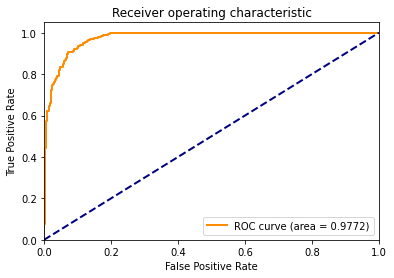

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


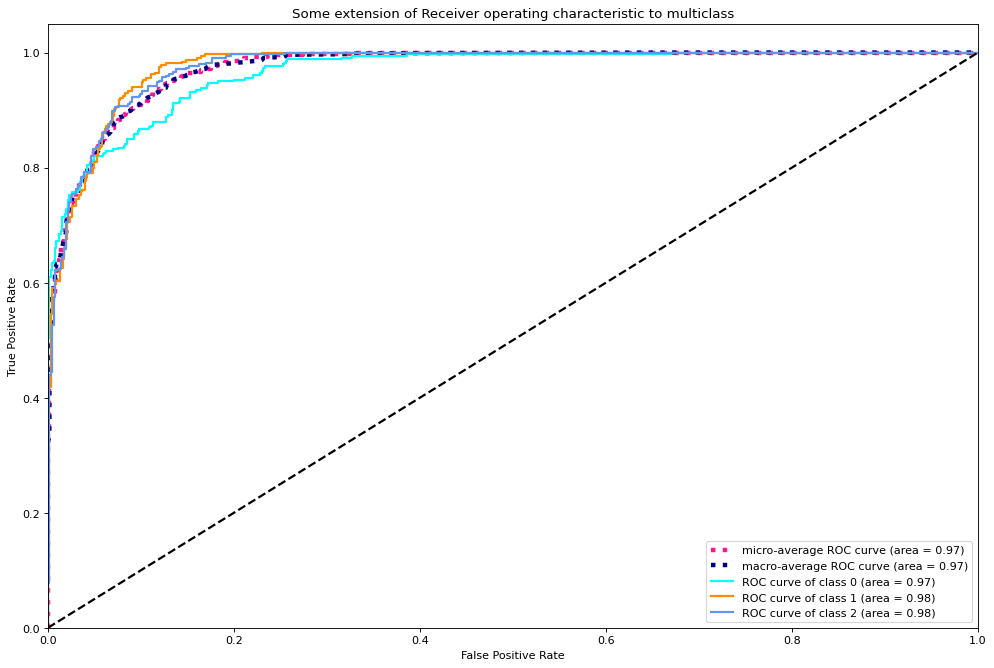

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       339
           1       0.85      0.89      0.87       315
           2       0.88      0.87      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: CatBoost, calibration algo: sigmoid


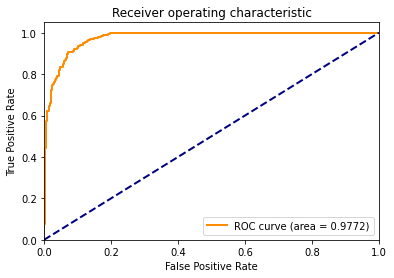

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


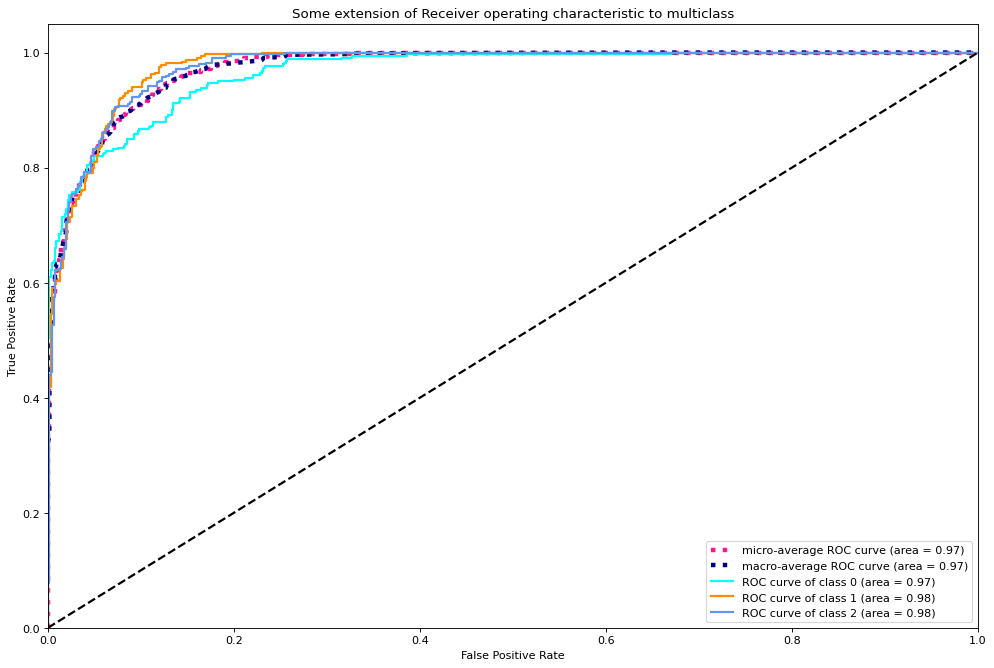

              precision    recall  f1-score   support

           0       0.86      0.85      0.86       339
           1       0.86      0.89      0.88       315
           2       0.89      0.87      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: CatBoost, calibration algo: isotonic


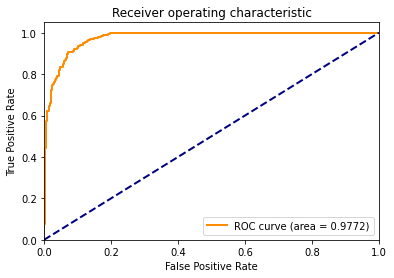

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


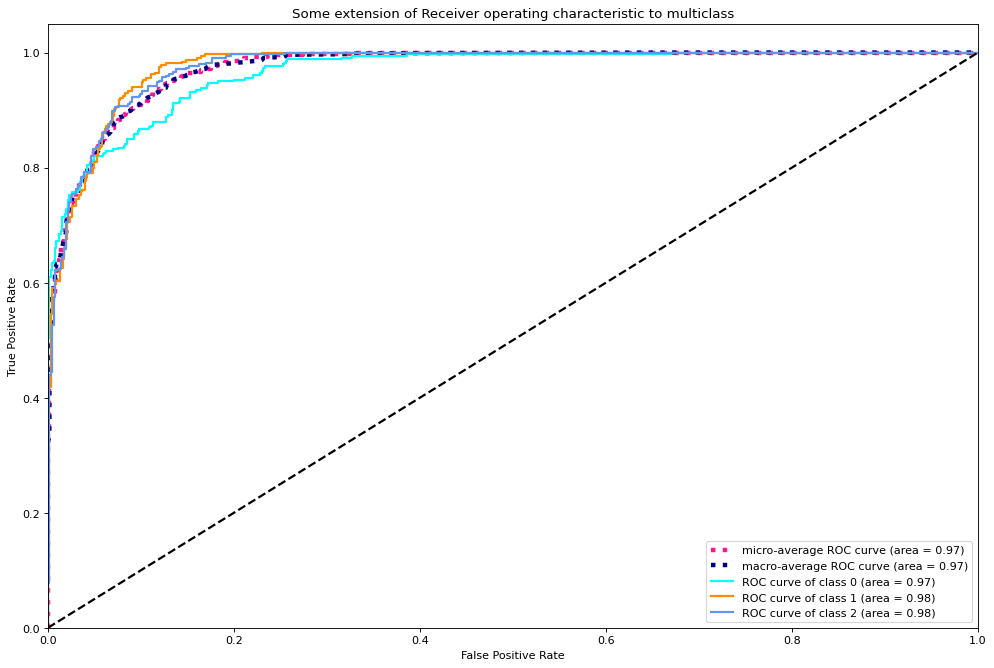

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       339
           1       0.87      0.87      0.87       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: CatBoost, calibration algo: sigmoid cv


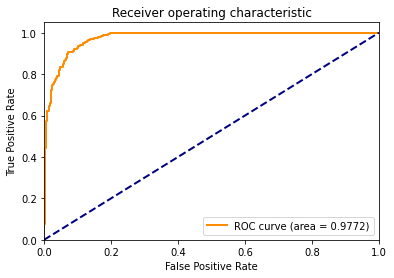

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


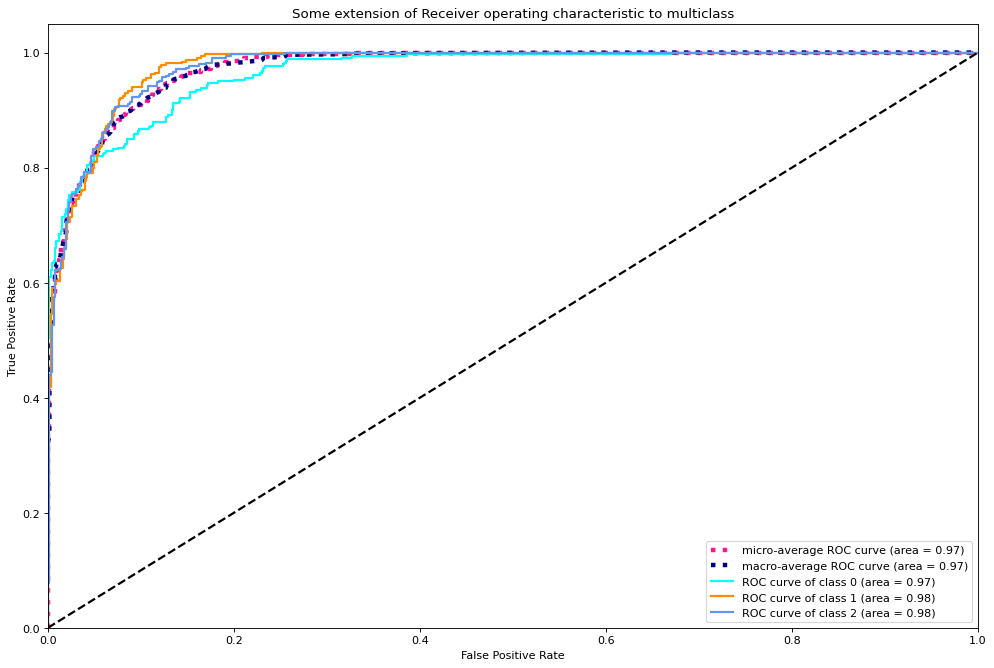

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       339
           1       0.84      0.89      0.87       315
           2       0.88      0.87      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: CatBoost, calibration algo: isotonic cv


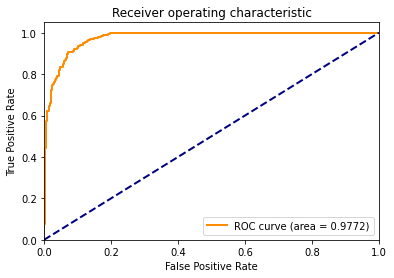

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


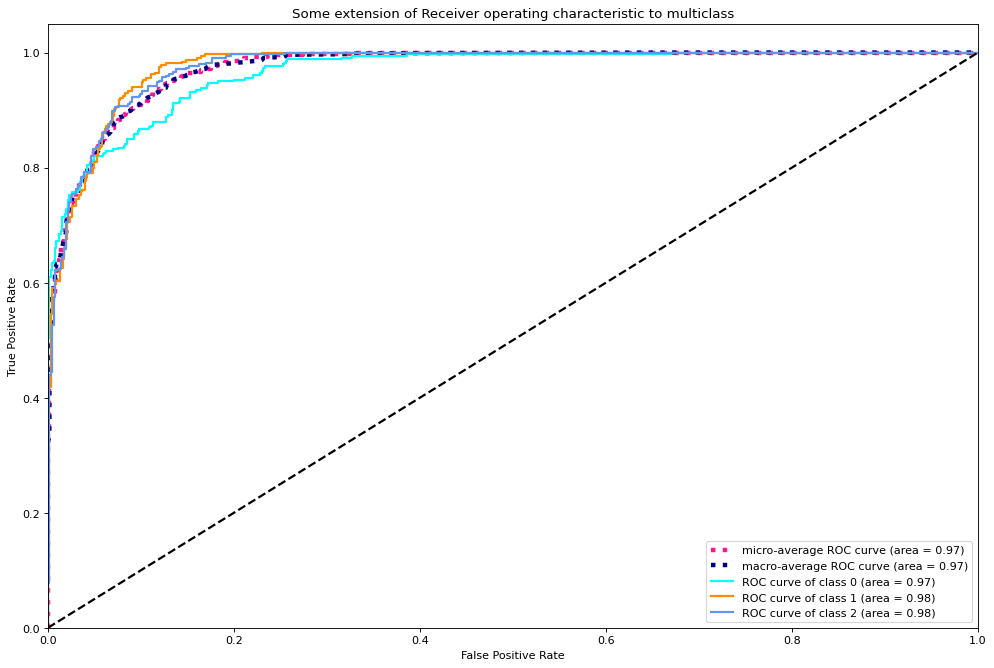

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       339
           1       0.85      0.88      0.86       315
           2       0.88      0.88      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: CatBoost, calibration algo: ivap


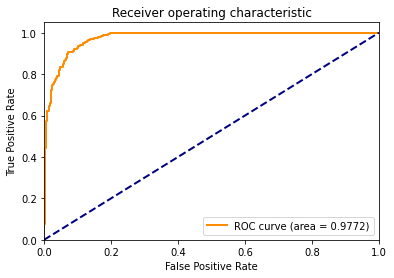

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


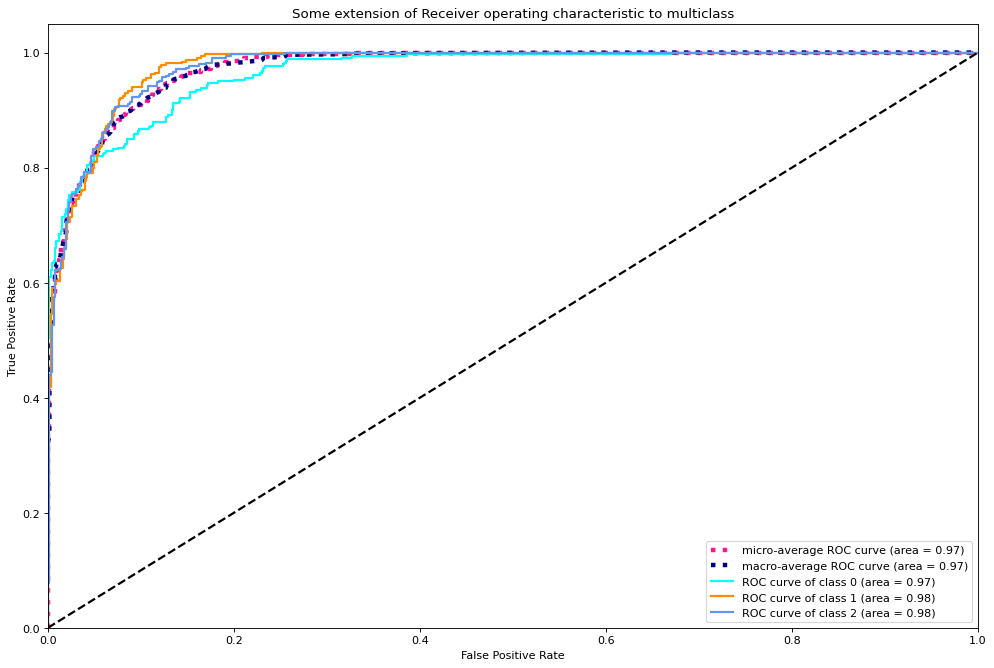

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       339
           1       0.87      0.88      0.87       315
           2       0.87      0.89      0.88       346

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


Model name: CatBoost, calibration algo: cvap


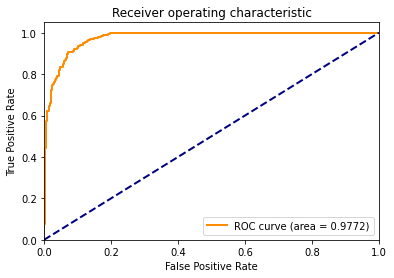

[[[615  46]
  [ 58 281]]

 [[636  49]
  [ 35 280]]

 [[611  43]
  [ 45 301]]]


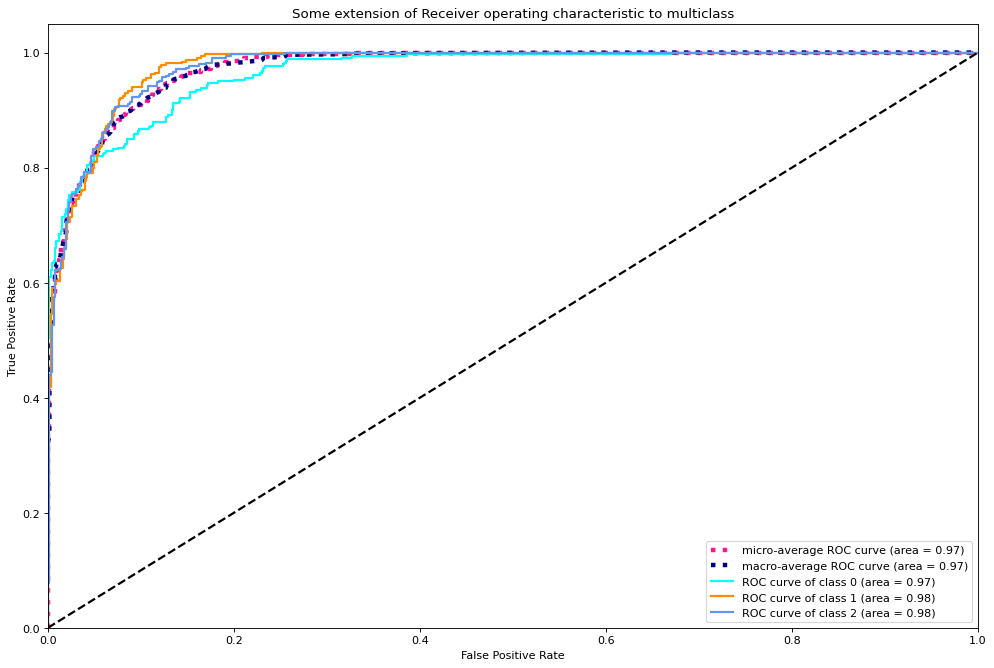

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       339
           1       0.86      0.90      0.88       315
           2       0.88      0.88      0.88       346

    accuracy                           0.88      1000
   macro avg       0.87      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000



In [85]:
clf_CBC = CatBoostClassifier(iterations=100, random_state=42)

[pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_CBC, 
                    model_name = 'CatBoost')

In [86]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                0.415297  0.446941  0.436216    0.426556   
Random Forest                 0.248640  0.199392  0.198114    0.196041   
LightGBM                      0.237685  0.253351  0.233053    0.230932   
XGBoost                       0.265719  0.251042  0.231889    0.226413   
CatBoost                      0.196241  0.225916  0.241316    0.203663   
Ada Boost                          NaN       NaN       NaN         NaN   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network             0.411199  0.529545  0.517037  
Random Forest              0.211348  0.206754  0.205550  
LightGBM                   0.217723  0.219853  0.208645  
XGBoost                    0.196033  0.218911  0.208780  
CatBoost                   0.207616  0.211151  0.200306  
Ada Boost                       NaN       NaN       NaN

### Ada Boost


Computing pairwise uncalibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Computing pairwise calibrated predictions
fitting model for i: 0, j:1
fitting model for i: 0, j:2
fitting model for i: 1, j:0
fitting model for i: 1, j:2
fitting model for i: 2, j:0
fitting model for i: 2, j:1

Model name: Ada Boost, calibration algo: no calibration


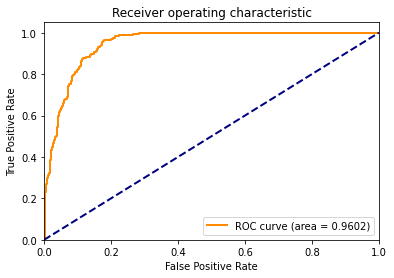

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


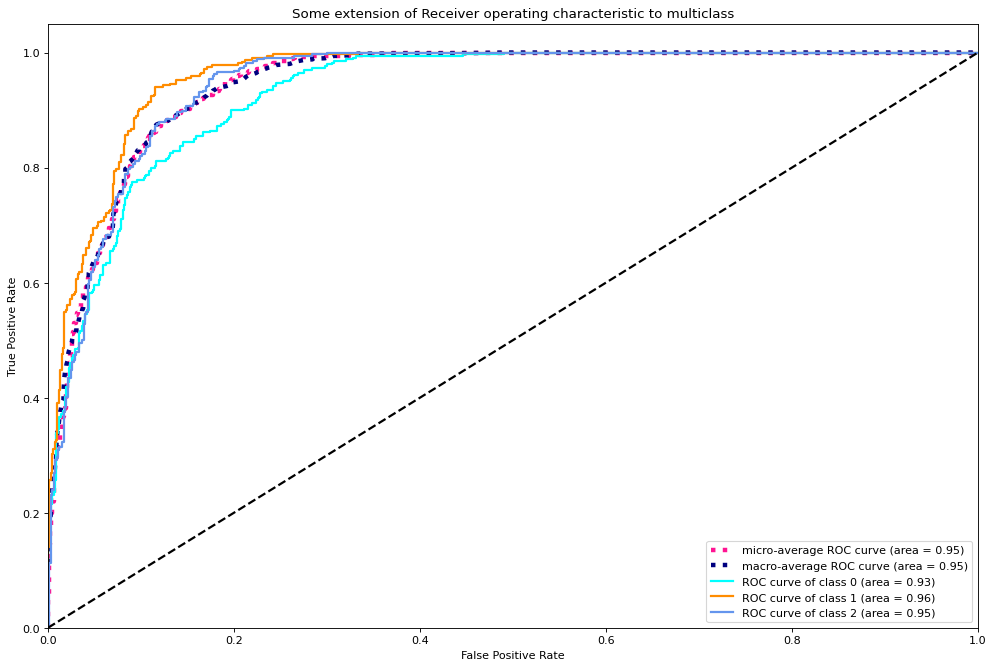

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       339
           1       0.81      0.92      0.86       315
           2       0.84      0.87      0.86       346

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.84      1000


Model name: Ada Boost, calibration algo: sigmoid


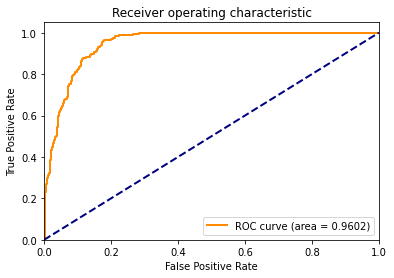

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


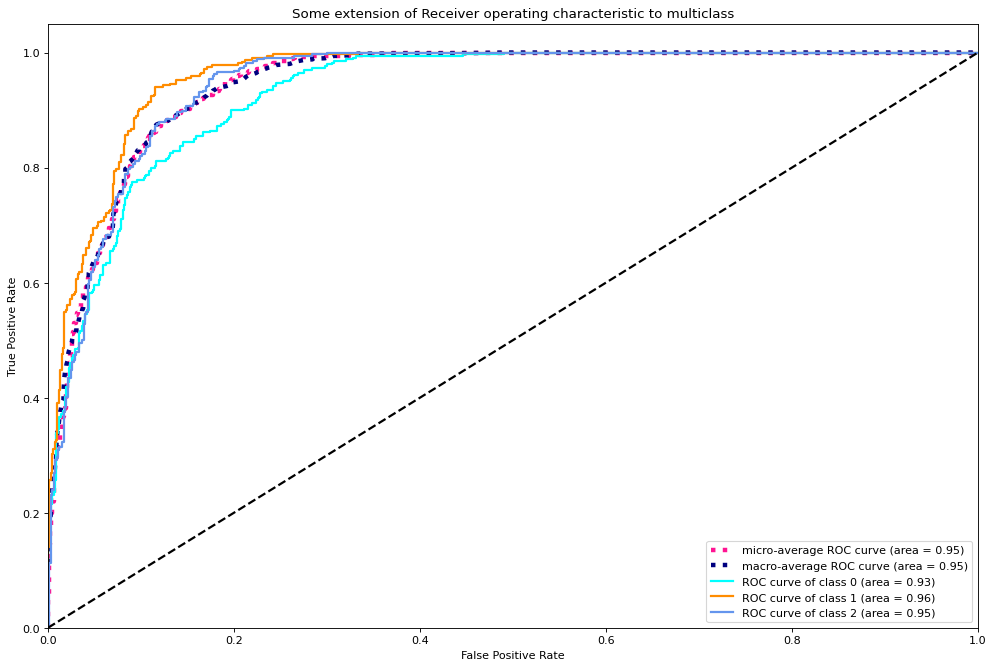

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       339
           1       0.82      0.85      0.83       315
           2       0.83      0.86      0.85       346

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


Model name: Ada Boost, calibration algo: isotonic


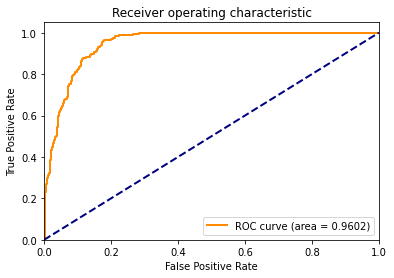

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


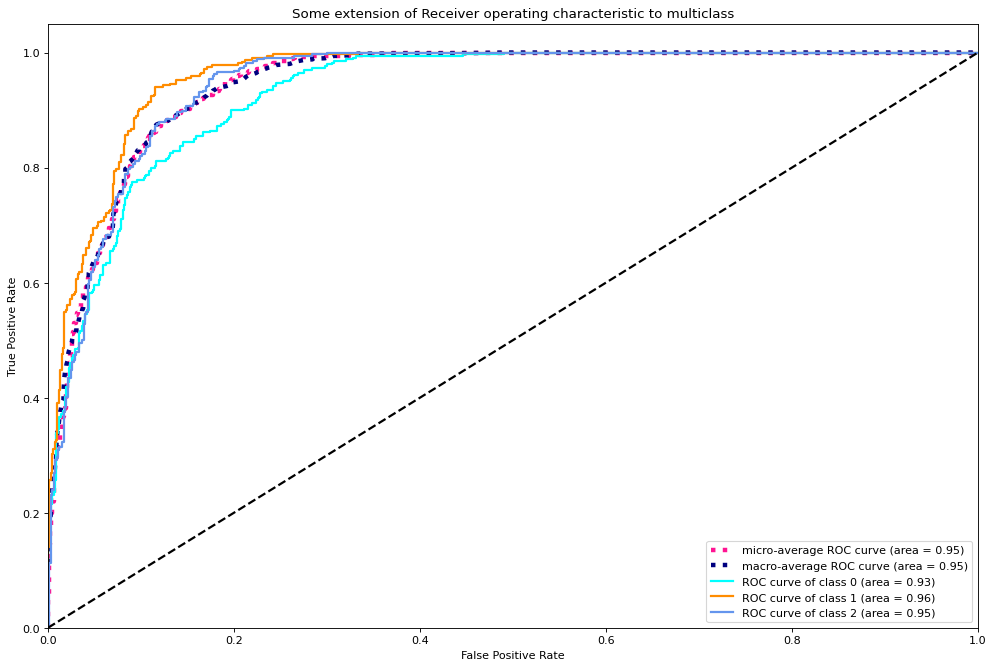

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       339
           1       0.81      0.87      0.84       315
           2       0.83      0.87      0.85       346

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000


Model name: Ada Boost, calibration algo: sigmoid cv


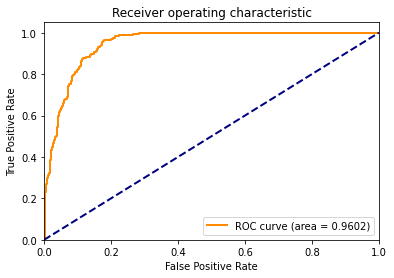

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


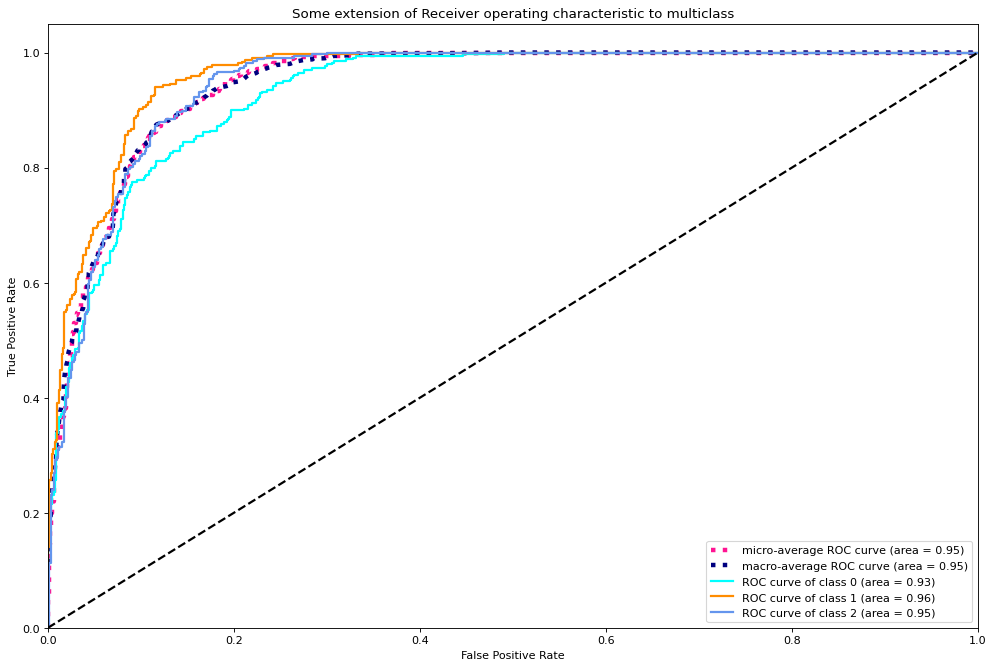

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       339
           1       0.84      0.89      0.87       315
           2       0.89      0.85      0.87       346

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.86      1000
weighted avg       0.87      0.86      0.87      1000


Model name: Ada Boost, calibration algo: isotonic cv


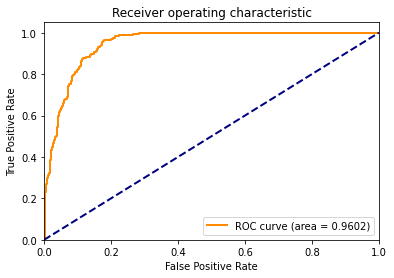

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


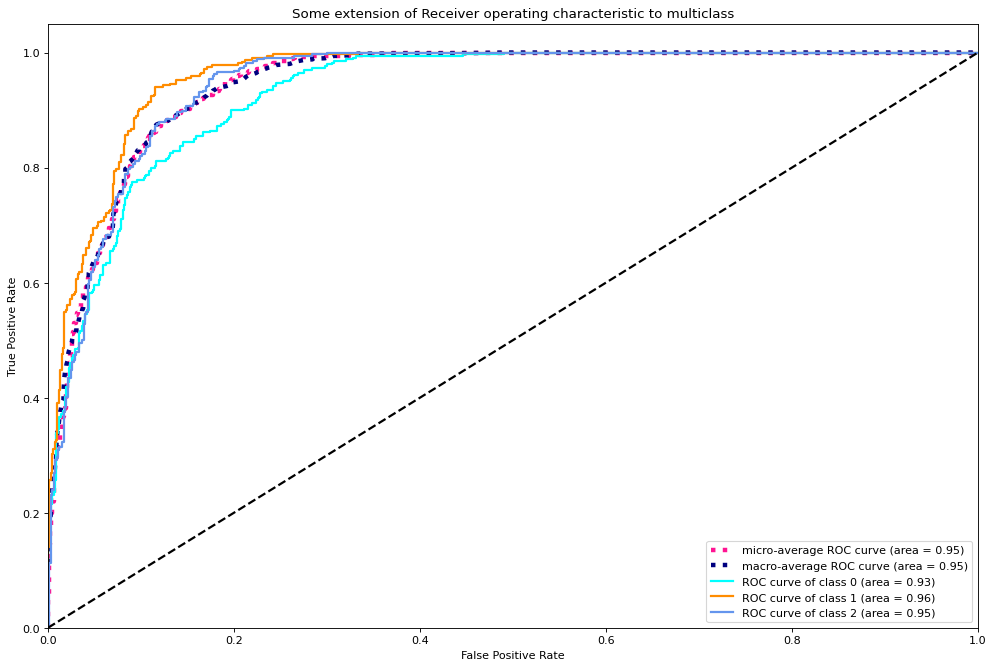

              precision    recall  f1-score   support

           0       0.88      0.83      0.85       339
           1       0.84      0.88      0.86       315
           2       0.86      0.88      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Model name: Ada Boost, calibration algo: ivap


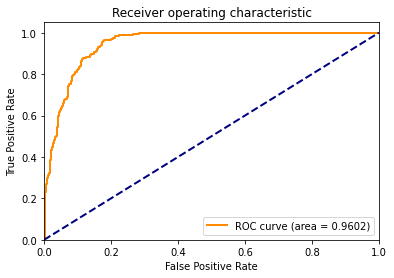

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


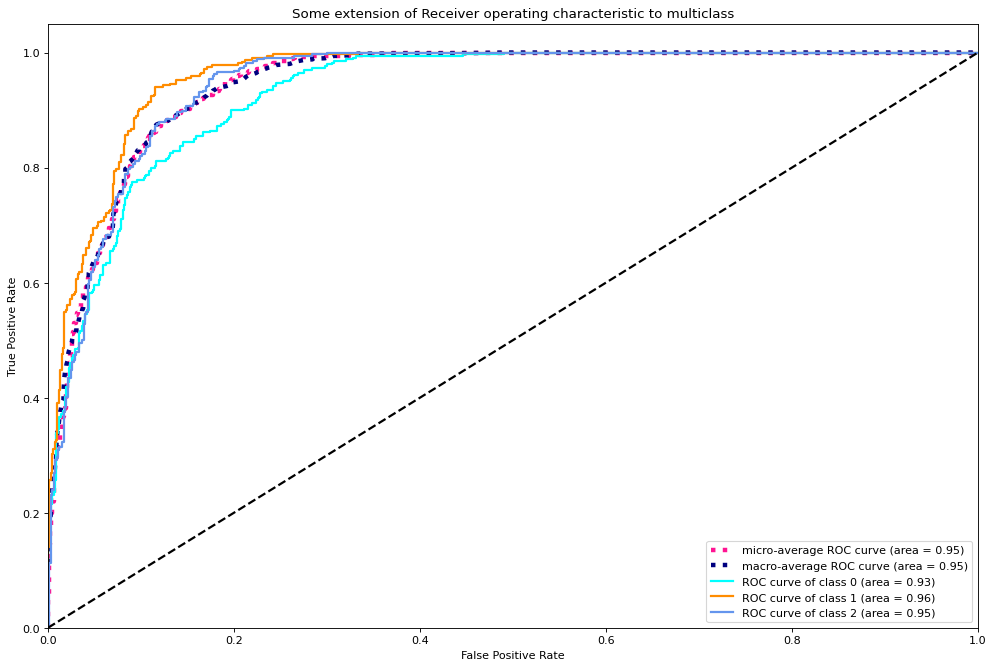

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       339
           1       0.81      0.87      0.84       315
           2       0.83      0.88      0.85       346

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000


Model name: Ada Boost, calibration algo: cvap


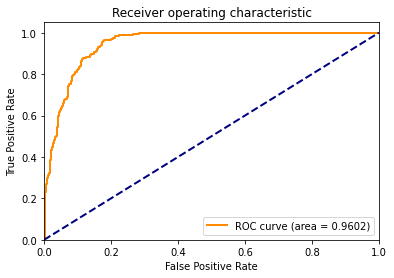

[[[632  29]
  [ 84 255]]

 [[616  69]
  [ 26 289]]

 [[598  56]
  [ 44 302]]]


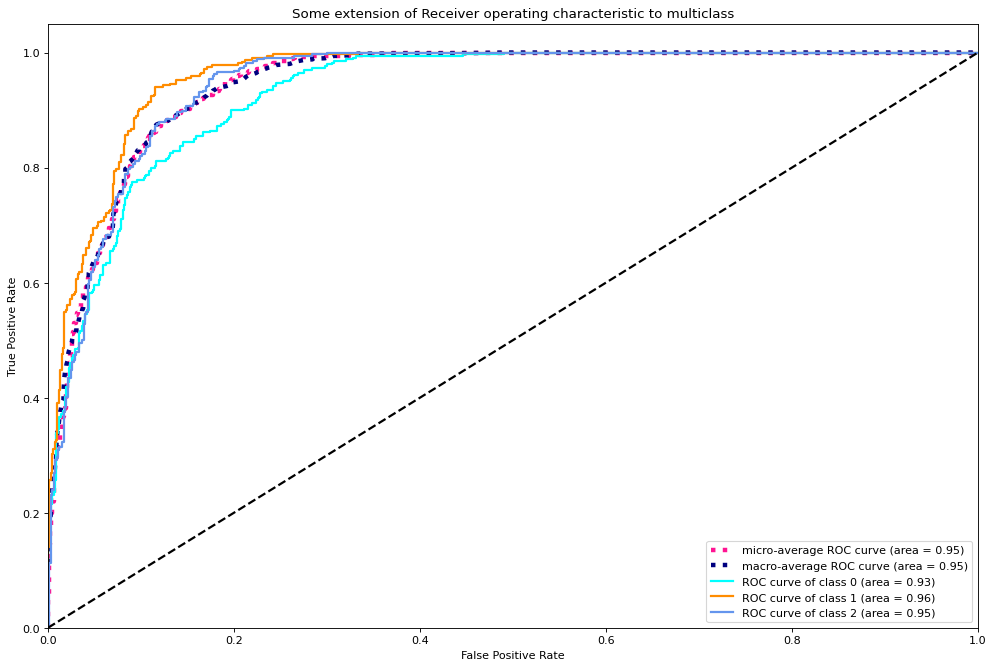

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       339
           1       0.83      0.89      0.86       315
           2       0.87      0.87      0.87       346

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



In [87]:
clf_AdaBoost = AdaBoostClassifier()

[y_pred_probs_list, y_pred_class_list] = compute_predictions(model = clf_AdaBoost, 
                    model_name = 'Ada Boost')

In [88]:
log_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.509601  0.275608  0.318943    0.278664   
KNN                           0.475900  0.268569  0.265523    0.253891   
Support Vector Machine        0.188157  0.192682  0.253557    0.188624   
logistic regression           0.196342  0.198688  0.257648    0.197959   
neural network                0.415297  0.446941  0.436216    0.426556   
Random Forest                 0.248640  0.199392  0.198114    0.196041   
LightGBM                      0.237685  0.253351  0.233053    0.230932   
XGBoost                       0.265719  0.251042  0.231889    0.226413   
CatBoost                      0.196241  0.225916  0.241316    0.203663   
Ada Boost                     0.580757  0.244714  0.335959    0.223530   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.261841  0.227862  0.226844  
KNN                        0.248553  0.363948  0.346960  
Support Vector Machine     0.205113  0.198468  0.192402  
logistic regression        0.215363  0.205220  0.203404  
neural network             0.411199  0.529545  0.517037  
Random Forest              0.211348  0.206754  0.205550  
LightGBM                   0.217723  0.219853  0.208645  
XGBoost                    0.196033  0.218911  0.208780  
CatBoost                   0.207616  0.211151  0.200306  
Ada Boost                  0.238148  0.249825  0.226040

In [89]:
brier_loss_df

no calibration   sigmoid  isotonic  sigmoid cv  \
Naive Bayes                   0.111380  0.084686  0.068923    0.085617   
KNN                           0.082601  0.084320  0.084896    0.079629   
Support Vector Machine        0.058564  0.059494  0.060512    0.058047   
logistic regression           0.060485  0.060969  0.061617    0.060253   
neural network                0.132605  0.143581  0.140673    0.135628   
Random Forest                 0.073655  0.062403  0.061811    0.060863   
LightGBM                      0.071930  0.075099  0.068302    0.068645   
XGBoost                       0.075162  0.073809  0.068055    0.066126   
CatBoost                      0.062573  0.067618  0.064589    0.061002   
Ada Boost                     0.197484  0.076567  0.076408    0.068380   

                        isotonic cv      ivap      cvap  
Naive Bayes                0.068967  0.069841  0.069487  
KNN                        0.079680  0.107851  0.101275  
Support Vector Machine     0.057886  0.060305  0.057851  
logistic regression        0.060417  0.061699  0.060987  
neural network             0.132511  0.175882  0.169513  
Random Forest              0.060742  0.063147  0.062204  
LightGBM                   0.063467  0.068306  0.063960  
XGBoost                    0.062178  0.067904  0.063990  
CatBoost                   0.059629  0.065010  0.060503  
Ada Boost                  0.068774  0.077086  0.068418

In [90]:
log_loss_df.to_csv('satimage_log_loss.csv')
brier_loss_df.to_csv('satimage_brier_loss.csv')